# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\Rishabh Sharma\Anaconda3\envs\tensorflow_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


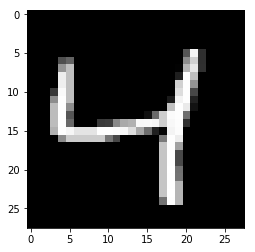

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [4]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32,(None,28,28,1),name="inputs")
targets_ = tf.placeholder(tf.float32,(None,28,28,1),name="outputs")

### Encoder
conv1 = tf.layers.conv2d(inputs_,16,(3,3),padding="same",activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1,(2,2),(2,2),padding="same")
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1,8,(3,3),padding="Same",activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2,(2,2),(2,2),padding="Same")
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool1,8,(3,3),padding="Same",activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,(7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1,8,(3,3),padding="Same",activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4,(14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2,8,(3,3),padding="Same",activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv4,(28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3,16,(3,3),padding="Same",activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [5]:
sess = tf.Session()

In [6]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.7041
Epoch: 1/20... Training loss: 0.6956
Epoch: 1/20... Training loss: 0.6883
Epoch: 1/20... Training loss: 0.6817
Epoch: 1/20... Training loss: 0.6754
Epoch: 1/20... Training loss: 0.6691
Epoch: 1/20... Training loss: 0.6623
Epoch: 1/20... Training loss: 0.6552
Epoch: 1/20... Training loss: 0.6483
Epoch: 1/20... Training loss: 0.6399
Epoch: 1/20... Training loss: 0.6324
Epoch: 1/20... Training loss: 0.6243
Epoch: 1/20... Training loss: 0.6161
Epoch: 1/20... Training loss: 0.6028
Epoch: 1/20... Training loss: 0.6019
Epoch: 1/20... Training loss: 0.5915
Epoch: 1/20... Training loss: 0.5886
Epoch: 1/20... Training loss: 0.5776
Epoch: 1/20... Training loss: 0.5769
Epoch: 1/20... Training loss: 0.5720
Epoch: 1/20... Training loss: 0.5699
Epoch: 1/20... Training loss: 0.5576
Epoch: 1/20... Training loss: 0.5506
Epoch: 1/20... Training loss: 0.5554
Epoch: 1/20... Training loss: 0.5461
Epoch: 1/20... Training loss: 0.5222
Epoch: 1/20... Training loss: 0.5197
E

Epoch: 1/20... Training loss: 0.1124
Epoch: 1/20... Training loss: 0.1092
Epoch: 1/20... Training loss: 0.1097
Epoch: 1/20... Training loss: 0.1114
Epoch: 1/20... Training loss: 0.1056
Epoch: 1/20... Training loss: 0.1080
Epoch: 1/20... Training loss: 0.1074
Epoch: 1/20... Training loss: 0.1054
Epoch: 1/20... Training loss: 0.1071
Epoch: 1/20... Training loss: 0.1085
Epoch: 1/20... Training loss: 0.1092
Epoch: 1/20... Training loss: 0.1065
Epoch: 1/20... Training loss: 0.1053
Epoch: 1/20... Training loss: 0.1075
Epoch: 1/20... Training loss: 0.1099
Epoch: 1/20... Training loss: 0.1051
Epoch: 1/20... Training loss: 0.1061
Epoch: 1/20... Training loss: 0.1056
Epoch: 1/20... Training loss: 0.1089
Epoch: 1/20... Training loss: 0.1046
Epoch: 1/20... Training loss: 0.1061
Epoch: 1/20... Training loss: 0.1101
Epoch: 1/20... Training loss: 0.1049
Epoch: 1/20... Training loss: 0.1047
Epoch: 1/20... Training loss: 0.1052
Epoch: 1/20... Training loss: 0.1049
Epoch: 1/20... Training loss: 0.1058
E

Epoch: 2/20... Training loss: 0.0918
Epoch: 2/20... Training loss: 0.0946
Epoch: 2/20... Training loss: 0.0948
Epoch: 2/20... Training loss: 0.0921
Epoch: 2/20... Training loss: 0.0926
Epoch: 2/20... Training loss: 0.0928
Epoch: 2/20... Training loss: 0.0912
Epoch: 2/20... Training loss: 0.0901
Epoch: 2/20... Training loss: 0.0981
Epoch: 2/20... Training loss: 0.0958
Epoch: 2/20... Training loss: 0.0944
Epoch: 2/20... Training loss: 0.0955
Epoch: 2/20... Training loss: 0.0931
Epoch: 2/20... Training loss: 0.0964
Epoch: 2/20... Training loss: 0.0953
Epoch: 2/20... Training loss: 0.0919
Epoch: 2/20... Training loss: 0.0975
Epoch: 2/20... Training loss: 0.0936
Epoch: 2/20... Training loss: 0.0942
Epoch: 2/20... Training loss: 0.0901
Epoch: 2/20... Training loss: 0.0926
Epoch: 2/20... Training loss: 0.0962
Epoch: 2/20... Training loss: 0.0940
Epoch: 2/20... Training loss: 0.0937
Epoch: 2/20... Training loss: 0.0916
Epoch: 2/20... Training loss: 0.0906
Epoch: 2/20... Training loss: 0.0926
E

Epoch: 3/20... Training loss: 0.0903
Epoch: 3/20... Training loss: 0.0862
Epoch: 3/20... Training loss: 0.0857
Epoch: 3/20... Training loss: 0.0872
Epoch: 3/20... Training loss: 0.0868
Epoch: 3/20... Training loss: 0.0894
Epoch: 3/20... Training loss: 0.0841
Epoch: 3/20... Training loss: 0.0887
Epoch: 3/20... Training loss: 0.0895
Epoch: 3/20... Training loss: 0.0887
Epoch: 3/20... Training loss: 0.0885
Epoch: 3/20... Training loss: 0.0915
Epoch: 3/20... Training loss: 0.0876
Epoch: 3/20... Training loss: 0.0857
Epoch: 3/20... Training loss: 0.0874
Epoch: 3/20... Training loss: 0.0884
Epoch: 3/20... Training loss: 0.0891
Epoch: 3/20... Training loss: 0.0847
Epoch: 3/20... Training loss: 0.0859
Epoch: 3/20... Training loss: 0.0869
Epoch: 3/20... Training loss: 0.0854
Epoch: 3/20... Training loss: 0.0884
Epoch: 3/20... Training loss: 0.0849
Epoch: 3/20... Training loss: 0.0847
Epoch: 3/20... Training loss: 0.0868
Epoch: 3/20... Training loss: 0.0879
Epoch: 3/20... Training loss: 0.0882
E

Epoch: 4/20... Training loss: 0.0826
Epoch: 4/20... Training loss: 0.0850
Epoch: 4/20... Training loss: 0.0853
Epoch: 4/20... Training loss: 0.0823
Epoch: 4/20... Training loss: 0.0834
Epoch: 4/20... Training loss: 0.0848
Epoch: 4/20... Training loss: 0.0817
Epoch: 4/20... Training loss: 0.0812
Epoch: 4/20... Training loss: 0.0849
Epoch: 4/20... Training loss: 0.0804
Epoch: 4/20... Training loss: 0.0854
Epoch: 4/20... Training loss: 0.0824
Epoch: 4/20... Training loss: 0.0838
Epoch: 4/20... Training loss: 0.0848
Epoch: 4/20... Training loss: 0.0848
Epoch: 4/20... Training loss: 0.0870
Epoch: 4/20... Training loss: 0.0811
Epoch: 4/20... Training loss: 0.0827
Epoch: 4/20... Training loss: 0.0837
Epoch: 4/20... Training loss: 0.0822
Epoch: 4/20... Training loss: 0.0802
Epoch: 4/20... Training loss: 0.0842
Epoch: 4/20... Training loss: 0.0834
Epoch: 4/20... Training loss: 0.0830
Epoch: 4/20... Training loss: 0.0857
Epoch: 4/20... Training loss: 0.0831
Epoch: 4/20... Training loss: 0.0860
E

Epoch: 4/20... Training loss: 0.0840
Epoch: 4/20... Training loss: 0.0793
Epoch: 4/20... Training loss: 0.0825
Epoch: 4/20... Training loss: 0.0800
Epoch: 4/20... Training loss: 0.0830
Epoch: 4/20... Training loss: 0.0826
Epoch: 4/20... Training loss: 0.0828
Epoch: 4/20... Training loss: 0.0823
Epoch: 4/20... Training loss: 0.0785
Epoch: 4/20... Training loss: 0.0810
Epoch: 4/20... Training loss: 0.0798
Epoch: 4/20... Training loss: 0.0803
Epoch: 4/20... Training loss: 0.0831
Epoch: 4/20... Training loss: 0.0837
Epoch: 4/20... Training loss: 0.0833
Epoch: 4/20... Training loss: 0.0821
Epoch: 4/20... Training loss: 0.0818
Epoch: 4/20... Training loss: 0.0843
Epoch: 4/20... Training loss: 0.0833
Epoch: 4/20... Training loss: 0.0842
Epoch: 4/20... Training loss: 0.0816
Epoch: 4/20... Training loss: 0.0845
Epoch: 4/20... Training loss: 0.0816
Epoch: 4/20... Training loss: 0.0825
Epoch: 4/20... Training loss: 0.0799
Epoch: 4/20... Training loss: 0.0801
Epoch: 4/20... Training loss: 0.0790
E

Epoch: 5/20... Training loss: 0.0793
Epoch: 5/20... Training loss: 0.0803
Epoch: 5/20... Training loss: 0.0791
Epoch: 5/20... Training loss: 0.0801
Epoch: 5/20... Training loss: 0.0766
Epoch: 5/20... Training loss: 0.0820
Epoch: 5/20... Training loss: 0.0792
Epoch: 5/20... Training loss: 0.0828
Epoch: 5/20... Training loss: 0.0831
Epoch: 5/20... Training loss: 0.0789
Epoch: 5/20... Training loss: 0.0790
Epoch: 5/20... Training loss: 0.0825
Epoch: 5/20... Training loss: 0.0792
Epoch: 5/20... Training loss: 0.0817
Epoch: 5/20... Training loss: 0.0810
Epoch: 5/20... Training loss: 0.0785
Epoch: 5/20... Training loss: 0.0820
Epoch: 5/20... Training loss: 0.0813
Epoch: 5/20... Training loss: 0.0782
Epoch: 5/20... Training loss: 0.0812
Epoch: 5/20... Training loss: 0.0788
Epoch: 5/20... Training loss: 0.0791
Epoch: 5/20... Training loss: 0.0818
Epoch: 5/20... Training loss: 0.0804
Epoch: 5/20... Training loss: 0.0802
Epoch: 5/20... Training loss: 0.0780
Epoch: 5/20... Training loss: 0.0811
E

Epoch: 6/20... Training loss: 0.0820
Epoch: 6/20... Training loss: 0.0784
Epoch: 6/20... Training loss: 0.0817
Epoch: 6/20... Training loss: 0.0800
Epoch: 6/20... Training loss: 0.0801
Epoch: 6/20... Training loss: 0.0785
Epoch: 6/20... Training loss: 0.0802
Epoch: 6/20... Training loss: 0.0828
Epoch: 6/20... Training loss: 0.0819
Epoch: 6/20... Training loss: 0.0838
Epoch: 6/20... Training loss: 0.0813
Epoch: 6/20... Training loss: 0.0789
Epoch: 6/20... Training loss: 0.0786
Epoch: 6/20... Training loss: 0.0801
Epoch: 6/20... Training loss: 0.0803
Epoch: 6/20... Training loss: 0.0792
Epoch: 6/20... Training loss: 0.0767
Epoch: 6/20... Training loss: 0.0786
Epoch: 6/20... Training loss: 0.0782
Epoch: 6/20... Training loss: 0.0795
Epoch: 6/20... Training loss: 0.0790
Epoch: 6/20... Training loss: 0.0806
Epoch: 6/20... Training loss: 0.0798
Epoch: 6/20... Training loss: 0.0805
Epoch: 6/20... Training loss: 0.0786
Epoch: 6/20... Training loss: 0.0807
Epoch: 6/20... Training loss: 0.0803
E

Epoch: 7/20... Training loss: 0.0778
Epoch: 7/20... Training loss: 0.0763
Epoch: 7/20... Training loss: 0.0804
Epoch: 7/20... Training loss: 0.0776
Epoch: 7/20... Training loss: 0.0778
Epoch: 7/20... Training loss: 0.0767
Epoch: 7/20... Training loss: 0.0756
Epoch: 7/20... Training loss: 0.0786
Epoch: 7/20... Training loss: 0.0802
Epoch: 7/20... Training loss: 0.0776
Epoch: 7/20... Training loss: 0.0797
Epoch: 7/20... Training loss: 0.0772
Epoch: 7/20... Training loss: 0.0773
Epoch: 7/20... Training loss: 0.0808
Epoch: 7/20... Training loss: 0.0794
Epoch: 7/20... Training loss: 0.0788
Epoch: 7/20... Training loss: 0.0803
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0783
Epoch: 7/20... Training loss: 0.0761
Epoch: 7/20... Training loss: 0.0785
Epoch: 7/20... Training loss: 0.0794
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0788
Epoch: 7/20... Training loss: 0.0780
Epoch: 7/20... Training loss: 0.0813
Epoch: 7/20... Training loss: 0.0761
E

Epoch: 7/20... Training loss: 0.0790
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0776
Epoch: 7/20... Training loss: 0.0778
Epoch: 7/20... Training loss: 0.0769
Epoch: 7/20... Training loss: 0.0786
Epoch: 7/20... Training loss: 0.0805
Epoch: 7/20... Training loss: 0.0784
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0781
Epoch: 7/20... Training loss: 0.0817
Epoch: 7/20... Training loss: 0.0778
Epoch: 7/20... Training loss: 0.0765
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0787
Epoch: 7/20... Training loss: 0.0793
Epoch: 7/20... Training loss: 0.0808
Epoch: 7/20... Training loss: 0.0767
Epoch: 7/20... Training loss: 0.0793
Epoch: 7/20... Training loss: 0.0797
Epoch: 7/20... Training loss: 0.0763
Epoch: 7/20... Training loss: 0.0786
Epoch: 7/20... Training loss: 0.0752
Epoch: 7/20... Training loss: 0.0748
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0769
E

Epoch: 8/20... Training loss: 0.0772
Epoch: 8/20... Training loss: 0.0773
Epoch: 8/20... Training loss: 0.0757
Epoch: 8/20... Training loss: 0.0769
Epoch: 8/20... Training loss: 0.0778
Epoch: 8/20... Training loss: 0.0774
Epoch: 8/20... Training loss: 0.0763
Epoch: 8/20... Training loss: 0.0763
Epoch: 8/20... Training loss: 0.0757
Epoch: 8/20... Training loss: 0.0765
Epoch: 8/20... Training loss: 0.0781
Epoch: 8/20... Training loss: 0.0807
Epoch: 8/20... Training loss: 0.0787
Epoch: 8/20... Training loss: 0.0792
Epoch: 8/20... Training loss: 0.0741
Epoch: 8/20... Training loss: 0.0763
Epoch: 8/20... Training loss: 0.0770
Epoch: 8/20... Training loss: 0.0777
Epoch: 8/20... Training loss: 0.0780
Epoch: 8/20... Training loss: 0.0763
Epoch: 8/20... Training loss: 0.0775
Epoch: 8/20... Training loss: 0.0771
Epoch: 8/20... Training loss: 0.0743
Epoch: 8/20... Training loss: 0.0755
Epoch: 8/20... Training loss: 0.0793
Epoch: 8/20... Training loss: 0.0775
Epoch: 8/20... Training loss: 0.0762
E

Epoch: 9/20... Training loss: 0.0784
Epoch: 9/20... Training loss: 0.0780
Epoch: 9/20... Training loss: 0.0767
Epoch: 9/20... Training loss: 0.0783
Epoch: 9/20... Training loss: 0.0794
Epoch: 9/20... Training loss: 0.0771
Epoch: 9/20... Training loss: 0.0774
Epoch: 9/20... Training loss: 0.0785
Epoch: 9/20... Training loss: 0.0766
Epoch: 9/20... Training loss: 0.0781
Epoch: 9/20... Training loss: 0.0757
Epoch: 9/20... Training loss: 0.0755
Epoch: 9/20... Training loss: 0.0778
Epoch: 9/20... Training loss: 0.0750
Epoch: 9/20... Training loss: 0.0747
Epoch: 9/20... Training loss: 0.0754
Epoch: 9/20... Training loss: 0.0776
Epoch: 9/20... Training loss: 0.0773
Epoch: 9/20... Training loss: 0.0777
Epoch: 9/20... Training loss: 0.0786
Epoch: 9/20... Training loss: 0.0758
Epoch: 9/20... Training loss: 0.0743
Epoch: 9/20... Training loss: 0.0766
Epoch: 9/20... Training loss: 0.0771
Epoch: 9/20... Training loss: 0.0779
Epoch: 9/20... Training loss: 0.0756
Epoch: 9/20... Training loss: 0.0777
E

Epoch: 10/20... Training loss: 0.0759
Epoch: 10/20... Training loss: 0.0760
Epoch: 10/20... Training loss: 0.0778
Epoch: 10/20... Training loss: 0.0769
Epoch: 10/20... Training loss: 0.0768
Epoch: 10/20... Training loss: 0.0794
Epoch: 10/20... Training loss: 0.0782
Epoch: 10/20... Training loss: 0.0754
Epoch: 10/20... Training loss: 0.0769
Epoch: 10/20... Training loss: 0.0766
Epoch: 10/20... Training loss: 0.0783
Epoch: 10/20... Training loss: 0.0760
Epoch: 10/20... Training loss: 0.0749
Epoch: 10/20... Training loss: 0.0757
Epoch: 10/20... Training loss: 0.0761
Epoch: 10/20... Training loss: 0.0768
Epoch: 10/20... Training loss: 0.0781
Epoch: 10/20... Training loss: 0.0780
Epoch: 10/20... Training loss: 0.0777
Epoch: 10/20... Training loss: 0.0761
Epoch: 10/20... Training loss: 0.0759
Epoch: 10/20... Training loss: 0.0773
Epoch: 10/20... Training loss: 0.0765
Epoch: 10/20... Training loss: 0.0757
Epoch: 10/20... Training loss: 0.0752
Epoch: 10/20... Training loss: 0.0764
Epoch: 10/20

Epoch: 10/20... Training loss: 0.0772
Epoch: 10/20... Training loss: 0.0745
Epoch: 10/20... Training loss: 0.0767
Epoch: 10/20... Training loss: 0.0757
Epoch: 10/20... Training loss: 0.0782
Epoch: 10/20... Training loss: 0.0734
Epoch: 10/20... Training loss: 0.0753
Epoch: 10/20... Training loss: 0.0769
Epoch: 10/20... Training loss: 0.0755
Epoch: 10/20... Training loss: 0.0788
Epoch: 10/20... Training loss: 0.0753
Epoch: 10/20... Training loss: 0.0770
Epoch: 10/20... Training loss: 0.0767
Epoch: 10/20... Training loss: 0.0733
Epoch: 10/20... Training loss: 0.0759
Epoch: 10/20... Training loss: 0.0777
Epoch: 10/20... Training loss: 0.0774
Epoch: 10/20... Training loss: 0.0769
Epoch: 10/20... Training loss: 0.0769
Epoch: 10/20... Training loss: 0.0749
Epoch: 10/20... Training loss: 0.0741
Epoch: 10/20... Training loss: 0.0766
Epoch: 10/20... Training loss: 0.0772
Epoch: 10/20... Training loss: 0.0760
Epoch: 10/20... Training loss: 0.0758
Epoch: 10/20... Training loss: 0.0745
Epoch: 10/20

Epoch: 11/20... Training loss: 0.0755
Epoch: 11/20... Training loss: 0.0740
Epoch: 11/20... Training loss: 0.0756
Epoch: 11/20... Training loss: 0.0771
Epoch: 11/20... Training loss: 0.0756
Epoch: 11/20... Training loss: 0.0760
Epoch: 11/20... Training loss: 0.0747
Epoch: 11/20... Training loss: 0.0750
Epoch: 11/20... Training loss: 0.0761
Epoch: 11/20... Training loss: 0.0750
Epoch: 11/20... Training loss: 0.0745
Epoch: 11/20... Training loss: 0.0786
Epoch: 11/20... Training loss: 0.0749
Epoch: 11/20... Training loss: 0.0749
Epoch: 11/20... Training loss: 0.0754
Epoch: 11/20... Training loss: 0.0764
Epoch: 11/20... Training loss: 0.0738
Epoch: 11/20... Training loss: 0.0779
Epoch: 11/20... Training loss: 0.0765
Epoch: 11/20... Training loss: 0.0759
Epoch: 11/20... Training loss: 0.0764
Epoch: 11/20... Training loss: 0.0738
Epoch: 11/20... Training loss: 0.0746
Epoch: 11/20... Training loss: 0.0762
Epoch: 11/20... Training loss: 0.0762
Epoch: 11/20... Training loss: 0.0754
Epoch: 11/20

Epoch: 12/20... Training loss: 0.0744
Epoch: 12/20... Training loss: 0.0776
Epoch: 12/20... Training loss: 0.0725
Epoch: 12/20... Training loss: 0.0760
Epoch: 12/20... Training loss: 0.0753
Epoch: 12/20... Training loss: 0.0730
Epoch: 12/20... Training loss: 0.0771
Epoch: 12/20... Training loss: 0.0740
Epoch: 12/20... Training loss: 0.0776
Epoch: 12/20... Training loss: 0.0751
Epoch: 12/20... Training loss: 0.0751
Epoch: 12/20... Training loss: 0.0742
Epoch: 12/20... Training loss: 0.0746
Epoch: 12/20... Training loss: 0.0747
Epoch: 12/20... Training loss: 0.0754
Epoch: 12/20... Training loss: 0.0745
Epoch: 12/20... Training loss: 0.0757
Epoch: 12/20... Training loss: 0.0761
Epoch: 12/20... Training loss: 0.0752
Epoch: 12/20... Training loss: 0.0742
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0728
Epoch: 12/20... Training loss: 0.0748
Epoch: 12/20... Training loss: 0.0747
Epoch: 12/20... Training loss: 0.0741
Epoch: 12/20

Epoch: 12/20... Training loss: 0.0755
Epoch: 12/20... Training loss: 0.0763
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0748
Epoch: 12/20... Training loss: 0.0753
Epoch: 12/20... Training loss: 0.0732
Epoch: 12/20... Training loss: 0.0702
Epoch: 12/20... Training loss: 0.0763
Epoch: 12/20... Training loss: 0.0770
Epoch: 12/20... Training loss: 0.0741
Epoch: 12/20... Training loss: 0.0747
Epoch: 12/20... Training loss: 0.0730
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0733
Epoch: 12/20... Training loss: 0.0723
Epoch: 12/20... Training loss: 0.0735
Epoch: 12/20... Training loss: 0.0756
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0749
Epoch: 12/20... Training loss: 0.0736
Epoch: 13/20... Training loss: 0.0730
Epoch: 13/20... Training loss: 0.0751
Epoch: 13/20... Training loss: 0.0749
Epoch: 13/20... Training loss: 0.0767
Epoch: 13/20... Training loss: 0.0719
Epoch: 13/20... Training loss: 0.0753
Epoch: 13/20

Epoch: 13/20... Training loss: 0.0763
Epoch: 13/20... Training loss: 0.0758
Epoch: 13/20... Training loss: 0.0757
Epoch: 13/20... Training loss: 0.0732
Epoch: 13/20... Training loss: 0.0754
Epoch: 13/20... Training loss: 0.0724
Epoch: 13/20... Training loss: 0.0745
Epoch: 13/20... Training loss: 0.0743
Epoch: 13/20... Training loss: 0.0741
Epoch: 13/20... Training loss: 0.0752
Epoch: 13/20... Training loss: 0.0727
Epoch: 13/20... Training loss: 0.0727
Epoch: 13/20... Training loss: 0.0742
Epoch: 13/20... Training loss: 0.0760
Epoch: 13/20... Training loss: 0.0768
Epoch: 13/20... Training loss: 0.0752
Epoch: 13/20... Training loss: 0.0743
Epoch: 13/20... Training loss: 0.0733
Epoch: 13/20... Training loss: 0.0771
Epoch: 13/20... Training loss: 0.0759
Epoch: 13/20... Training loss: 0.0748
Epoch: 13/20... Training loss: 0.0746
Epoch: 13/20... Training loss: 0.0763
Epoch: 13/20... Training loss: 0.0761
Epoch: 13/20... Training loss: 0.0722
Epoch: 13/20... Training loss: 0.0747
Epoch: 13/20

Epoch: 14/20... Training loss: 0.0737
Epoch: 14/20... Training loss: 0.0753
Epoch: 14/20... Training loss: 0.0733
Epoch: 14/20... Training loss: 0.0756
Epoch: 14/20... Training loss: 0.0735
Epoch: 14/20... Training loss: 0.0712
Epoch: 14/20... Training loss: 0.0761
Epoch: 14/20... Training loss: 0.0729
Epoch: 14/20... Training loss: 0.0745
Epoch: 14/20... Training loss: 0.0729
Epoch: 14/20... Training loss: 0.0751
Epoch: 14/20... Training loss: 0.0739
Epoch: 14/20... Training loss: 0.0738
Epoch: 14/20... Training loss: 0.0753
Epoch: 14/20... Training loss: 0.0747
Epoch: 14/20... Training loss: 0.0762
Epoch: 14/20... Training loss: 0.0729
Epoch: 14/20... Training loss: 0.0730
Epoch: 14/20... Training loss: 0.0760
Epoch: 14/20... Training loss: 0.0752
Epoch: 14/20... Training loss: 0.0732
Epoch: 14/20... Training loss: 0.0741
Epoch: 14/20... Training loss: 0.0736
Epoch: 14/20... Training loss: 0.0738
Epoch: 14/20... Training loss: 0.0733
Epoch: 14/20... Training loss: 0.0734
Epoch: 14/20

Epoch: 15/20... Training loss: 0.0735
Epoch: 15/20... Training loss: 0.0740
Epoch: 15/20... Training loss: 0.0725
Epoch: 15/20... Training loss: 0.0741
Epoch: 15/20... Training loss: 0.0762
Epoch: 15/20... Training loss: 0.0766
Epoch: 15/20... Training loss: 0.0744
Epoch: 15/20... Training loss: 0.0732
Epoch: 15/20... Training loss: 0.0728
Epoch: 15/20... Training loss: 0.0722
Epoch: 15/20... Training loss: 0.0751
Epoch: 15/20... Training loss: 0.0717
Epoch: 15/20... Training loss: 0.0755
Epoch: 15/20... Training loss: 0.0767
Epoch: 15/20... Training loss: 0.0749
Epoch: 15/20... Training loss: 0.0735
Epoch: 15/20... Training loss: 0.0717
Epoch: 15/20... Training loss: 0.0729
Epoch: 15/20... Training loss: 0.0725
Epoch: 15/20... Training loss: 0.0747
Epoch: 15/20... Training loss: 0.0739
Epoch: 15/20... Training loss: 0.0739
Epoch: 15/20... Training loss: 0.0724
Epoch: 15/20... Training loss: 0.0737
Epoch: 15/20... Training loss: 0.0751
Epoch: 15/20... Training loss: 0.0735
Epoch: 15/20

Epoch: 15/20... Training loss: 0.0747
Epoch: 15/20... Training loss: 0.0716
Epoch: 15/20... Training loss: 0.0759
Epoch: 15/20... Training loss: 0.0758
Epoch: 15/20... Training loss: 0.0757
Epoch: 15/20... Training loss: 0.0739
Epoch: 15/20... Training loss: 0.0742
Epoch: 15/20... Training loss: 0.0741
Epoch: 15/20... Training loss: 0.0704
Epoch: 15/20... Training loss: 0.0747
Epoch: 15/20... Training loss: 0.0747
Epoch: 15/20... Training loss: 0.0728
Epoch: 15/20... Training loss: 0.0735
Epoch: 15/20... Training loss: 0.0760
Epoch: 15/20... Training loss: 0.0744
Epoch: 15/20... Training loss: 0.0728
Epoch: 15/20... Training loss: 0.0736
Epoch: 15/20... Training loss: 0.0760
Epoch: 15/20... Training loss: 0.0751
Epoch: 15/20... Training loss: 0.0738
Epoch: 15/20... Training loss: 0.0727
Epoch: 15/20... Training loss: 0.0739
Epoch: 15/20... Training loss: 0.0742
Epoch: 15/20... Training loss: 0.0731
Epoch: 15/20... Training loss: 0.0730
Epoch: 15/20... Training loss: 0.0715
Epoch: 15/20

Epoch: 16/20... Training loss: 0.0719
Epoch: 16/20... Training loss: 0.0771
Epoch: 16/20... Training loss: 0.0750
Epoch: 16/20... Training loss: 0.0749
Epoch: 16/20... Training loss: 0.0731
Epoch: 16/20... Training loss: 0.0761
Epoch: 16/20... Training loss: 0.0750
Epoch: 16/20... Training loss: 0.0764
Epoch: 16/20... Training loss: 0.0736
Epoch: 16/20... Training loss: 0.0726
Epoch: 16/20... Training loss: 0.0728
Epoch: 16/20... Training loss: 0.0744
Epoch: 16/20... Training loss: 0.0735
Epoch: 16/20... Training loss: 0.0752
Epoch: 16/20... Training loss: 0.0737
Epoch: 16/20... Training loss: 0.0720
Epoch: 16/20... Training loss: 0.0756
Epoch: 16/20... Training loss: 0.0738
Epoch: 16/20... Training loss: 0.0732
Epoch: 16/20... Training loss: 0.0710
Epoch: 16/20... Training loss: 0.0742
Epoch: 16/20... Training loss: 0.0731
Epoch: 16/20... Training loss: 0.0745
Epoch: 16/20... Training loss: 0.0734
Epoch: 16/20... Training loss: 0.0742
Epoch: 16/20... Training loss: 0.0731
Epoch: 16/20

Epoch: 17/20... Training loss: 0.0750
Epoch: 17/20... Training loss: 0.0746
Epoch: 17/20... Training loss: 0.0757
Epoch: 17/20... Training loss: 0.0758
Epoch: 17/20... Training loss: 0.0765
Epoch: 17/20... Training loss: 0.0754
Epoch: 17/20... Training loss: 0.0743
Epoch: 17/20... Training loss: 0.0753
Epoch: 17/20... Training loss: 0.0760
Epoch: 17/20... Training loss: 0.0742
Epoch: 17/20... Training loss: 0.0755
Epoch: 17/20... Training loss: 0.0728
Epoch: 17/20... Training loss: 0.0737
Epoch: 17/20... Training loss: 0.0760
Epoch: 17/20... Training loss: 0.0733
Epoch: 17/20... Training loss: 0.0747
Epoch: 17/20... Training loss: 0.0728
Epoch: 17/20... Training loss: 0.0746
Epoch: 17/20... Training loss: 0.0719
Epoch: 17/20... Training loss: 0.0758
Epoch: 17/20... Training loss: 0.0738
Epoch: 17/20... Training loss: 0.0760
Epoch: 17/20... Training loss: 0.0743
Epoch: 17/20... Training loss: 0.0728
Epoch: 17/20... Training loss: 0.0765
Epoch: 17/20... Training loss: 0.0726
Epoch: 17/20

Epoch: 18/20... Training loss: 0.0733
Epoch: 18/20... Training loss: 0.0734
Epoch: 18/20... Training loss: 0.0744
Epoch: 18/20... Training loss: 0.0741
Epoch: 18/20... Training loss: 0.0739
Epoch: 18/20... Training loss: 0.0764
Epoch: 18/20... Training loss: 0.0720
Epoch: 18/20... Training loss: 0.0716
Epoch: 18/20... Training loss: 0.0729
Epoch: 18/20... Training loss: 0.0737
Epoch: 18/20... Training loss: 0.0711
Epoch: 18/20... Training loss: 0.0724
Epoch: 18/20... Training loss: 0.0743
Epoch: 18/20... Training loss: 0.0723
Epoch: 18/20... Training loss: 0.0734
Epoch: 18/20... Training loss: 0.0725
Epoch: 18/20... Training loss: 0.0723
Epoch: 18/20... Training loss: 0.0735
Epoch: 18/20... Training loss: 0.0733
Epoch: 18/20... Training loss: 0.0746
Epoch: 18/20... Training loss: 0.0715
Epoch: 18/20... Training loss: 0.0734
Epoch: 18/20... Training loss: 0.0760
Epoch: 18/20... Training loss: 0.0736
Epoch: 18/20... Training loss: 0.0731
Epoch: 18/20... Training loss: 0.0741
Epoch: 18/20

Epoch: 18/20... Training loss: 0.0731
Epoch: 18/20... Training loss: 0.0761
Epoch: 18/20... Training loss: 0.0725
Epoch: 18/20... Training loss: 0.0742
Epoch: 18/20... Training loss: 0.0735
Epoch: 18/20... Training loss: 0.0734
Epoch: 18/20... Training loss: 0.0729
Epoch: 18/20... Training loss: 0.0741
Epoch: 18/20... Training loss: 0.0746
Epoch: 18/20... Training loss: 0.0725
Epoch: 18/20... Training loss: 0.0742
Epoch: 18/20... Training loss: 0.0734
Epoch: 18/20... Training loss: 0.0740
Epoch: 18/20... Training loss: 0.0708
Epoch: 18/20... Training loss: 0.0774
Epoch: 18/20... Training loss: 0.0734
Epoch: 18/20... Training loss: 0.0717
Epoch: 18/20... Training loss: 0.0741
Epoch: 18/20... Training loss: 0.0734
Epoch: 18/20... Training loss: 0.0751
Epoch: 18/20... Training loss: 0.0747
Epoch: 18/20... Training loss: 0.0751
Epoch: 18/20... Training loss: 0.0728
Epoch: 18/20... Training loss: 0.0749
Epoch: 18/20... Training loss: 0.0748
Epoch: 18/20... Training loss: 0.0736
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0731
Epoch: 19/20... Training loss: 0.0763
Epoch: 19/20... Training loss: 0.0753
Epoch: 19/20... Training loss: 0.0734
Epoch: 19/20... Training loss: 0.0731
Epoch: 19/20... Training loss: 0.0717
Epoch: 19/20... Training loss: 0.0736
Epoch: 19/20... Training loss: 0.0717
Epoch: 19/20... Training loss: 0.0723
Epoch: 19/20... Training loss: 0.0749
Epoch: 19/20... Training loss: 0.0757
Epoch: 19/20... Training loss: 0.0715
Epoch: 19/20... Training loss: 0.0707
Epoch: 19/20... Training loss: 0.0736
Epoch: 19/20... Training loss: 0.0719
Epoch: 19/20... Training loss: 0.0745
Epoch: 19/20... Training loss: 0.0747
Epoch: 19/20... Training loss: 0.0743
Epoch: 19/20... Training loss: 0.0715
Epoch: 19/20... Training loss: 0.0745
Epoch: 19/20... Training loss: 0.0720
Epoch: 19/20... Training loss: 0.0725
Epoch: 19/20... Training loss: 0.0736
Epoch: 19/20... Training loss: 0.0735
Epoch: 19/20... Training loss: 0.0731
Epoch: 19/20... Training loss: 0.0727
Epoch: 19/20

Epoch: 20/20... Training loss: 0.0753
Epoch: 20/20... Training loss: 0.0734
Epoch: 20/20... Training loss: 0.0747
Epoch: 20/20... Training loss: 0.0741
Epoch: 20/20... Training loss: 0.0729
Epoch: 20/20... Training loss: 0.0746
Epoch: 20/20... Training loss: 0.0726
Epoch: 20/20... Training loss: 0.0724
Epoch: 20/20... Training loss: 0.0736
Epoch: 20/20... Training loss: 0.0736
Epoch: 20/20... Training loss: 0.0721
Epoch: 20/20... Training loss: 0.0711
Epoch: 20/20... Training loss: 0.0740
Epoch: 20/20... Training loss: 0.0713
Epoch: 20/20... Training loss: 0.0728
Epoch: 20/20... Training loss: 0.0724
Epoch: 20/20... Training loss: 0.0752
Epoch: 20/20... Training loss: 0.0739
Epoch: 20/20... Training loss: 0.0735
Epoch: 20/20... Training loss: 0.0755
Epoch: 20/20... Training loss: 0.0736
Epoch: 20/20... Training loss: 0.0734
Epoch: 20/20... Training loss: 0.0718
Epoch: 20/20... Training loss: 0.0734
Epoch: 20/20... Training loss: 0.0732
Epoch: 20/20... Training loss: 0.0748
Epoch: 20/20

Epoch: 20/20... Training loss: 0.0734
Epoch: 20/20... Training loss: 0.0744
Epoch: 20/20... Training loss: 0.0734
Epoch: 20/20... Training loss: 0.0724
Epoch: 20/20... Training loss: 0.0748
Epoch: 20/20... Training loss: 0.0742
Epoch: 20/20... Training loss: 0.0734
Epoch: 20/20... Training loss: 0.0733
Epoch: 20/20... Training loss: 0.0709
Epoch: 20/20... Training loss: 0.0745


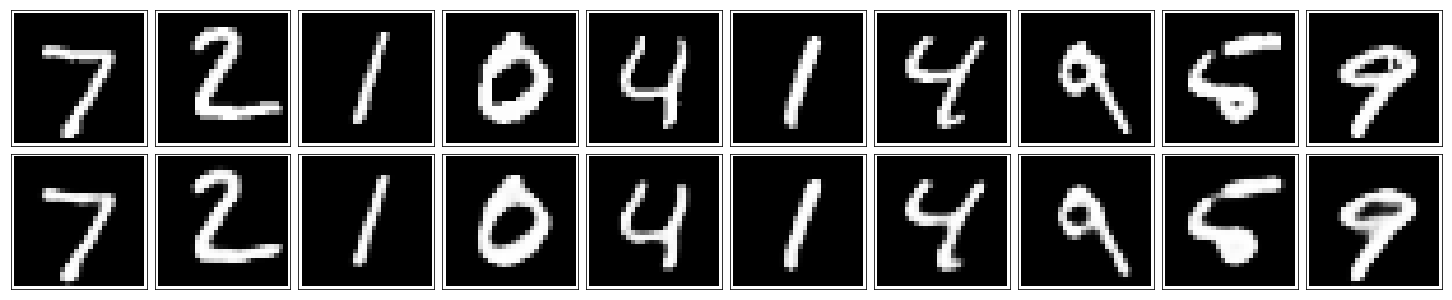

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [8]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [8]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_,32,(3,3),padding="Same",activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1,(2,2),(2,2))
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1,32,(3,3),activation=tf.nn.relu,padding="Same")
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2,(2,2),(2,2))
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2,16,(3,3),activation=tf.nn.relu,padding="Same")
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3,(2,2),(2,2))
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,(7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1,16,(3,3),activation=tf.nn.relu,padding="Same")
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4,(14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2,32,(3,3),activation=tf.nn.relu,padding="Same")
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv4,(28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3,32,(3,3),activation=tf.nn.relu,padding="Same")
# Now 28x28x32

logits = tf.layers.conv2d(conv6,1,(3,3),padding="Same")
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_,logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [9]:
sess = tf.Session()

In [10]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.7154
Epoch: 1/100... Training loss: 0.6836
Epoch: 1/100... Training loss: 0.6619
Epoch: 1/100... Training loss: 0.6334
Epoch: 1/100... Training loss: 0.6001
Epoch: 1/100... Training loss: 0.5627
Epoch: 1/100... Training loss: 0.5177
Epoch: 1/100... Training loss: 0.4779
Epoch: 1/100... Training loss: 0.4735
Epoch: 1/100... Training loss: 0.4823
Epoch: 1/100... Training loss: 0.4974
Epoch: 1/100... Training loss: 0.4994
Epoch: 1/100... Training loss: 0.4897
Epoch: 1/100... Training loss: 0.4830
Epoch: 1/100... Training loss: 0.4372
Epoch: 1/100... Training loss: 0.4369
Epoch: 1/100... Training loss: 0.4428
Epoch: 1/100... Training loss: 0.4366
Epoch: 1/100... Training loss: 0.4377
Epoch: 1/100... Training loss: 0.4341
Epoch: 1/100... Training loss: 0.4275
Epoch: 1/100... Training loss: 0.4292
Epoch: 1/100... Training loss: 0.4139
Epoch: 1/100... Training loss: 0.4117
Epoch: 1/100... Training loss: 0.4162
Epoch: 1/100... Training loss: 0.3928
Epoch: 1/100

Epoch: 1/100... Training loss: 0.1995
Epoch: 1/100... Training loss: 0.2033
Epoch: 1/100... Training loss: 0.2069
Epoch: 1/100... Training loss: 0.2012
Epoch: 1/100... Training loss: 0.2021
Epoch: 1/100... Training loss: 0.2036
Epoch: 1/100... Training loss: 0.2014
Epoch: 1/100... Training loss: 0.2005
Epoch: 1/100... Training loss: 0.2031
Epoch: 1/100... Training loss: 0.2074
Epoch: 1/100... Training loss: 0.2039
Epoch: 1/100... Training loss: 0.2029
Epoch: 1/100... Training loss: 0.2002
Epoch: 1/100... Training loss: 0.2048
Epoch: 1/100... Training loss: 0.2060
Epoch: 1/100... Training loss: 0.2000
Epoch: 1/100... Training loss: 0.2011
Epoch: 1/100... Training loss: 0.1974
Epoch: 1/100... Training loss: 0.2004
Epoch: 1/100... Training loss: 0.2042
Epoch: 1/100... Training loss: 0.2023
Epoch: 1/100... Training loss: 0.1977
Epoch: 1/100... Training loss: 0.2034
Epoch: 1/100... Training loss: 0.2026
Epoch: 1/100... Training loss: 0.1945
Epoch: 1/100... Training loss: 0.1956
Epoch: 1/100

Epoch: 2/100... Training loss: 0.1801
Epoch: 2/100... Training loss: 0.1771
Epoch: 2/100... Training loss: 0.1803
Epoch: 2/100... Training loss: 0.1802
Epoch: 2/100... Training loss: 0.1790
Epoch: 2/100... Training loss: 0.1781
Epoch: 2/100... Training loss: 0.1756
Epoch: 2/100... Training loss: 0.1788
Epoch: 2/100... Training loss: 0.1807
Epoch: 2/100... Training loss: 0.1730
Epoch: 2/100... Training loss: 0.1806
Epoch: 2/100... Training loss: 0.1779
Epoch: 2/100... Training loss: 0.1762
Epoch: 2/100... Training loss: 0.1797
Epoch: 2/100... Training loss: 0.1828
Epoch: 2/100... Training loss: 0.1833
Epoch: 2/100... Training loss: 0.1776
Epoch: 2/100... Training loss: 0.1737
Epoch: 2/100... Training loss: 0.1804
Epoch: 2/100... Training loss: 0.1744
Epoch: 2/100... Training loss: 0.1765
Epoch: 2/100... Training loss: 0.1724
Epoch: 2/100... Training loss: 0.1779
Epoch: 2/100... Training loss: 0.1751
Epoch: 2/100... Training loss: 0.1796
Epoch: 2/100... Training loss: 0.1746
Epoch: 2/100

Epoch: 3/100... Training loss: 0.1659
Epoch: 3/100... Training loss: 0.1683
Epoch: 3/100... Training loss: 0.1671
Epoch: 3/100... Training loss: 0.1637
Epoch: 3/100... Training loss: 0.1698
Epoch: 3/100... Training loss: 0.1675
Epoch: 3/100... Training loss: 0.1724
Epoch: 3/100... Training loss: 0.1615
Epoch: 3/100... Training loss: 0.1662
Epoch: 3/100... Training loss: 0.1635
Epoch: 3/100... Training loss: 0.1624
Epoch: 3/100... Training loss: 0.1625
Epoch: 3/100... Training loss: 0.1644
Epoch: 3/100... Training loss: 0.1648
Epoch: 3/100... Training loss: 0.1680
Epoch: 3/100... Training loss: 0.1642
Epoch: 3/100... Training loss: 0.1656
Epoch: 3/100... Training loss: 0.1719
Epoch: 3/100... Training loss: 0.1624
Epoch: 3/100... Training loss: 0.1662
Epoch: 3/100... Training loss: 0.1642
Epoch: 3/100... Training loss: 0.1724
Epoch: 3/100... Training loss: 0.1675
Epoch: 3/100... Training loss: 0.1627
Epoch: 3/100... Training loss: 0.1685
Epoch: 3/100... Training loss: 0.1661
Epoch: 3/100

Epoch: 3/100... Training loss: 0.1574
Epoch: 3/100... Training loss: 0.1569
Epoch: 3/100... Training loss: 0.1611
Epoch: 3/100... Training loss: 0.1542
Epoch: 3/100... Training loss: 0.1559
Epoch: 3/100... Training loss: 0.1572
Epoch: 3/100... Training loss: 0.1612
Epoch: 3/100... Training loss: 0.1607
Epoch: 3/100... Training loss: 0.1576
Epoch: 3/100... Training loss: 0.1604
Epoch: 3/100... Training loss: 0.1656
Epoch: 3/100... Training loss: 0.1572
Epoch: 3/100... Training loss: 0.1548
Epoch: 3/100... Training loss: 0.1562
Epoch: 3/100... Training loss: 0.1579
Epoch: 3/100... Training loss: 0.1576
Epoch: 3/100... Training loss: 0.1565
Epoch: 3/100... Training loss: 0.1619
Epoch: 3/100... Training loss: 0.1581
Epoch: 3/100... Training loss: 0.1584
Epoch: 3/100... Training loss: 0.1549
Epoch: 3/100... Training loss: 0.1561
Epoch: 3/100... Training loss: 0.1582
Epoch: 3/100... Training loss: 0.1555
Epoch: 3/100... Training loss: 0.1523
Epoch: 3/100... Training loss: 0.1564
Epoch: 3/100

Epoch: 4/100... Training loss: 0.1512
Epoch: 4/100... Training loss: 0.1512
Epoch: 4/100... Training loss: 0.1532
Epoch: 4/100... Training loss: 0.1527
Epoch: 4/100... Training loss: 0.1510
Epoch: 4/100... Training loss: 0.1527
Epoch: 4/100... Training loss: 0.1567
Epoch: 4/100... Training loss: 0.1493
Epoch: 4/100... Training loss: 0.1554
Epoch: 4/100... Training loss: 0.1525
Epoch: 4/100... Training loss: 0.1542
Epoch: 4/100... Training loss: 0.1476
Epoch: 4/100... Training loss: 0.1509
Epoch: 4/100... Training loss: 0.1527
Epoch: 4/100... Training loss: 0.1499
Epoch: 4/100... Training loss: 0.1539
Epoch: 4/100... Training loss: 0.1551
Epoch: 4/100... Training loss: 0.1552
Epoch: 4/100... Training loss: 0.1543
Epoch: 4/100... Training loss: 0.1462
Epoch: 4/100... Training loss: 0.1519
Epoch: 4/100... Training loss: 0.1520
Epoch: 4/100... Training loss: 0.1589
Epoch: 4/100... Training loss: 0.1516
Epoch: 4/100... Training loss: 0.1519
Epoch: 4/100... Training loss: 0.1505
Epoch: 4/100

Epoch: 5/100... Training loss: 0.1442
Epoch: 5/100... Training loss: 0.1500
Epoch: 5/100... Training loss: 0.1495
Epoch: 5/100... Training loss: 0.1476
Epoch: 5/100... Training loss: 0.1437
Epoch: 5/100... Training loss: 0.1500
Epoch: 5/100... Training loss: 0.1502
Epoch: 5/100... Training loss: 0.1475
Epoch: 5/100... Training loss: 0.1434
Epoch: 5/100... Training loss: 0.1455
Epoch: 5/100... Training loss: 0.1458
Epoch: 5/100... Training loss: 0.1425
Epoch: 5/100... Training loss: 0.1438
Epoch: 5/100... Training loss: 0.1471
Epoch: 5/100... Training loss: 0.1469
Epoch: 5/100... Training loss: 0.1446
Epoch: 5/100... Training loss: 0.1500
Epoch: 5/100... Training loss: 0.1541
Epoch: 5/100... Training loss: 0.1427
Epoch: 5/100... Training loss: 0.1486
Epoch: 5/100... Training loss: 0.1434
Epoch: 5/100... Training loss: 0.1471
Epoch: 5/100... Training loss: 0.1415
Epoch: 5/100... Training loss: 0.1440
Epoch: 5/100... Training loss: 0.1486
Epoch: 5/100... Training loss: 0.1480
Epoch: 5/100

Epoch: 6/100... Training loss: 0.1485
Epoch: 6/100... Training loss: 0.1418
Epoch: 6/100... Training loss: 0.1454
Epoch: 6/100... Training loss: 0.1398
Epoch: 6/100... Training loss: 0.1461
Epoch: 6/100... Training loss: 0.1447
Epoch: 6/100... Training loss: 0.1408
Epoch: 6/100... Training loss: 0.1421
Epoch: 6/100... Training loss: 0.1433
Epoch: 6/100... Training loss: 0.1423
Epoch: 6/100... Training loss: 0.1484
Epoch: 6/100... Training loss: 0.1468
Epoch: 6/100... Training loss: 0.1430
Epoch: 6/100... Training loss: 0.1470
Epoch: 6/100... Training loss: 0.1464
Epoch: 6/100... Training loss: 0.1443
Epoch: 6/100... Training loss: 0.1450
Epoch: 6/100... Training loss: 0.1472
Epoch: 6/100... Training loss: 0.1456
Epoch: 6/100... Training loss: 0.1389
Epoch: 6/100... Training loss: 0.1430
Epoch: 6/100... Training loss: 0.1480
Epoch: 6/100... Training loss: 0.1420
Epoch: 6/100... Training loss: 0.1421
Epoch: 6/100... Training loss: 0.1456
Epoch: 6/100... Training loss: 0.1463
Epoch: 6/100

Epoch: 6/100... Training loss: 0.1447
Epoch: 6/100... Training loss: 0.1437
Epoch: 6/100... Training loss: 0.1372
Epoch: 6/100... Training loss: 0.1356
Epoch: 6/100... Training loss: 0.1430
Epoch: 6/100... Training loss: 0.1448
Epoch: 6/100... Training loss: 0.1395
Epoch: 6/100... Training loss: 0.1403
Epoch: 6/100... Training loss: 0.1400
Epoch: 6/100... Training loss: 0.1387
Epoch: 6/100... Training loss: 0.1459
Epoch: 6/100... Training loss: 0.1395
Epoch: 6/100... Training loss: 0.1393
Epoch: 6/100... Training loss: 0.1417
Epoch: 6/100... Training loss: 0.1423
Epoch: 6/100... Training loss: 0.1368
Epoch: 6/100... Training loss: 0.1363
Epoch: 6/100... Training loss: 0.1364
Epoch: 6/100... Training loss: 0.1404
Epoch: 6/100... Training loss: 0.1408
Epoch: 6/100... Training loss: 0.1453
Epoch: 6/100... Training loss: 0.1405
Epoch: 6/100... Training loss: 0.1411
Epoch: 6/100... Training loss: 0.1423
Epoch: 6/100... Training loss: 0.1400
Epoch: 6/100... Training loss: 0.1386
Epoch: 6/100

Epoch: 7/100... Training loss: 0.1415
Epoch: 7/100... Training loss: 0.1414
Epoch: 7/100... Training loss: 0.1393
Epoch: 7/100... Training loss: 0.1421
Epoch: 7/100... Training loss: 0.1335
Epoch: 7/100... Training loss: 0.1392
Epoch: 7/100... Training loss: 0.1429
Epoch: 7/100... Training loss: 0.1425
Epoch: 7/100... Training loss: 0.1360
Epoch: 7/100... Training loss: 0.1369
Epoch: 7/100... Training loss: 0.1346
Epoch: 7/100... Training loss: 0.1407
Epoch: 7/100... Training loss: 0.1369
Epoch: 7/100... Training loss: 0.1398
Epoch: 7/100... Training loss: 0.1450
Epoch: 7/100... Training loss: 0.1328
Epoch: 7/100... Training loss: 0.1387
Epoch: 7/100... Training loss: 0.1372
Epoch: 7/100... Training loss: 0.1394
Epoch: 7/100... Training loss: 0.1408
Epoch: 7/100... Training loss: 0.1423
Epoch: 7/100... Training loss: 0.1437
Epoch: 7/100... Training loss: 0.1392
Epoch: 7/100... Training loss: 0.1409
Epoch: 7/100... Training loss: 0.1389
Epoch: 7/100... Training loss: 0.1306
Epoch: 7/100

Epoch: 8/100... Training loss: 0.1345
Epoch: 8/100... Training loss: 0.1358
Epoch: 8/100... Training loss: 0.1384
Epoch: 8/100... Training loss: 0.1347
Epoch: 8/100... Training loss: 0.1372
Epoch: 8/100... Training loss: 0.1390
Epoch: 8/100... Training loss: 0.1379
Epoch: 8/100... Training loss: 0.1401
Epoch: 8/100... Training loss: 0.1400
Epoch: 8/100... Training loss: 0.1394
Epoch: 8/100... Training loss: 0.1327
Epoch: 8/100... Training loss: 0.1329
Epoch: 8/100... Training loss: 0.1356
Epoch: 8/100... Training loss: 0.1433
Epoch: 8/100... Training loss: 0.1358
Epoch: 8/100... Training loss: 0.1407
Epoch: 8/100... Training loss: 0.1362
Epoch: 8/100... Training loss: 0.1389
Epoch: 8/100... Training loss: 0.1343
Epoch: 8/100... Training loss: 0.1384
Epoch: 8/100... Training loss: 0.1338
Epoch: 8/100... Training loss: 0.1374
Epoch: 8/100... Training loss: 0.1388
Epoch: 8/100... Training loss: 0.1379
Epoch: 8/100... Training loss: 0.1394
Epoch: 8/100... Training loss: 0.1357
Epoch: 8/100

Epoch: 8/100... Training loss: 0.1381
Epoch: 8/100... Training loss: 0.1339
Epoch: 8/100... Training loss: 0.1311
Epoch: 8/100... Training loss: 0.1341
Epoch: 8/100... Training loss: 0.1332
Epoch: 8/100... Training loss: 0.1327
Epoch: 8/100... Training loss: 0.1330
Epoch: 8/100... Training loss: 0.1347
Epoch: 8/100... Training loss: 0.1380
Epoch: 8/100... Training loss: 0.1331
Epoch: 8/100... Training loss: 0.1370
Epoch: 8/100... Training loss: 0.1351
Epoch: 8/100... Training loss: 0.1338
Epoch: 8/100... Training loss: 0.1355
Epoch: 8/100... Training loss: 0.1322
Epoch: 8/100... Training loss: 0.1302
Epoch: 9/100... Training loss: 0.1315
Epoch: 9/100... Training loss: 0.1338
Epoch: 9/100... Training loss: 0.1413
Epoch: 9/100... Training loss: 0.1361
Epoch: 9/100... Training loss: 0.1359
Epoch: 9/100... Training loss: 0.1388
Epoch: 9/100... Training loss: 0.1343
Epoch: 9/100... Training loss: 0.1304
Epoch: 9/100... Training loss: 0.1318
Epoch: 9/100... Training loss: 0.1388
Epoch: 9/100

Epoch: 9/100... Training loss: 0.1329
Epoch: 9/100... Training loss: 0.1398
Epoch: 9/100... Training loss: 0.1308
Epoch: 9/100... Training loss: 0.1365
Epoch: 9/100... Training loss: 0.1347
Epoch: 9/100... Training loss: 0.1339
Epoch: 9/100... Training loss: 0.1306
Epoch: 9/100... Training loss: 0.1342
Epoch: 9/100... Training loss: 0.1326
Epoch: 9/100... Training loss: 0.1356
Epoch: 9/100... Training loss: 0.1356
Epoch: 9/100... Training loss: 0.1348
Epoch: 9/100... Training loss: 0.1365
Epoch: 9/100... Training loss: 0.1314
Epoch: 9/100... Training loss: 0.1351
Epoch: 9/100... Training loss: 0.1346
Epoch: 9/100... Training loss: 0.1286
Epoch: 9/100... Training loss: 0.1394
Epoch: 9/100... Training loss: 0.1320
Epoch: 9/100... Training loss: 0.1317
Epoch: 9/100... Training loss: 0.1332
Epoch: 9/100... Training loss: 0.1344
Epoch: 9/100... Training loss: 0.1321
Epoch: 9/100... Training loss: 0.1338
Epoch: 9/100... Training loss: 0.1365
Epoch: 9/100... Training loss: 0.1322
Epoch: 9/100

Epoch: 10/100... Training loss: 0.1275
Epoch: 10/100... Training loss: 0.1319
Epoch: 10/100... Training loss: 0.1343
Epoch: 10/100... Training loss: 0.1320
Epoch: 10/100... Training loss: 0.1280
Epoch: 10/100... Training loss: 0.1357
Epoch: 10/100... Training loss: 0.1338
Epoch: 10/100... Training loss: 0.1305
Epoch: 10/100... Training loss: 0.1356
Epoch: 10/100... Training loss: 0.1297
Epoch: 10/100... Training loss: 0.1353
Epoch: 10/100... Training loss: 0.1365
Epoch: 10/100... Training loss: 0.1317
Epoch: 10/100... Training loss: 0.1324
Epoch: 10/100... Training loss: 0.1294
Epoch: 10/100... Training loss: 0.1305
Epoch: 10/100... Training loss: 0.1347
Epoch: 10/100... Training loss: 0.1296
Epoch: 10/100... Training loss: 0.1330
Epoch: 10/100... Training loss: 0.1338
Epoch: 10/100... Training loss: 0.1327
Epoch: 10/100... Training loss: 0.1312
Epoch: 10/100... Training loss: 0.1274
Epoch: 10/100... Training loss: 0.1298
Epoch: 10/100... Training loss: 0.1347
Epoch: 10/100... Training

Epoch: 11/100... Training loss: 0.1312
Epoch: 11/100... Training loss: 0.1280
Epoch: 11/100... Training loss: 0.1294
Epoch: 11/100... Training loss: 0.1355
Epoch: 11/100... Training loss: 0.1296
Epoch: 11/100... Training loss: 0.1276
Epoch: 11/100... Training loss: 0.1288
Epoch: 11/100... Training loss: 0.1312
Epoch: 11/100... Training loss: 0.1303
Epoch: 11/100... Training loss: 0.1274
Epoch: 11/100... Training loss: 0.1331
Epoch: 11/100... Training loss: 0.1293
Epoch: 11/100... Training loss: 0.1300
Epoch: 11/100... Training loss: 0.1317
Epoch: 11/100... Training loss: 0.1339
Epoch: 11/100... Training loss: 0.1345
Epoch: 11/100... Training loss: 0.1271
Epoch: 11/100... Training loss: 0.1254
Epoch: 11/100... Training loss: 0.1251
Epoch: 11/100... Training loss: 0.1270
Epoch: 11/100... Training loss: 0.1314
Epoch: 11/100... Training loss: 0.1306
Epoch: 11/100... Training loss: 0.1317
Epoch: 11/100... Training loss: 0.1303
Epoch: 11/100... Training loss: 0.1305
Epoch: 11/100... Training

Epoch: 11/100... Training loss: 0.1298
Epoch: 11/100... Training loss: 0.1297
Epoch: 11/100... Training loss: 0.1293
Epoch: 11/100... Training loss: 0.1296
Epoch: 11/100... Training loss: 0.1284
Epoch: 11/100... Training loss: 0.1314
Epoch: 11/100... Training loss: 0.1286
Epoch: 11/100... Training loss: 0.1310
Epoch: 11/100... Training loss: 0.1309
Epoch: 11/100... Training loss: 0.1300
Epoch: 11/100... Training loss: 0.1294
Epoch: 11/100... Training loss: 0.1271
Epoch: 11/100... Training loss: 0.1298
Epoch: 11/100... Training loss: 0.1309
Epoch: 11/100... Training loss: 0.1321
Epoch: 11/100... Training loss: 0.1261
Epoch: 11/100... Training loss: 0.1274
Epoch: 11/100... Training loss: 0.1235
Epoch: 11/100... Training loss: 0.1342
Epoch: 11/100... Training loss: 0.1318
Epoch: 11/100... Training loss: 0.1293
Epoch: 11/100... Training loss: 0.1290
Epoch: 11/100... Training loss: 0.1296
Epoch: 11/100... Training loss: 0.1294
Epoch: 11/100... Training loss: 0.1265
Epoch: 11/100... Training

Epoch: 12/100... Training loss: 0.1312
Epoch: 12/100... Training loss: 0.1272
Epoch: 12/100... Training loss: 0.1303
Epoch: 12/100... Training loss: 0.1313
Epoch: 12/100... Training loss: 0.1301
Epoch: 12/100... Training loss: 0.1283
Epoch: 12/100... Training loss: 0.1271
Epoch: 12/100... Training loss: 0.1269
Epoch: 12/100... Training loss: 0.1305
Epoch: 12/100... Training loss: 0.1331
Epoch: 12/100... Training loss: 0.1275
Epoch: 12/100... Training loss: 0.1296
Epoch: 12/100... Training loss: 0.1286
Epoch: 12/100... Training loss: 0.1317
Epoch: 12/100... Training loss: 0.1306
Epoch: 12/100... Training loss: 0.1273
Epoch: 12/100... Training loss: 0.1303
Epoch: 12/100... Training loss: 0.1287
Epoch: 12/100... Training loss: 0.1316
Epoch: 12/100... Training loss: 0.1295
Epoch: 12/100... Training loss: 0.1253
Epoch: 12/100... Training loss: 0.1227
Epoch: 12/100... Training loss: 0.1301
Epoch: 12/100... Training loss: 0.1244
Epoch: 12/100... Training loss: 0.1289
Epoch: 12/100... Training

Epoch: 13/100... Training loss: 0.1221
Epoch: 13/100... Training loss: 0.1302
Epoch: 13/100... Training loss: 0.1264
Epoch: 13/100... Training loss: 0.1246
Epoch: 13/100... Training loss: 0.1257
Epoch: 13/100... Training loss: 0.1292
Epoch: 13/100... Training loss: 0.1307
Epoch: 13/100... Training loss: 0.1308
Epoch: 13/100... Training loss: 0.1280
Epoch: 13/100... Training loss: 0.1284
Epoch: 13/100... Training loss: 0.1305
Epoch: 13/100... Training loss: 0.1303
Epoch: 13/100... Training loss: 0.1272
Epoch: 13/100... Training loss: 0.1294
Epoch: 13/100... Training loss: 0.1260
Epoch: 13/100... Training loss: 0.1217
Epoch: 13/100... Training loss: 0.1253
Epoch: 13/100... Training loss: 0.1255
Epoch: 13/100... Training loss: 0.1279
Epoch: 13/100... Training loss: 0.1244
Epoch: 13/100... Training loss: 0.1250
Epoch: 13/100... Training loss: 0.1299
Epoch: 13/100... Training loss: 0.1247
Epoch: 13/100... Training loss: 0.1274
Epoch: 13/100... Training loss: 0.1264
Epoch: 13/100... Training

Epoch: 13/100... Training loss: 0.1250
Epoch: 13/100... Training loss: 0.1288
Epoch: 13/100... Training loss: 0.1241
Epoch: 13/100... Training loss: 0.1240
Epoch: 13/100... Training loss: 0.1267
Epoch: 13/100... Training loss: 0.1272
Epoch: 13/100... Training loss: 0.1226
Epoch: 13/100... Training loss: 0.1279
Epoch: 13/100... Training loss: 0.1223
Epoch: 13/100... Training loss: 0.1288
Epoch: 13/100... Training loss: 0.1259
Epoch: 13/100... Training loss: 0.1220
Epoch: 13/100... Training loss: 0.1249
Epoch: 13/100... Training loss: 0.1215
Epoch: 13/100... Training loss: 0.1226
Epoch: 13/100... Training loss: 0.1290
Epoch: 13/100... Training loss: 0.1252
Epoch: 13/100... Training loss: 0.1267
Epoch: 13/100... Training loss: 0.1223
Epoch: 13/100... Training loss: 0.1268
Epoch: 13/100... Training loss: 0.1265
Epoch: 13/100... Training loss: 0.1261
Epoch: 13/100... Training loss: 0.1246
Epoch: 14/100... Training loss: 0.1276
Epoch: 14/100... Training loss: 0.1315
Epoch: 14/100... Training

Epoch: 14/100... Training loss: 0.1263
Epoch: 14/100... Training loss: 0.1255
Epoch: 14/100... Training loss: 0.1243
Epoch: 14/100... Training loss: 0.1264
Epoch: 14/100... Training loss: 0.1217
Epoch: 14/100... Training loss: 0.1271
Epoch: 14/100... Training loss: 0.1265
Epoch: 14/100... Training loss: 0.1297
Epoch: 14/100... Training loss: 0.1242
Epoch: 14/100... Training loss: 0.1264
Epoch: 14/100... Training loss: 0.1252
Epoch: 14/100... Training loss: 0.1249
Epoch: 14/100... Training loss: 0.1205
Epoch: 14/100... Training loss: 0.1254
Epoch: 14/100... Training loss: 0.1235
Epoch: 14/100... Training loss: 0.1258
Epoch: 14/100... Training loss: 0.1236
Epoch: 14/100... Training loss: 0.1255
Epoch: 14/100... Training loss: 0.1282
Epoch: 14/100... Training loss: 0.1278
Epoch: 14/100... Training loss: 0.1240
Epoch: 14/100... Training loss: 0.1218
Epoch: 14/100... Training loss: 0.1254
Epoch: 14/100... Training loss: 0.1236
Epoch: 14/100... Training loss: 0.1244
Epoch: 14/100... Training

Epoch: 15/100... Training loss: 0.1220
Epoch: 15/100... Training loss: 0.1196
Epoch: 15/100... Training loss: 0.1264
Epoch: 15/100... Training loss: 0.1178
Epoch: 15/100... Training loss: 0.1254
Epoch: 15/100... Training loss: 0.1234
Epoch: 15/100... Training loss: 0.1244
Epoch: 15/100... Training loss: 0.1248
Epoch: 15/100... Training loss: 0.1216
Epoch: 15/100... Training loss: 0.1236
Epoch: 15/100... Training loss: 0.1242
Epoch: 15/100... Training loss: 0.1242
Epoch: 15/100... Training loss: 0.1250
Epoch: 15/100... Training loss: 0.1249
Epoch: 15/100... Training loss: 0.1246
Epoch: 15/100... Training loss: 0.1262
Epoch: 15/100... Training loss: 0.1299
Epoch: 15/100... Training loss: 0.1205
Epoch: 15/100... Training loss: 0.1220
Epoch: 15/100... Training loss: 0.1237
Epoch: 15/100... Training loss: 0.1238
Epoch: 15/100... Training loss: 0.1229
Epoch: 15/100... Training loss: 0.1236
Epoch: 15/100... Training loss: 0.1236
Epoch: 15/100... Training loss: 0.1220
Epoch: 15/100... Training

Epoch: 16/100... Training loss: 0.1250
Epoch: 16/100... Training loss: 0.1265
Epoch: 16/100... Training loss: 0.1257
Epoch: 16/100... Training loss: 0.1247
Epoch: 16/100... Training loss: 0.1235
Epoch: 16/100... Training loss: 0.1278
Epoch: 16/100... Training loss: 0.1239
Epoch: 16/100... Training loss: 0.1264
Epoch: 16/100... Training loss: 0.1235
Epoch: 16/100... Training loss: 0.1237
Epoch: 16/100... Training loss: 0.1217
Epoch: 16/100... Training loss: 0.1219
Epoch: 16/100... Training loss: 0.1244
Epoch: 16/100... Training loss: 0.1229
Epoch: 16/100... Training loss: 0.1234
Epoch: 16/100... Training loss: 0.1258
Epoch: 16/100... Training loss: 0.1227
Epoch: 16/100... Training loss: 0.1227
Epoch: 16/100... Training loss: 0.1271
Epoch: 16/100... Training loss: 0.1259
Epoch: 16/100... Training loss: 0.1178
Epoch: 16/100... Training loss: 0.1256
Epoch: 16/100... Training loss: 0.1264
Epoch: 16/100... Training loss: 0.1243
Epoch: 16/100... Training loss: 0.1256
Epoch: 16/100... Training

Epoch: 16/100... Training loss: 0.1228
Epoch: 16/100... Training loss: 0.1234
Epoch: 16/100... Training loss: 0.1214
Epoch: 16/100... Training loss: 0.1209
Epoch: 16/100... Training loss: 0.1256
Epoch: 16/100... Training loss: 0.1199
Epoch: 16/100... Training loss: 0.1213
Epoch: 16/100... Training loss: 0.1220
Epoch: 16/100... Training loss: 0.1186
Epoch: 16/100... Training loss: 0.1229
Epoch: 16/100... Training loss: 0.1253
Epoch: 16/100... Training loss: 0.1216
Epoch: 16/100... Training loss: 0.1216
Epoch: 16/100... Training loss: 0.1272
Epoch: 16/100... Training loss: 0.1220
Epoch: 16/100... Training loss: 0.1200
Epoch: 16/100... Training loss: 0.1229
Epoch: 16/100... Training loss: 0.1258
Epoch: 16/100... Training loss: 0.1227
Epoch: 16/100... Training loss: 0.1245
Epoch: 16/100... Training loss: 0.1244
Epoch: 16/100... Training loss: 0.1255
Epoch: 16/100... Training loss: 0.1225
Epoch: 16/100... Training loss: 0.1237
Epoch: 16/100... Training loss: 0.1219
Epoch: 16/100... Training

Epoch: 17/100... Training loss: 0.1208
Epoch: 17/100... Training loss: 0.1212
Epoch: 17/100... Training loss: 0.1246
Epoch: 17/100... Training loss: 0.1247
Epoch: 17/100... Training loss: 0.1227
Epoch: 17/100... Training loss: 0.1238
Epoch: 17/100... Training loss: 0.1225
Epoch: 17/100... Training loss: 0.1213
Epoch: 17/100... Training loss: 0.1249
Epoch: 17/100... Training loss: 0.1203
Epoch: 17/100... Training loss: 0.1251
Epoch: 17/100... Training loss: 0.1227
Epoch: 17/100... Training loss: 0.1216
Epoch: 17/100... Training loss: 0.1203
Epoch: 17/100... Training loss: 0.1250
Epoch: 17/100... Training loss: 0.1225
Epoch: 17/100... Training loss: 0.1239
Epoch: 17/100... Training loss: 0.1228
Epoch: 17/100... Training loss: 0.1209
Epoch: 17/100... Training loss: 0.1218
Epoch: 17/100... Training loss: 0.1254
Epoch: 17/100... Training loss: 0.1211
Epoch: 17/100... Training loss: 0.1238
Epoch: 17/100... Training loss: 0.1245
Epoch: 17/100... Training loss: 0.1240
Epoch: 17/100... Training

Epoch: 18/100... Training loss: 0.1213
Epoch: 18/100... Training loss: 0.1192
Epoch: 18/100... Training loss: 0.1213
Epoch: 18/100... Training loss: 0.1240
Epoch: 18/100... Training loss: 0.1189
Epoch: 18/100... Training loss: 0.1177
Epoch: 18/100... Training loss: 0.1253
Epoch: 18/100... Training loss: 0.1243
Epoch: 18/100... Training loss: 0.1181
Epoch: 18/100... Training loss: 0.1204
Epoch: 18/100... Training loss: 0.1187
Epoch: 18/100... Training loss: 0.1227
Epoch: 18/100... Training loss: 0.1176
Epoch: 18/100... Training loss: 0.1215
Epoch: 18/100... Training loss: 0.1283
Epoch: 18/100... Training loss: 0.1220
Epoch: 18/100... Training loss: 0.1253
Epoch: 18/100... Training loss: 0.1203
Epoch: 18/100... Training loss: 0.1236
Epoch: 18/100... Training loss: 0.1198
Epoch: 18/100... Training loss: 0.1242
Epoch: 18/100... Training loss: 0.1238
Epoch: 18/100... Training loss: 0.1222
Epoch: 18/100... Training loss: 0.1253
Epoch: 18/100... Training loss: 0.1170
Epoch: 18/100... Training

Epoch: 18/100... Training loss: 0.1217
Epoch: 18/100... Training loss: 0.1204
Epoch: 18/100... Training loss: 0.1219
Epoch: 18/100... Training loss: 0.1200
Epoch: 18/100... Training loss: 0.1206
Epoch: 18/100... Training loss: 0.1206
Epoch: 18/100... Training loss: 0.1227
Epoch: 18/100... Training loss: 0.1203
Epoch: 18/100... Training loss: 0.1192
Epoch: 18/100... Training loss: 0.1199
Epoch: 18/100... Training loss: 0.1234
Epoch: 18/100... Training loss: 0.1188
Epoch: 18/100... Training loss: 0.1215
Epoch: 18/100... Training loss: 0.1187
Epoch: 18/100... Training loss: 0.1219
Epoch: 18/100... Training loss: 0.1261
Epoch: 18/100... Training loss: 0.1227
Epoch: 18/100... Training loss: 0.1201
Epoch: 18/100... Training loss: 0.1232
Epoch: 18/100... Training loss: 0.1228
Epoch: 18/100... Training loss: 0.1185
Epoch: 18/100... Training loss: 0.1222
Epoch: 18/100... Training loss: 0.1194
Epoch: 18/100... Training loss: 0.1235
Epoch: 18/100... Training loss: 0.1245
Epoch: 18/100... Training

Epoch: 19/100... Training loss: 0.1183
Epoch: 19/100... Training loss: 0.1234
Epoch: 19/100... Training loss: 0.1208
Epoch: 19/100... Training loss: 0.1227
Epoch: 19/100... Training loss: 0.1193
Epoch: 19/100... Training loss: 0.1181
Epoch: 19/100... Training loss: 0.1163
Epoch: 19/100... Training loss: 0.1193
Epoch: 19/100... Training loss: 0.1195
Epoch: 19/100... Training loss: 0.1195
Epoch: 19/100... Training loss: 0.1201
Epoch: 19/100... Training loss: 0.1245
Epoch: 19/100... Training loss: 0.1185
Epoch: 19/100... Training loss: 0.1211
Epoch: 19/100... Training loss: 0.1192
Epoch: 19/100... Training loss: 0.1187
Epoch: 19/100... Training loss: 0.1181
Epoch: 19/100... Training loss: 0.1252
Epoch: 19/100... Training loss: 0.1183
Epoch: 19/100... Training loss: 0.1218
Epoch: 19/100... Training loss: 0.1212
Epoch: 19/100... Training loss: 0.1263
Epoch: 19/100... Training loss: 0.1244
Epoch: 19/100... Training loss: 0.1198
Epoch: 19/100... Training loss: 0.1168
Epoch: 19/100... Training

Epoch: 20/100... Training loss: 0.1195
Epoch: 20/100... Training loss: 0.1210
Epoch: 20/100... Training loss: 0.1187
Epoch: 20/100... Training loss: 0.1190
Epoch: 20/100... Training loss: 0.1224
Epoch: 20/100... Training loss: 0.1210
Epoch: 20/100... Training loss: 0.1177
Epoch: 20/100... Training loss: 0.1203
Epoch: 20/100... Training loss: 0.1186
Epoch: 20/100... Training loss: 0.1165
Epoch: 20/100... Training loss: 0.1194
Epoch: 20/100... Training loss: 0.1199
Epoch: 20/100... Training loss: 0.1169
Epoch: 20/100... Training loss: 0.1186
Epoch: 20/100... Training loss: 0.1194
Epoch: 20/100... Training loss: 0.1208
Epoch: 20/100... Training loss: 0.1214
Epoch: 20/100... Training loss: 0.1203
Epoch: 20/100... Training loss: 0.1219
Epoch: 20/100... Training loss: 0.1200
Epoch: 20/100... Training loss: 0.1200
Epoch: 20/100... Training loss: 0.1231
Epoch: 20/100... Training loss: 0.1169
Epoch: 20/100... Training loss: 0.1160
Epoch: 20/100... Training loss: 0.1190
Epoch: 20/100... Training

Epoch: 20/100... Training loss: 0.1228
Epoch: 21/100... Training loss: 0.1208
Epoch: 21/100... Training loss: 0.1227
Epoch: 21/100... Training loss: 0.1187
Epoch: 21/100... Training loss: 0.1145
Epoch: 21/100... Training loss: 0.1167
Epoch: 21/100... Training loss: 0.1221
Epoch: 21/100... Training loss: 0.1200
Epoch: 21/100... Training loss: 0.1199
Epoch: 21/100... Training loss: 0.1228
Epoch: 21/100... Training loss: 0.1227
Epoch: 21/100... Training loss: 0.1233
Epoch: 21/100... Training loss: 0.1184
Epoch: 21/100... Training loss: 0.1188
Epoch: 21/100... Training loss: 0.1195
Epoch: 21/100... Training loss: 0.1186
Epoch: 21/100... Training loss: 0.1180
Epoch: 21/100... Training loss: 0.1227
Epoch: 21/100... Training loss: 0.1192
Epoch: 21/100... Training loss: 0.1185
Epoch: 21/100... Training loss: 0.1200
Epoch: 21/100... Training loss: 0.1184
Epoch: 21/100... Training loss: 0.1199
Epoch: 21/100... Training loss: 0.1209
Epoch: 21/100... Training loss: 0.1230
Epoch: 21/100... Training

Epoch: 21/100... Training loss: 0.1199
Epoch: 21/100... Training loss: 0.1174
Epoch: 21/100... Training loss: 0.1218
Epoch: 21/100... Training loss: 0.1146
Epoch: 21/100... Training loss: 0.1188
Epoch: 21/100... Training loss: 0.1183
Epoch: 21/100... Training loss: 0.1190
Epoch: 21/100... Training loss: 0.1172
Epoch: 21/100... Training loss: 0.1202
Epoch: 21/100... Training loss: 0.1180
Epoch: 21/100... Training loss: 0.1169
Epoch: 21/100... Training loss: 0.1223
Epoch: 21/100... Training loss: 0.1215
Epoch: 21/100... Training loss: 0.1194
Epoch: 21/100... Training loss: 0.1222
Epoch: 21/100... Training loss: 0.1193
Epoch: 21/100... Training loss: 0.1128
Epoch: 21/100... Training loss: 0.1156
Epoch: 21/100... Training loss: 0.1193
Epoch: 21/100... Training loss: 0.1177
Epoch: 21/100... Training loss: 0.1172
Epoch: 21/100... Training loss: 0.1184
Epoch: 21/100... Training loss: 0.1243
Epoch: 21/100... Training loss: 0.1208
Epoch: 21/100... Training loss: 0.1200
Epoch: 21/100... Training

Epoch: 22/100... Training loss: 0.1213
Epoch: 22/100... Training loss: 0.1166
Epoch: 22/100... Training loss: 0.1166
Epoch: 22/100... Training loss: 0.1154
Epoch: 22/100... Training loss: 0.1225
Epoch: 22/100... Training loss: 0.1214
Epoch: 22/100... Training loss: 0.1205
Epoch: 22/100... Training loss: 0.1230
Epoch: 22/100... Training loss: 0.1244
Epoch: 22/100... Training loss: 0.1201
Epoch: 22/100... Training loss: 0.1207
Epoch: 22/100... Training loss: 0.1245
Epoch: 22/100... Training loss: 0.1195
Epoch: 22/100... Training loss: 0.1191
Epoch: 22/100... Training loss: 0.1133
Epoch: 22/100... Training loss: 0.1209
Epoch: 22/100... Training loss: 0.1199
Epoch: 22/100... Training loss: 0.1200
Epoch: 22/100... Training loss: 0.1209
Epoch: 22/100... Training loss: 0.1238
Epoch: 22/100... Training loss: 0.1210
Epoch: 22/100... Training loss: 0.1175
Epoch: 22/100... Training loss: 0.1188
Epoch: 22/100... Training loss: 0.1214
Epoch: 22/100... Training loss: 0.1179
Epoch: 22/100... Training

Epoch: 23/100... Training loss: 0.1218
Epoch: 23/100... Training loss: 0.1215
Epoch: 23/100... Training loss: 0.1164
Epoch: 23/100... Training loss: 0.1219
Epoch: 23/100... Training loss: 0.1190
Epoch: 23/100... Training loss: 0.1194
Epoch: 23/100... Training loss: 0.1203
Epoch: 23/100... Training loss: 0.1185
Epoch: 23/100... Training loss: 0.1201
Epoch: 23/100... Training loss: 0.1207
Epoch: 23/100... Training loss: 0.1190
Epoch: 23/100... Training loss: 0.1188
Epoch: 23/100... Training loss: 0.1157
Epoch: 23/100... Training loss: 0.1236
Epoch: 23/100... Training loss: 0.1240
Epoch: 23/100... Training loss: 0.1206
Epoch: 23/100... Training loss: 0.1184
Epoch: 23/100... Training loss: 0.1192
Epoch: 23/100... Training loss: 0.1181
Epoch: 23/100... Training loss: 0.1194
Epoch: 23/100... Training loss: 0.1167
Epoch: 23/100... Training loss: 0.1157
Epoch: 23/100... Training loss: 0.1149
Epoch: 23/100... Training loss: 0.1171
Epoch: 23/100... Training loss: 0.1221
Epoch: 23/100... Training

Epoch: 23/100... Training loss: 0.1231
Epoch: 23/100... Training loss: 0.1241
Epoch: 23/100... Training loss: 0.1146
Epoch: 23/100... Training loss: 0.1225
Epoch: 23/100... Training loss: 0.1212
Epoch: 23/100... Training loss: 0.1170
Epoch: 23/100... Training loss: 0.1193
Epoch: 23/100... Training loss: 0.1159
Epoch: 23/100... Training loss: 0.1168
Epoch: 23/100... Training loss: 0.1197
Epoch: 23/100... Training loss: 0.1176
Epoch: 23/100... Training loss: 0.1146
Epoch: 23/100... Training loss: 0.1180
Epoch: 23/100... Training loss: 0.1188
Epoch: 23/100... Training loss: 0.1168
Epoch: 23/100... Training loss: 0.1139
Epoch: 23/100... Training loss: 0.1175
Epoch: 23/100... Training loss: 0.1196
Epoch: 23/100... Training loss: 0.1202
Epoch: 23/100... Training loss: 0.1163
Epoch: 23/100... Training loss: 0.1189
Epoch: 23/100... Training loss: 0.1218
Epoch: 23/100... Training loss: 0.1157
Epoch: 23/100... Training loss: 0.1221
Epoch: 23/100... Training loss: 0.1181
Epoch: 23/100... Training

Epoch: 24/100... Training loss: 0.1167
Epoch: 24/100... Training loss: 0.1165
Epoch: 24/100... Training loss: 0.1149
Epoch: 24/100... Training loss: 0.1188
Epoch: 24/100... Training loss: 0.1181
Epoch: 24/100... Training loss: 0.1159
Epoch: 24/100... Training loss: 0.1172
Epoch: 24/100... Training loss: 0.1197
Epoch: 24/100... Training loss: 0.1144
Epoch: 24/100... Training loss: 0.1191
Epoch: 24/100... Training loss: 0.1226
Epoch: 24/100... Training loss: 0.1200
Epoch: 24/100... Training loss: 0.1187
Epoch: 24/100... Training loss: 0.1161
Epoch: 24/100... Training loss: 0.1145
Epoch: 24/100... Training loss: 0.1212
Epoch: 24/100... Training loss: 0.1200
Epoch: 24/100... Training loss: 0.1200
Epoch: 24/100... Training loss: 0.1191
Epoch: 24/100... Training loss: 0.1189
Epoch: 24/100... Training loss: 0.1215
Epoch: 24/100... Training loss: 0.1190
Epoch: 24/100... Training loss: 0.1149
Epoch: 24/100... Training loss: 0.1180
Epoch: 24/100... Training loss: 0.1158
Epoch: 24/100... Training

Epoch: 25/100... Training loss: 0.1181
Epoch: 25/100... Training loss: 0.1200
Epoch: 25/100... Training loss: 0.1201
Epoch: 25/100... Training loss: 0.1157
Epoch: 25/100... Training loss: 0.1159
Epoch: 25/100... Training loss: 0.1172
Epoch: 25/100... Training loss: 0.1187
Epoch: 25/100... Training loss: 0.1194
Epoch: 25/100... Training loss: 0.1165
Epoch: 25/100... Training loss: 0.1169
Epoch: 25/100... Training loss: 0.1189
Epoch: 25/100... Training loss: 0.1203
Epoch: 25/100... Training loss: 0.1158
Epoch: 25/100... Training loss: 0.1226
Epoch: 25/100... Training loss: 0.1190
Epoch: 25/100... Training loss: 0.1198
Epoch: 25/100... Training loss: 0.1180
Epoch: 25/100... Training loss: 0.1152
Epoch: 25/100... Training loss: 0.1163
Epoch: 25/100... Training loss: 0.1146
Epoch: 25/100... Training loss: 0.1175
Epoch: 25/100... Training loss: 0.1217
Epoch: 25/100... Training loss: 0.1156
Epoch: 25/100... Training loss: 0.1190
Epoch: 25/100... Training loss: 0.1193
Epoch: 25/100... Training

Epoch: 25/100... Training loss: 0.1185
Epoch: 25/100... Training loss: 0.1197
Epoch: 25/100... Training loss: 0.1139
Epoch: 25/100... Training loss: 0.1122
Epoch: 25/100... Training loss: 0.1166
Epoch: 25/100... Training loss: 0.1169
Epoch: 25/100... Training loss: 0.1200
Epoch: 25/100... Training loss: 0.1176
Epoch: 25/100... Training loss: 0.1189
Epoch: 25/100... Training loss: 0.1197
Epoch: 25/100... Training loss: 0.1167
Epoch: 25/100... Training loss: 0.1173
Epoch: 26/100... Training loss: 0.1137
Epoch: 26/100... Training loss: 0.1151
Epoch: 26/100... Training loss: 0.1172
Epoch: 26/100... Training loss: 0.1157
Epoch: 26/100... Training loss: 0.1176
Epoch: 26/100... Training loss: 0.1196
Epoch: 26/100... Training loss: 0.1153
Epoch: 26/100... Training loss: 0.1168
Epoch: 26/100... Training loss: 0.1212
Epoch: 26/100... Training loss: 0.1185
Epoch: 26/100... Training loss: 0.1165
Epoch: 26/100... Training loss: 0.1167
Epoch: 26/100... Training loss: 0.1202
Epoch: 26/100... Training

Epoch: 26/100... Training loss: 0.1187
Epoch: 26/100... Training loss: 0.1223
Epoch: 26/100... Training loss: 0.1195
Epoch: 26/100... Training loss: 0.1168
Epoch: 26/100... Training loss: 0.1170
Epoch: 26/100... Training loss: 0.1220
Epoch: 26/100... Training loss: 0.1194
Epoch: 26/100... Training loss: 0.1209
Epoch: 26/100... Training loss: 0.1164
Epoch: 26/100... Training loss: 0.1170
Epoch: 26/100... Training loss: 0.1167
Epoch: 26/100... Training loss: 0.1186
Epoch: 26/100... Training loss: 0.1139
Epoch: 26/100... Training loss: 0.1197
Epoch: 26/100... Training loss: 0.1207
Epoch: 26/100... Training loss: 0.1169
Epoch: 26/100... Training loss: 0.1152
Epoch: 26/100... Training loss: 0.1196
Epoch: 26/100... Training loss: 0.1166
Epoch: 26/100... Training loss: 0.1180
Epoch: 26/100... Training loss: 0.1120
Epoch: 26/100... Training loss: 0.1192
Epoch: 26/100... Training loss: 0.1177
Epoch: 26/100... Training loss: 0.1211
Epoch: 26/100... Training loss: 0.1144
Epoch: 26/100... Training

Epoch: 27/100... Training loss: 0.1165
Epoch: 27/100... Training loss: 0.1167
Epoch: 27/100... Training loss: 0.1160
Epoch: 27/100... Training loss: 0.1165
Epoch: 27/100... Training loss: 0.1181
Epoch: 27/100... Training loss: 0.1193
Epoch: 27/100... Training loss: 0.1180
Epoch: 27/100... Training loss: 0.1183
Epoch: 27/100... Training loss: 0.1208
Epoch: 27/100... Training loss: 0.1145
Epoch: 27/100... Training loss: 0.1151
Epoch: 27/100... Training loss: 0.1135
Epoch: 27/100... Training loss: 0.1164
Epoch: 27/100... Training loss: 0.1156
Epoch: 27/100... Training loss: 0.1135
Epoch: 27/100... Training loss: 0.1189
Epoch: 27/100... Training loss: 0.1202
Epoch: 27/100... Training loss: 0.1179
Epoch: 27/100... Training loss: 0.1197
Epoch: 27/100... Training loss: 0.1158
Epoch: 27/100... Training loss: 0.1179
Epoch: 27/100... Training loss: 0.1134
Epoch: 27/100... Training loss: 0.1227
Epoch: 27/100... Training loss: 0.1155
Epoch: 27/100... Training loss: 0.1146
Epoch: 27/100... Training

Epoch: 28/100... Training loss: 0.1183
Epoch: 28/100... Training loss: 0.1176
Epoch: 28/100... Training loss: 0.1172
Epoch: 28/100... Training loss: 0.1148
Epoch: 28/100... Training loss: 0.1161
Epoch: 28/100... Training loss: 0.1127
Epoch: 28/100... Training loss: 0.1199
Epoch: 28/100... Training loss: 0.1122
Epoch: 28/100... Training loss: 0.1142
Epoch: 28/100... Training loss: 0.1193
Epoch: 28/100... Training loss: 0.1139
Epoch: 28/100... Training loss: 0.1178
Epoch: 28/100... Training loss: 0.1198
Epoch: 28/100... Training loss: 0.1161
Epoch: 28/100... Training loss: 0.1168
Epoch: 28/100... Training loss: 0.1131
Epoch: 28/100... Training loss: 0.1147
Epoch: 28/100... Training loss: 0.1170
Epoch: 28/100... Training loss: 0.1176
Epoch: 28/100... Training loss: 0.1187
Epoch: 28/100... Training loss: 0.1164
Epoch: 28/100... Training loss: 0.1151
Epoch: 28/100... Training loss: 0.1204
Epoch: 28/100... Training loss: 0.1199
Epoch: 28/100... Training loss: 0.1185
Epoch: 28/100... Training

Epoch: 28/100... Training loss: 0.1186
Epoch: 28/100... Training loss: 0.1145
Epoch: 28/100... Training loss: 0.1180
Epoch: 28/100... Training loss: 0.1170
Epoch: 28/100... Training loss: 0.1217
Epoch: 28/100... Training loss: 0.1222
Epoch: 28/100... Training loss: 0.1143
Epoch: 28/100... Training loss: 0.1175
Epoch: 28/100... Training loss: 0.1151
Epoch: 28/100... Training loss: 0.1181
Epoch: 28/100... Training loss: 0.1152
Epoch: 28/100... Training loss: 0.1176
Epoch: 28/100... Training loss: 0.1210
Epoch: 28/100... Training loss: 0.1162
Epoch: 28/100... Training loss: 0.1145
Epoch: 28/100... Training loss: 0.1189
Epoch: 28/100... Training loss: 0.1144
Epoch: 28/100... Training loss: 0.1160
Epoch: 28/100... Training loss: 0.1107
Epoch: 28/100... Training loss: 0.1169
Epoch: 28/100... Training loss: 0.1189
Epoch: 28/100... Training loss: 0.1161
Epoch: 28/100... Training loss: 0.1197
Epoch: 28/100... Training loss: 0.1161
Epoch: 28/100... Training loss: 0.1183
Epoch: 28/100... Training

Epoch: 29/100... Training loss: 0.1140
Epoch: 29/100... Training loss: 0.1137
Epoch: 29/100... Training loss: 0.1146
Epoch: 29/100... Training loss: 0.1205
Epoch: 29/100... Training loss: 0.1176
Epoch: 29/100... Training loss: 0.1174
Epoch: 29/100... Training loss: 0.1164
Epoch: 29/100... Training loss: 0.1196
Epoch: 29/100... Training loss: 0.1166
Epoch: 29/100... Training loss: 0.1132
Epoch: 29/100... Training loss: 0.1189
Epoch: 29/100... Training loss: 0.1152
Epoch: 29/100... Training loss: 0.1152
Epoch: 29/100... Training loss: 0.1155
Epoch: 29/100... Training loss: 0.1148
Epoch: 29/100... Training loss: 0.1191
Epoch: 29/100... Training loss: 0.1189
Epoch: 29/100... Training loss: 0.1198
Epoch: 29/100... Training loss: 0.1157
Epoch: 29/100... Training loss: 0.1158
Epoch: 29/100... Training loss: 0.1142
Epoch: 29/100... Training loss: 0.1156
Epoch: 29/100... Training loss: 0.1164
Epoch: 29/100... Training loss: 0.1200
Epoch: 29/100... Training loss: 0.1198
Epoch: 29/100... Training

Epoch: 30/100... Training loss: 0.1133
Epoch: 30/100... Training loss: 0.1138
Epoch: 30/100... Training loss: 0.1154
Epoch: 30/100... Training loss: 0.1145
Epoch: 30/100... Training loss: 0.1153
Epoch: 30/100... Training loss: 0.1165
Epoch: 30/100... Training loss: 0.1158
Epoch: 30/100... Training loss: 0.1168
Epoch: 30/100... Training loss: 0.1153
Epoch: 30/100... Training loss: 0.1176
Epoch: 30/100... Training loss: 0.1142
Epoch: 30/100... Training loss: 0.1158
Epoch: 30/100... Training loss: 0.1159
Epoch: 30/100... Training loss: 0.1136
Epoch: 30/100... Training loss: 0.1157
Epoch: 30/100... Training loss: 0.1188
Epoch: 30/100... Training loss: 0.1144
Epoch: 30/100... Training loss: 0.1130
Epoch: 30/100... Training loss: 0.1176
Epoch: 30/100... Training loss: 0.1173
Epoch: 30/100... Training loss: 0.1161
Epoch: 30/100... Training loss: 0.1171
Epoch: 30/100... Training loss: 0.1132
Epoch: 30/100... Training loss: 0.1132
Epoch: 30/100... Training loss: 0.1157
Epoch: 30/100... Training

Epoch: 30/100... Training loss: 0.1164
Epoch: 30/100... Training loss: 0.1159
Epoch: 30/100... Training loss: 0.1178
Epoch: 30/100... Training loss: 0.1202
Epoch: 30/100... Training loss: 0.1165
Epoch: 30/100... Training loss: 0.1178
Epoch: 30/100... Training loss: 0.1136
Epoch: 30/100... Training loss: 0.1126
Epoch: 30/100... Training loss: 0.1164
Epoch: 30/100... Training loss: 0.1178
Epoch: 30/100... Training loss: 0.1174
Epoch: 30/100... Training loss: 0.1174
Epoch: 30/100... Training loss: 0.1177
Epoch: 30/100... Training loss: 0.1159
Epoch: 30/100... Training loss: 0.1117
Epoch: 30/100... Training loss: 0.1168
Epoch: 30/100... Training loss: 0.1157
Epoch: 30/100... Training loss: 0.1135
Epoch: 30/100... Training loss: 0.1186
Epoch: 30/100... Training loss: 0.1137
Epoch: 30/100... Training loss: 0.1129
Epoch: 31/100... Training loss: 0.1183
Epoch: 31/100... Training loss: 0.1171
Epoch: 31/100... Training loss: 0.1185
Epoch: 31/100... Training loss: 0.1128
Epoch: 31/100... Training

Epoch: 31/100... Training loss: 0.1170
Epoch: 31/100... Training loss: 0.1161
Epoch: 31/100... Training loss: 0.1170
Epoch: 31/100... Training loss: 0.1154
Epoch: 31/100... Training loss: 0.1186
Epoch: 31/100... Training loss: 0.1148
Epoch: 31/100... Training loss: 0.1133
Epoch: 31/100... Training loss: 0.1166
Epoch: 31/100... Training loss: 0.1130
Epoch: 31/100... Training loss: 0.1188
Epoch: 31/100... Training loss: 0.1174
Epoch: 31/100... Training loss: 0.1149
Epoch: 31/100... Training loss: 0.1189
Epoch: 31/100... Training loss: 0.1144
Epoch: 31/100... Training loss: 0.1151
Epoch: 31/100... Training loss: 0.1133
Epoch: 31/100... Training loss: 0.1128
Epoch: 31/100... Training loss: 0.1183
Epoch: 31/100... Training loss: 0.1150
Epoch: 31/100... Training loss: 0.1171
Epoch: 31/100... Training loss: 0.1166
Epoch: 31/100... Training loss: 0.1174
Epoch: 31/100... Training loss: 0.1186
Epoch: 31/100... Training loss: 0.1173
Epoch: 31/100... Training loss: 0.1124
Epoch: 31/100... Training

Epoch: 32/100... Training loss: 0.1158
Epoch: 32/100... Training loss: 0.1176
Epoch: 32/100... Training loss: 0.1183
Epoch: 32/100... Training loss: 0.1130
Epoch: 32/100... Training loss: 0.1175
Epoch: 32/100... Training loss: 0.1117
Epoch: 32/100... Training loss: 0.1135
Epoch: 32/100... Training loss: 0.1191
Epoch: 32/100... Training loss: 0.1167
Epoch: 32/100... Training loss: 0.1204
Epoch: 32/100... Training loss: 0.1164
Epoch: 32/100... Training loss: 0.1188
Epoch: 32/100... Training loss: 0.1140
Epoch: 32/100... Training loss: 0.1147
Epoch: 32/100... Training loss: 0.1167
Epoch: 32/100... Training loss: 0.1188
Epoch: 32/100... Training loss: 0.1133
Epoch: 32/100... Training loss: 0.1172
Epoch: 32/100... Training loss: 0.1117
Epoch: 32/100... Training loss: 0.1159
Epoch: 32/100... Training loss: 0.1171
Epoch: 32/100... Training loss: 0.1103
Epoch: 32/100... Training loss: 0.1128
Epoch: 32/100... Training loss: 0.1187
Epoch: 32/100... Training loss: 0.1163
Epoch: 32/100... Training

Epoch: 33/100... Training loss: 0.1171
Epoch: 33/100... Training loss: 0.1140
Epoch: 33/100... Training loss: 0.1186
Epoch: 33/100... Training loss: 0.1124
Epoch: 33/100... Training loss: 0.1171
Epoch: 33/100... Training loss: 0.1197
Epoch: 33/100... Training loss: 0.1193
Epoch: 33/100... Training loss: 0.1147
Epoch: 33/100... Training loss: 0.1200
Epoch: 33/100... Training loss: 0.1111
Epoch: 33/100... Training loss: 0.1144
Epoch: 33/100... Training loss: 0.1152
Epoch: 33/100... Training loss: 0.1161
Epoch: 33/100... Training loss: 0.1144
Epoch: 33/100... Training loss: 0.1131
Epoch: 33/100... Training loss: 0.1150
Epoch: 33/100... Training loss: 0.1122
Epoch: 33/100... Training loss: 0.1148
Epoch: 33/100... Training loss: 0.1164
Epoch: 33/100... Training loss: 0.1118
Epoch: 33/100... Training loss: 0.1113
Epoch: 33/100... Training loss: 0.1145
Epoch: 33/100... Training loss: 0.1147
Epoch: 33/100... Training loss: 0.1129
Epoch: 33/100... Training loss: 0.1165
Epoch: 33/100... Training

Epoch: 33/100... Training loss: 0.1143
Epoch: 33/100... Training loss: 0.1171
Epoch: 33/100... Training loss: 0.1143
Epoch: 33/100... Training loss: 0.1168
Epoch: 33/100... Training loss: 0.1204
Epoch: 33/100... Training loss: 0.1177
Epoch: 33/100... Training loss: 0.1159
Epoch: 33/100... Training loss: 0.1162
Epoch: 33/100... Training loss: 0.1172
Epoch: 33/100... Training loss: 0.1173
Epoch: 33/100... Training loss: 0.1158
Epoch: 33/100... Training loss: 0.1148
Epoch: 33/100... Training loss: 0.1192
Epoch: 33/100... Training loss: 0.1189
Epoch: 33/100... Training loss: 0.1182
Epoch: 33/100... Training loss: 0.1165
Epoch: 33/100... Training loss: 0.1132
Epoch: 33/100... Training loss: 0.1180
Epoch: 33/100... Training loss: 0.1166
Epoch: 33/100... Training loss: 0.1154
Epoch: 33/100... Training loss: 0.1142
Epoch: 33/100... Training loss: 0.1144
Epoch: 33/100... Training loss: 0.1118
Epoch: 33/100... Training loss: 0.1127
Epoch: 33/100... Training loss: 0.1148
Epoch: 33/100... Training

Epoch: 34/100... Training loss: 0.1155
Epoch: 34/100... Training loss: 0.1162
Epoch: 34/100... Training loss: 0.1173
Epoch: 34/100... Training loss: 0.1166
Epoch: 34/100... Training loss: 0.1214
Epoch: 34/100... Training loss: 0.1198
Epoch: 34/100... Training loss: 0.1154
Epoch: 34/100... Training loss: 0.1187
Epoch: 34/100... Training loss: 0.1111
Epoch: 34/100... Training loss: 0.1143
Epoch: 34/100... Training loss: 0.1162
Epoch: 34/100... Training loss: 0.1171
Epoch: 34/100... Training loss: 0.1168
Epoch: 34/100... Training loss: 0.1133
Epoch: 34/100... Training loss: 0.1134
Epoch: 34/100... Training loss: 0.1151
Epoch: 34/100... Training loss: 0.1150
Epoch: 34/100... Training loss: 0.1137
Epoch: 34/100... Training loss: 0.1128
Epoch: 34/100... Training loss: 0.1184
Epoch: 34/100... Training loss: 0.1176
Epoch: 34/100... Training loss: 0.1116
Epoch: 34/100... Training loss: 0.1145
Epoch: 34/100... Training loss: 0.1165
Epoch: 34/100... Training loss: 0.1101
Epoch: 34/100... Training

Epoch: 35/100... Training loss: 0.1118
Epoch: 35/100... Training loss: 0.1150
Epoch: 35/100... Training loss: 0.1147
Epoch: 35/100... Training loss: 0.1163
Epoch: 35/100... Training loss: 0.1133
Epoch: 35/100... Training loss: 0.1134
Epoch: 35/100... Training loss: 0.1154
Epoch: 35/100... Training loss: 0.1154
Epoch: 35/100... Training loss: 0.1107
Epoch: 35/100... Training loss: 0.1160
Epoch: 35/100... Training loss: 0.1147
Epoch: 35/100... Training loss: 0.1146
Epoch: 35/100... Training loss: 0.1167
Epoch: 35/100... Training loss: 0.1151
Epoch: 35/100... Training loss: 0.1121
Epoch: 35/100... Training loss: 0.1170
Epoch: 35/100... Training loss: 0.1145
Epoch: 35/100... Training loss: 0.1097
Epoch: 35/100... Training loss: 0.1151
Epoch: 35/100... Training loss: 0.1144
Epoch: 35/100... Training loss: 0.1149
Epoch: 35/100... Training loss: 0.1180
Epoch: 35/100... Training loss: 0.1209
Epoch: 35/100... Training loss: 0.1114
Epoch: 35/100... Training loss: 0.1196
Epoch: 35/100... Training

Epoch: 35/100... Training loss: 0.1172
Epoch: 35/100... Training loss: 0.1137
Epoch: 35/100... Training loss: 0.1129
Epoch: 35/100... Training loss: 0.1137
Epoch: 35/100... Training loss: 0.1105
Epoch: 35/100... Training loss: 0.1100
Epoch: 35/100... Training loss: 0.1123
Epoch: 35/100... Training loss: 0.1169
Epoch: 35/100... Training loss: 0.1141
Epoch: 35/100... Training loss: 0.1172
Epoch: 35/100... Training loss: 0.1136
Epoch: 35/100... Training loss: 0.1143
Epoch: 35/100... Training loss: 0.1138
Epoch: 35/100... Training loss: 0.1159
Epoch: 35/100... Training loss: 0.1126
Epoch: 35/100... Training loss: 0.1179
Epoch: 35/100... Training loss: 0.1169
Epoch: 35/100... Training loss: 0.1161
Epoch: 35/100... Training loss: 0.1150
Epoch: 35/100... Training loss: 0.1137
Epoch: 35/100... Training loss: 0.1158
Epoch: 35/100... Training loss: 0.1170
Epoch: 35/100... Training loss: 0.1158
Epoch: 35/100... Training loss: 0.1132
Epoch: 35/100... Training loss: 0.1125
Epoch: 35/100... Training

Epoch: 36/100... Training loss: 0.1177
Epoch: 36/100... Training loss: 0.1144
Epoch: 36/100... Training loss: 0.1139
Epoch: 36/100... Training loss: 0.1169
Epoch: 36/100... Training loss: 0.1131
Epoch: 36/100... Training loss: 0.1119
Epoch: 36/100... Training loss: 0.1165
Epoch: 36/100... Training loss: 0.1179
Epoch: 36/100... Training loss: 0.1188
Epoch: 36/100... Training loss: 0.1122
Epoch: 36/100... Training loss: 0.1146
Epoch: 36/100... Training loss: 0.1158
Epoch: 36/100... Training loss: 0.1131
Epoch: 36/100... Training loss: 0.1131
Epoch: 36/100... Training loss: 0.1135
Epoch: 36/100... Training loss: 0.1125
Epoch: 36/100... Training loss: 0.1127
Epoch: 36/100... Training loss: 0.1120
Epoch: 36/100... Training loss: 0.1132
Epoch: 36/100... Training loss: 0.1155
Epoch: 36/100... Training loss: 0.1169
Epoch: 36/100... Training loss: 0.1144
Epoch: 36/100... Training loss: 0.1166
Epoch: 36/100... Training loss: 0.1185
Epoch: 36/100... Training loss: 0.1178
Epoch: 36/100... Training

Epoch: 37/100... Training loss: 0.1158
Epoch: 37/100... Training loss: 0.1166
Epoch: 37/100... Training loss: 0.1137
Epoch: 37/100... Training loss: 0.1094
Epoch: 37/100... Training loss: 0.1143
Epoch: 37/100... Training loss: 0.1145
Epoch: 37/100... Training loss: 0.1186
Epoch: 37/100... Training loss: 0.1151
Epoch: 37/100... Training loss: 0.1105
Epoch: 37/100... Training loss: 0.1157
Epoch: 37/100... Training loss: 0.1150
Epoch: 37/100... Training loss: 0.1131
Epoch: 37/100... Training loss: 0.1133
Epoch: 37/100... Training loss: 0.1133
Epoch: 37/100... Training loss: 0.1149
Epoch: 37/100... Training loss: 0.1146
Epoch: 37/100... Training loss: 0.1145
Epoch: 37/100... Training loss: 0.1124
Epoch: 37/100... Training loss: 0.1155
Epoch: 37/100... Training loss: 0.1115
Epoch: 37/100... Training loss: 0.1147
Epoch: 37/100... Training loss: 0.1134
Epoch: 37/100... Training loss: 0.1173
Epoch: 37/100... Training loss: 0.1137
Epoch: 37/100... Training loss: 0.1134
Epoch: 37/100... Training

Epoch: 38/100... Training loss: 0.1196
Epoch: 38/100... Training loss: 0.1097
Epoch: 38/100... Training loss: 0.1141
Epoch: 38/100... Training loss: 0.1151
Epoch: 38/100... Training loss: 0.1085
Epoch: 38/100... Training loss: 0.1164
Epoch: 38/100... Training loss: 0.1098
Epoch: 38/100... Training loss: 0.1163
Epoch: 38/100... Training loss: 0.1117
Epoch: 38/100... Training loss: 0.1158
Epoch: 38/100... Training loss: 0.1175
Epoch: 38/100... Training loss: 0.1151
Epoch: 38/100... Training loss: 0.1161
Epoch: 38/100... Training loss: 0.1171
Epoch: 38/100... Training loss: 0.1132
Epoch: 38/100... Training loss: 0.1138
Epoch: 38/100... Training loss: 0.1147
Epoch: 38/100... Training loss: 0.1184
Epoch: 38/100... Training loss: 0.1134
Epoch: 38/100... Training loss: 0.1178
Epoch: 38/100... Training loss: 0.1158
Epoch: 38/100... Training loss: 0.1155
Epoch: 38/100... Training loss: 0.1138
Epoch: 38/100... Training loss: 0.1183
Epoch: 38/100... Training loss: 0.1136
Epoch: 38/100... Training

Epoch: 38/100... Training loss: 0.1159
Epoch: 38/100... Training loss: 0.1160
Epoch: 38/100... Training loss: 0.1190
Epoch: 38/100... Training loss: 0.1132
Epoch: 38/100... Training loss: 0.1146
Epoch: 38/100... Training loss: 0.1123
Epoch: 38/100... Training loss: 0.1162
Epoch: 38/100... Training loss: 0.1175
Epoch: 38/100... Training loss: 0.1132
Epoch: 38/100... Training loss: 0.1150
Epoch: 38/100... Training loss: 0.1158
Epoch: 38/100... Training loss: 0.1151
Epoch: 38/100... Training loss: 0.1141
Epoch: 38/100... Training loss: 0.1174
Epoch: 38/100... Training loss: 0.1201
Epoch: 38/100... Training loss: 0.1159
Epoch: 38/100... Training loss: 0.1163
Epoch: 38/100... Training loss: 0.1174
Epoch: 38/100... Training loss: 0.1142
Epoch: 38/100... Training loss: 0.1137
Epoch: 38/100... Training loss: 0.1163
Epoch: 38/100... Training loss: 0.1125
Epoch: 38/100... Training loss: 0.1182
Epoch: 38/100... Training loss: 0.1131
Epoch: 38/100... Training loss: 0.1118
Epoch: 38/100... Training

Epoch: 39/100... Training loss: 0.1185
Epoch: 39/100... Training loss: 0.1178
Epoch: 39/100... Training loss: 0.1169
Epoch: 39/100... Training loss: 0.1123
Epoch: 39/100... Training loss: 0.1162
Epoch: 39/100... Training loss: 0.1169
Epoch: 39/100... Training loss: 0.1109
Epoch: 39/100... Training loss: 0.1143
Epoch: 39/100... Training loss: 0.1165
Epoch: 39/100... Training loss: 0.1133
Epoch: 39/100... Training loss: 0.1116
Epoch: 39/100... Training loss: 0.1139
Epoch: 39/100... Training loss: 0.1134
Epoch: 39/100... Training loss: 0.1148
Epoch: 39/100... Training loss: 0.1137
Epoch: 39/100... Training loss: 0.1175
Epoch: 39/100... Training loss: 0.1143
Epoch: 39/100... Training loss: 0.1114
Epoch: 39/100... Training loss: 0.1160
Epoch: 39/100... Training loss: 0.1160
Epoch: 39/100... Training loss: 0.1105
Epoch: 39/100... Training loss: 0.1163
Epoch: 39/100... Training loss: 0.1140
Epoch: 39/100... Training loss: 0.1161
Epoch: 39/100... Training loss: 0.1165
Epoch: 39/100... Training

Epoch: 40/100... Training loss: 0.1127
Epoch: 40/100... Training loss: 0.1144
Epoch: 40/100... Training loss: 0.1140
Epoch: 40/100... Training loss: 0.1117
Epoch: 40/100... Training loss: 0.1168
Epoch: 40/100... Training loss: 0.1143
Epoch: 40/100... Training loss: 0.1132
Epoch: 40/100... Training loss: 0.1137
Epoch: 40/100... Training loss: 0.1162
Epoch: 40/100... Training loss: 0.1114
Epoch: 40/100... Training loss: 0.1161
Epoch: 40/100... Training loss: 0.1141
Epoch: 40/100... Training loss: 0.1150
Epoch: 40/100... Training loss: 0.1156
Epoch: 40/100... Training loss: 0.1107
Epoch: 40/100... Training loss: 0.1120
Epoch: 40/100... Training loss: 0.1119
Epoch: 40/100... Training loss: 0.1170
Epoch: 40/100... Training loss: 0.1166
Epoch: 40/100... Training loss: 0.1097
Epoch: 40/100... Training loss: 0.1159
Epoch: 40/100... Training loss: 0.1153
Epoch: 40/100... Training loss: 0.1142
Epoch: 40/100... Training loss: 0.1171
Epoch: 40/100... Training loss: 0.1136
Epoch: 40/100... Training

Epoch: 40/100... Training loss: 0.1096
Epoch: 40/100... Training loss: 0.1142
Epoch: 40/100... Training loss: 0.1173
Epoch: 40/100... Training loss: 0.1144
Epoch: 40/100... Training loss: 0.1131
Epoch: 40/100... Training loss: 0.1169
Epoch: 40/100... Training loss: 0.1127
Epoch: 40/100... Training loss: 0.1085
Epoch: 40/100... Training loss: 0.1116
Epoch: 40/100... Training loss: 0.1174
Epoch: 40/100... Training loss: 0.1116
Epoch: 40/100... Training loss: 0.1115
Epoch: 40/100... Training loss: 0.1116
Epoch: 40/100... Training loss: 0.1113
Epoch: 40/100... Training loss: 0.1139
Epoch: 40/100... Training loss: 0.1147
Epoch: 40/100... Training loss: 0.1117
Epoch: 40/100... Training loss: 0.1169
Epoch: 40/100... Training loss: 0.1150
Epoch: 40/100... Training loss: 0.1139
Epoch: 40/100... Training loss: 0.1180
Epoch: 40/100... Training loss: 0.1128
Epoch: 40/100... Training loss: 0.1127
Epoch: 40/100... Training loss: 0.1128
Epoch: 40/100... Training loss: 0.1135
Epoch: 40/100... Training

Epoch: 41/100... Training loss: 0.1174
Epoch: 41/100... Training loss: 0.1126
Epoch: 41/100... Training loss: 0.1100
Epoch: 41/100... Training loss: 0.1115
Epoch: 41/100... Training loss: 0.1154
Epoch: 41/100... Training loss: 0.1109
Epoch: 41/100... Training loss: 0.1138
Epoch: 41/100... Training loss: 0.1122
Epoch: 41/100... Training loss: 0.1126
Epoch: 41/100... Training loss: 0.1148
Epoch: 41/100... Training loss: 0.1118
Epoch: 41/100... Training loss: 0.1121
Epoch: 41/100... Training loss: 0.1156
Epoch: 41/100... Training loss: 0.1141
Epoch: 41/100... Training loss: 0.1107
Epoch: 41/100... Training loss: 0.1104
Epoch: 41/100... Training loss: 0.1160
Epoch: 41/100... Training loss: 0.1142
Epoch: 41/100... Training loss: 0.1106
Epoch: 41/100... Training loss: 0.1110
Epoch: 41/100... Training loss: 0.1110
Epoch: 41/100... Training loss: 0.1092
Epoch: 41/100... Training loss: 0.1143
Epoch: 41/100... Training loss: 0.1113
Epoch: 41/100... Training loss: 0.1151
Epoch: 41/100... Training

Epoch: 42/100... Training loss: 0.1130
Epoch: 42/100... Training loss: 0.1122
Epoch: 42/100... Training loss: 0.1142
Epoch: 42/100... Training loss: 0.1166
Epoch: 42/100... Training loss: 0.1142
Epoch: 42/100... Training loss: 0.1126
Epoch: 42/100... Training loss: 0.1123
Epoch: 42/100... Training loss: 0.1117
Epoch: 42/100... Training loss: 0.1078
Epoch: 42/100... Training loss: 0.1132
Epoch: 42/100... Training loss: 0.1185
Epoch: 42/100... Training loss: 0.1133
Epoch: 42/100... Training loss: 0.1149
Epoch: 42/100... Training loss: 0.1128
Epoch: 42/100... Training loss: 0.1188
Epoch: 42/100... Training loss: 0.1116
Epoch: 42/100... Training loss: 0.1150
Epoch: 42/100... Training loss: 0.1159
Epoch: 42/100... Training loss: 0.1134
Epoch: 42/100... Training loss: 0.1125
Epoch: 42/100... Training loss: 0.1106
Epoch: 42/100... Training loss: 0.1146
Epoch: 42/100... Training loss: 0.1162
Epoch: 42/100... Training loss: 0.1154
Epoch: 42/100... Training loss: 0.1105
Epoch: 42/100... Training

Epoch: 42/100... Training loss: 0.1159
Epoch: 42/100... Training loss: 0.1112
Epoch: 42/100... Training loss: 0.1094
Epoch: 42/100... Training loss: 0.1096
Epoch: 42/100... Training loss: 0.1122
Epoch: 42/100... Training loss: 0.1129
Epoch: 42/100... Training loss: 0.1118
Epoch: 42/100... Training loss: 0.1170
Epoch: 42/100... Training loss: 0.1125
Epoch: 42/100... Training loss: 0.1143
Epoch: 42/100... Training loss: 0.1150
Epoch: 43/100... Training loss: 0.1167
Epoch: 43/100... Training loss: 0.1146
Epoch: 43/100... Training loss: 0.1158
Epoch: 43/100... Training loss: 0.1114
Epoch: 43/100... Training loss: 0.1157
Epoch: 43/100... Training loss: 0.1129
Epoch: 43/100... Training loss: 0.1144
Epoch: 43/100... Training loss: 0.1168
Epoch: 43/100... Training loss: 0.1122
Epoch: 43/100... Training loss: 0.1163
Epoch: 43/100... Training loss: 0.1135
Epoch: 43/100... Training loss: 0.1147
Epoch: 43/100... Training loss: 0.1116
Epoch: 43/100... Training loss: 0.1148
Epoch: 43/100... Training

Epoch: 43/100... Training loss: 0.1089
Epoch: 43/100... Training loss: 0.1154
Epoch: 43/100... Training loss: 0.1130
Epoch: 43/100... Training loss: 0.1154
Epoch: 43/100... Training loss: 0.1119
Epoch: 43/100... Training loss: 0.1091
Epoch: 43/100... Training loss: 0.1099
Epoch: 43/100... Training loss: 0.1121
Epoch: 43/100... Training loss: 0.1106
Epoch: 43/100... Training loss: 0.1165
Epoch: 43/100... Training loss: 0.1108
Epoch: 43/100... Training loss: 0.1150
Epoch: 43/100... Training loss: 0.1158
Epoch: 43/100... Training loss: 0.1109
Epoch: 43/100... Training loss: 0.1097
Epoch: 43/100... Training loss: 0.1155
Epoch: 43/100... Training loss: 0.1136
Epoch: 43/100... Training loss: 0.1122
Epoch: 43/100... Training loss: 0.1194
Epoch: 43/100... Training loss: 0.1172
Epoch: 43/100... Training loss: 0.1099
Epoch: 43/100... Training loss: 0.1175
Epoch: 43/100... Training loss: 0.1146
Epoch: 43/100... Training loss: 0.1135
Epoch: 43/100... Training loss: 0.1113
Epoch: 43/100... Training

Epoch: 44/100... Training loss: 0.1136
Epoch: 44/100... Training loss: 0.1132
Epoch: 44/100... Training loss: 0.1140
Epoch: 44/100... Training loss: 0.1157
Epoch: 44/100... Training loss: 0.1174
Epoch: 44/100... Training loss: 0.1157
Epoch: 44/100... Training loss: 0.1155
Epoch: 44/100... Training loss: 0.1162
Epoch: 44/100... Training loss: 0.1119
Epoch: 44/100... Training loss: 0.1122
Epoch: 44/100... Training loss: 0.1124
Epoch: 44/100... Training loss: 0.1111
Epoch: 44/100... Training loss: 0.1184
Epoch: 44/100... Training loss: 0.1071
Epoch: 44/100... Training loss: 0.1130
Epoch: 44/100... Training loss: 0.1143
Epoch: 44/100... Training loss: 0.1130
Epoch: 44/100... Training loss: 0.1095
Epoch: 44/100... Training loss: 0.1122
Epoch: 44/100... Training loss: 0.1151
Epoch: 44/100... Training loss: 0.1119
Epoch: 44/100... Training loss: 0.1141
Epoch: 44/100... Training loss: 0.1116
Epoch: 44/100... Training loss: 0.1161
Epoch: 44/100... Training loss: 0.1127
Epoch: 44/100... Training

Epoch: 45/100... Training loss: 0.1172
Epoch: 45/100... Training loss: 0.1133
Epoch: 45/100... Training loss: 0.1124
Epoch: 45/100... Training loss: 0.1118
Epoch: 45/100... Training loss: 0.1101
Epoch: 45/100... Training loss: 0.1130
Epoch: 45/100... Training loss: 0.1105
Epoch: 45/100... Training loss: 0.1165
Epoch: 45/100... Training loss: 0.1112
Epoch: 45/100... Training loss: 0.1063
Epoch: 45/100... Training loss: 0.1155
Epoch: 45/100... Training loss: 0.1142
Epoch: 45/100... Training loss: 0.1101
Epoch: 45/100... Training loss: 0.1191
Epoch: 45/100... Training loss: 0.1156
Epoch: 45/100... Training loss: 0.1139
Epoch: 45/100... Training loss: 0.1136
Epoch: 45/100... Training loss: 0.1146
Epoch: 45/100... Training loss: 0.1098
Epoch: 45/100... Training loss: 0.1136
Epoch: 45/100... Training loss: 0.1131
Epoch: 45/100... Training loss: 0.1153
Epoch: 45/100... Training loss: 0.1189
Epoch: 45/100... Training loss: 0.1145
Epoch: 45/100... Training loss: 0.1141
Epoch: 45/100... Training

Epoch: 45/100... Training loss: 0.1140
Epoch: 45/100... Training loss: 0.1151
Epoch: 45/100... Training loss: 0.1127
Epoch: 45/100... Training loss: 0.1123
Epoch: 45/100... Training loss: 0.1139
Epoch: 45/100... Training loss: 0.1132
Epoch: 45/100... Training loss: 0.1144
Epoch: 45/100... Training loss: 0.1162
Epoch: 45/100... Training loss: 0.1182
Epoch: 45/100... Training loss: 0.1125
Epoch: 45/100... Training loss: 0.1129
Epoch: 45/100... Training loss: 0.1166
Epoch: 45/100... Training loss: 0.1187
Epoch: 45/100... Training loss: 0.1164
Epoch: 45/100... Training loss: 0.1125
Epoch: 45/100... Training loss: 0.1144
Epoch: 45/100... Training loss: 0.1135
Epoch: 45/100... Training loss: 0.1085
Epoch: 45/100... Training loss: 0.1181
Epoch: 45/100... Training loss: 0.1115
Epoch: 45/100... Training loss: 0.1141
Epoch: 45/100... Training loss: 0.1125
Epoch: 45/100... Training loss: 0.1165
Epoch: 45/100... Training loss: 0.1148
Epoch: 45/100... Training loss: 0.1120
Epoch: 45/100... Training

Epoch: 46/100... Training loss: 0.1149
Epoch: 46/100... Training loss: 0.1125
Epoch: 46/100... Training loss: 0.1116
Epoch: 46/100... Training loss: 0.1146
Epoch: 46/100... Training loss: 0.1154
Epoch: 46/100... Training loss: 0.1129
Epoch: 46/100... Training loss: 0.1157
Epoch: 46/100... Training loss: 0.1146
Epoch: 46/100... Training loss: 0.1131
Epoch: 46/100... Training loss: 0.1123
Epoch: 46/100... Training loss: 0.1136
Epoch: 46/100... Training loss: 0.1132
Epoch: 46/100... Training loss: 0.1102
Epoch: 46/100... Training loss: 0.1180
Epoch: 46/100... Training loss: 0.1128
Epoch: 46/100... Training loss: 0.1143
Epoch: 46/100... Training loss: 0.1140
Epoch: 46/100... Training loss: 0.1135
Epoch: 46/100... Training loss: 0.1120
Epoch: 46/100... Training loss: 0.1113
Epoch: 46/100... Training loss: 0.1121
Epoch: 46/100... Training loss: 0.1131
Epoch: 46/100... Training loss: 0.1099
Epoch: 46/100... Training loss: 0.1120
Epoch: 46/100... Training loss: 0.1160
Epoch: 46/100... Training

Epoch: 47/100... Training loss: 0.1151
Epoch: 47/100... Training loss: 0.1148
Epoch: 47/100... Training loss: 0.1112
Epoch: 47/100... Training loss: 0.1120
Epoch: 47/100... Training loss: 0.1135
Epoch: 47/100... Training loss: 0.1088
Epoch: 47/100... Training loss: 0.1111
Epoch: 47/100... Training loss: 0.1137
Epoch: 47/100... Training loss: 0.1159
Epoch: 47/100... Training loss: 0.1114
Epoch: 47/100... Training loss: 0.1097
Epoch: 47/100... Training loss: 0.1124
Epoch: 47/100... Training loss: 0.1099
Epoch: 47/100... Training loss: 0.1112
Epoch: 47/100... Training loss: 0.1132
Epoch: 47/100... Training loss: 0.1143
Epoch: 47/100... Training loss: 0.1140
Epoch: 47/100... Training loss: 0.1124
Epoch: 47/100... Training loss: 0.1141
Epoch: 47/100... Training loss: 0.1150
Epoch: 47/100... Training loss: 0.1122
Epoch: 47/100... Training loss: 0.1132
Epoch: 47/100... Training loss: 0.1154
Epoch: 47/100... Training loss: 0.1108
Epoch: 47/100... Training loss: 0.1153
Epoch: 47/100... Training

Epoch: 47/100... Training loss: 0.1108
Epoch: 47/100... Training loss: 0.1166
Epoch: 47/100... Training loss: 0.1117
Epoch: 47/100... Training loss: 0.1109
Epoch: 47/100... Training loss: 0.1136
Epoch: 47/100... Training loss: 0.1111
Epoch: 47/100... Training loss: 0.1179
Epoch: 47/100... Training loss: 0.1096
Epoch: 47/100... Training loss: 0.1119
Epoch: 47/100... Training loss: 0.1112
Epoch: 47/100... Training loss: 0.1160
Epoch: 47/100... Training loss: 0.1122
Epoch: 47/100... Training loss: 0.1165
Epoch: 47/100... Training loss: 0.1123
Epoch: 47/100... Training loss: 0.1145
Epoch: 47/100... Training loss: 0.1151
Epoch: 47/100... Training loss: 0.1149
Epoch: 47/100... Training loss: 0.1142
Epoch: 47/100... Training loss: 0.1162
Epoch: 47/100... Training loss: 0.1141
Epoch: 47/100... Training loss: 0.1137
Epoch: 48/100... Training loss: 0.1149
Epoch: 48/100... Training loss: 0.1162
Epoch: 48/100... Training loss: 0.1137
Epoch: 48/100... Training loss: 0.1188
Epoch: 48/100... Training

Epoch: 48/100... Training loss: 0.1154
Epoch: 48/100... Training loss: 0.1152
Epoch: 48/100... Training loss: 0.1145
Epoch: 48/100... Training loss: 0.1168
Epoch: 48/100... Training loss: 0.1086
Epoch: 48/100... Training loss: 0.1144
Epoch: 48/100... Training loss: 0.1162
Epoch: 48/100... Training loss: 0.1124
Epoch: 48/100... Training loss: 0.1144
Epoch: 48/100... Training loss: 0.1094
Epoch: 48/100... Training loss: 0.1133
Epoch: 48/100... Training loss: 0.1096
Epoch: 48/100... Training loss: 0.1114
Epoch: 48/100... Training loss: 0.1109
Epoch: 48/100... Training loss: 0.1101
Epoch: 48/100... Training loss: 0.1130
Epoch: 48/100... Training loss: 0.1079
Epoch: 48/100... Training loss: 0.1116
Epoch: 48/100... Training loss: 0.1113
Epoch: 48/100... Training loss: 0.1116
Epoch: 48/100... Training loss: 0.1085
Epoch: 48/100... Training loss: 0.1130
Epoch: 48/100... Training loss: 0.1156
Epoch: 48/100... Training loss: 0.1102
Epoch: 48/100... Training loss: 0.1147
Epoch: 48/100... Training

Epoch: 49/100... Training loss: 0.1119
Epoch: 49/100... Training loss: 0.1116
Epoch: 49/100... Training loss: 0.1148
Epoch: 49/100... Training loss: 0.1110
Epoch: 49/100... Training loss: 0.1140
Epoch: 49/100... Training loss: 0.1128
Epoch: 49/100... Training loss: 0.1114
Epoch: 49/100... Training loss: 0.1149
Epoch: 49/100... Training loss: 0.1074
Epoch: 49/100... Training loss: 0.1087
Epoch: 49/100... Training loss: 0.1181
Epoch: 49/100... Training loss: 0.1080
Epoch: 49/100... Training loss: 0.1109
Epoch: 49/100... Training loss: 0.1119
Epoch: 49/100... Training loss: 0.1158
Epoch: 49/100... Training loss: 0.1141
Epoch: 49/100... Training loss: 0.1108
Epoch: 49/100... Training loss: 0.1137
Epoch: 49/100... Training loss: 0.1122
Epoch: 49/100... Training loss: 0.1158
Epoch: 49/100... Training loss: 0.1143
Epoch: 49/100... Training loss: 0.1128
Epoch: 49/100... Training loss: 0.1133
Epoch: 49/100... Training loss: 0.1117
Epoch: 49/100... Training loss: 0.1141
Epoch: 49/100... Training

Epoch: 50/100... Training loss: 0.1111
Epoch: 50/100... Training loss: 0.1134
Epoch: 50/100... Training loss: 0.1122
Epoch: 50/100... Training loss: 0.1154
Epoch: 50/100... Training loss: 0.1100
Epoch: 50/100... Training loss: 0.1112
Epoch: 50/100... Training loss: 0.1146
Epoch: 50/100... Training loss: 0.1111
Epoch: 50/100... Training loss: 0.1148
Epoch: 50/100... Training loss: 0.1139
Epoch: 50/100... Training loss: 0.1129
Epoch: 50/100... Training loss: 0.1138
Epoch: 50/100... Training loss: 0.1150
Epoch: 50/100... Training loss: 0.1144
Epoch: 50/100... Training loss: 0.1132
Epoch: 50/100... Training loss: 0.1107
Epoch: 50/100... Training loss: 0.1160
Epoch: 50/100... Training loss: 0.1159
Epoch: 50/100... Training loss: 0.1156
Epoch: 50/100... Training loss: 0.1175
Epoch: 50/100... Training loss: 0.1197
Epoch: 50/100... Training loss: 0.1123
Epoch: 50/100... Training loss: 0.1154
Epoch: 50/100... Training loss: 0.1093
Epoch: 50/100... Training loss: 0.1109
Epoch: 50/100... Training

Epoch: 50/100... Training loss: 0.1084
Epoch: 50/100... Training loss: 0.1106
Epoch: 50/100... Training loss: 0.1109
Epoch: 50/100... Training loss: 0.1140
Epoch: 50/100... Training loss: 0.1095
Epoch: 50/100... Training loss: 0.1129
Epoch: 50/100... Training loss: 0.1092
Epoch: 50/100... Training loss: 0.1164
Epoch: 50/100... Training loss: 0.1157
Epoch: 50/100... Training loss: 0.1119
Epoch: 50/100... Training loss: 0.1142
Epoch: 50/100... Training loss: 0.1135
Epoch: 50/100... Training loss: 0.1128
Epoch: 50/100... Training loss: 0.1134
Epoch: 50/100... Training loss: 0.1168
Epoch: 50/100... Training loss: 0.1109
Epoch: 50/100... Training loss: 0.1151
Epoch: 50/100... Training loss: 0.1165
Epoch: 50/100... Training loss: 0.1168
Epoch: 50/100... Training loss: 0.1125
Epoch: 50/100... Training loss: 0.1130
Epoch: 50/100... Training loss: 0.1103
Epoch: 50/100... Training loss: 0.1120
Epoch: 50/100... Training loss: 0.1144
Epoch: 50/100... Training loss: 0.1148
Epoch: 50/100... Training

Epoch: 51/100... Training loss: 0.1109
Epoch: 51/100... Training loss: 0.1123
Epoch: 51/100... Training loss: 0.1164
Epoch: 51/100... Training loss: 0.1131
Epoch: 51/100... Training loss: 0.1120
Epoch: 51/100... Training loss: 0.1153
Epoch: 51/100... Training loss: 0.1162
Epoch: 51/100... Training loss: 0.1153
Epoch: 51/100... Training loss: 0.1123
Epoch: 51/100... Training loss: 0.1159
Epoch: 51/100... Training loss: 0.1116
Epoch: 51/100... Training loss: 0.1166
Epoch: 51/100... Training loss: 0.1099
Epoch: 51/100... Training loss: 0.1138
Epoch: 51/100... Training loss: 0.1136
Epoch: 51/100... Training loss: 0.1097
Epoch: 51/100... Training loss: 0.1109
Epoch: 51/100... Training loss: 0.1107
Epoch: 51/100... Training loss: 0.1167
Epoch: 51/100... Training loss: 0.1121
Epoch: 51/100... Training loss: 0.1158
Epoch: 51/100... Training loss: 0.1110
Epoch: 51/100... Training loss: 0.1180
Epoch: 51/100... Training loss: 0.1152
Epoch: 51/100... Training loss: 0.1143
Epoch: 51/100... Training

Epoch: 52/100... Training loss: 0.1107
Epoch: 52/100... Training loss: 0.1117
Epoch: 52/100... Training loss: 0.1132
Epoch: 52/100... Training loss: 0.1131
Epoch: 52/100... Training loss: 0.1109
Epoch: 52/100... Training loss: 0.1152
Epoch: 52/100... Training loss: 0.1103
Epoch: 52/100... Training loss: 0.1139
Epoch: 52/100... Training loss: 0.1163
Epoch: 52/100... Training loss: 0.1112
Epoch: 52/100... Training loss: 0.1167
Epoch: 52/100... Training loss: 0.1143
Epoch: 52/100... Training loss: 0.1114
Epoch: 52/100... Training loss: 0.1128
Epoch: 52/100... Training loss: 0.1131
Epoch: 52/100... Training loss: 0.1078
Epoch: 52/100... Training loss: 0.1116
Epoch: 52/100... Training loss: 0.1143
Epoch: 52/100... Training loss: 0.1092
Epoch: 52/100... Training loss: 0.1097
Epoch: 52/100... Training loss: 0.1144
Epoch: 52/100... Training loss: 0.1099
Epoch: 52/100... Training loss: 0.1108
Epoch: 52/100... Training loss: 0.1160
Epoch: 52/100... Training loss: 0.1094
Epoch: 52/100... Training

Epoch: 52/100... Training loss: 0.1108
Epoch: 52/100... Training loss: 0.1134
Epoch: 52/100... Training loss: 0.1128
Epoch: 52/100... Training loss: 0.1139
Epoch: 52/100... Training loss: 0.1108
Epoch: 52/100... Training loss: 0.1148
Epoch: 52/100... Training loss: 0.1096
Epoch: 52/100... Training loss: 0.1135
Epoch: 52/100... Training loss: 0.1129
Epoch: 52/100... Training loss: 0.1126
Epoch: 52/100... Training loss: 0.1122
Epoch: 52/100... Training loss: 0.1123
Epoch: 52/100... Training loss: 0.1110
Epoch: 52/100... Training loss: 0.1143
Epoch: 52/100... Training loss: 0.1134
Epoch: 52/100... Training loss: 0.1133
Epoch: 52/100... Training loss: 0.1125
Epoch: 52/100... Training loss: 0.1123
Epoch: 52/100... Training loss: 0.1174
Epoch: 52/100... Training loss: 0.1147
Epoch: 52/100... Training loss: 0.1148
Epoch: 52/100... Training loss: 0.1146
Epoch: 52/100... Training loss: 0.1118
Epoch: 52/100... Training loss: 0.1110
Epoch: 52/100... Training loss: 0.1143
Epoch: 52/100... Training

Epoch: 53/100... Training loss: 0.1135
Epoch: 53/100... Training loss: 0.1125
Epoch: 53/100... Training loss: 0.1121
Epoch: 53/100... Training loss: 0.1127
Epoch: 53/100... Training loss: 0.1096
Epoch: 53/100... Training loss: 0.1117
Epoch: 53/100... Training loss: 0.1128
Epoch: 53/100... Training loss: 0.1131
Epoch: 53/100... Training loss: 0.1065
Epoch: 53/100... Training loss: 0.1137
Epoch: 53/100... Training loss: 0.1136
Epoch: 53/100... Training loss: 0.1121
Epoch: 53/100... Training loss: 0.1137
Epoch: 53/100... Training loss: 0.1098
Epoch: 53/100... Training loss: 0.1119
Epoch: 53/100... Training loss: 0.1122
Epoch: 53/100... Training loss: 0.1126
Epoch: 53/100... Training loss: 0.1120
Epoch: 53/100... Training loss: 0.1147
Epoch: 53/100... Training loss: 0.1108
Epoch: 53/100... Training loss: 0.1134
Epoch: 53/100... Training loss: 0.1121
Epoch: 53/100... Training loss: 0.1131
Epoch: 53/100... Training loss: 0.1092
Epoch: 53/100... Training loss: 0.1138
Epoch: 53/100... Training

Epoch: 54/100... Training loss: 0.1107
Epoch: 54/100... Training loss: 0.1132
Epoch: 54/100... Training loss: 0.1108
Epoch: 54/100... Training loss: 0.1140
Epoch: 54/100... Training loss: 0.1139
Epoch: 54/100... Training loss: 0.1129
Epoch: 54/100... Training loss: 0.1159
Epoch: 54/100... Training loss: 0.1174
Epoch: 54/100... Training loss: 0.1113
Epoch: 54/100... Training loss: 0.1106
Epoch: 54/100... Training loss: 0.1114
Epoch: 54/100... Training loss: 0.1136
Epoch: 54/100... Training loss: 0.1112
Epoch: 54/100... Training loss: 0.1140
Epoch: 54/100... Training loss: 0.1156
Epoch: 54/100... Training loss: 0.1130
Epoch: 54/100... Training loss: 0.1135
Epoch: 54/100... Training loss: 0.1140
Epoch: 54/100... Training loss: 0.1142
Epoch: 54/100... Training loss: 0.1119
Epoch: 54/100... Training loss: 0.1168
Epoch: 54/100... Training loss: 0.1096
Epoch: 54/100... Training loss: 0.1115
Epoch: 54/100... Training loss: 0.1101
Epoch: 54/100... Training loss: 0.1128
Epoch: 54/100... Training

Epoch: 55/100... Training loss: 0.1134
Epoch: 55/100... Training loss: 0.1123
Epoch: 55/100... Training loss: 0.1129
Epoch: 55/100... Training loss: 0.1112
Epoch: 55/100... Training loss: 0.1166
Epoch: 55/100... Training loss: 0.1090
Epoch: 55/100... Training loss: 0.1130
Epoch: 55/100... Training loss: 0.1117
Epoch: 55/100... Training loss: 0.1127
Epoch: 55/100... Training loss: 0.1137
Epoch: 55/100... Training loss: 0.1153
Epoch: 55/100... Training loss: 0.1064
Epoch: 55/100... Training loss: 0.1134
Epoch: 55/100... Training loss: 0.1164
Epoch: 55/100... Training loss: 0.1105
Epoch: 55/100... Training loss: 0.1154
Epoch: 55/100... Training loss: 0.1114
Epoch: 55/100... Training loss: 0.1122
Epoch: 55/100... Training loss: 0.1152
Epoch: 55/100... Training loss: 0.1143
Epoch: 55/100... Training loss: 0.1108
Epoch: 55/100... Training loss: 0.1159
Epoch: 55/100... Training loss: 0.1136
Epoch: 55/100... Training loss: 0.1139
Epoch: 55/100... Training loss: 0.1108
Epoch: 55/100... Training

Epoch: 55/100... Training loss: 0.1121
Epoch: 55/100... Training loss: 0.1155
Epoch: 55/100... Training loss: 0.1179
Epoch: 55/100... Training loss: 0.1137
Epoch: 55/100... Training loss: 0.1149
Epoch: 55/100... Training loss: 0.1150
Epoch: 55/100... Training loss: 0.1113
Epoch: 55/100... Training loss: 0.1112
Epoch: 55/100... Training loss: 0.1127
Epoch: 55/100... Training loss: 0.1131
Epoch: 55/100... Training loss: 0.1118
Epoch: 55/100... Training loss: 0.1117
Epoch: 55/100... Training loss: 0.1133
Epoch: 55/100... Training loss: 0.1132
Epoch: 55/100... Training loss: 0.1139
Epoch: 55/100... Training loss: 0.1175
Epoch: 55/100... Training loss: 0.1125
Epoch: 55/100... Training loss: 0.1129
Epoch: 55/100... Training loss: 0.1101
Epoch: 55/100... Training loss: 0.1123
Epoch: 55/100... Training loss: 0.1107
Epoch: 55/100... Training loss: 0.1114
Epoch: 55/100... Training loss: 0.1121
Epoch: 55/100... Training loss: 0.1133
Epoch: 55/100... Training loss: 0.1101
Epoch: 55/100... Training

Epoch: 56/100... Training loss: 0.1157
Epoch: 56/100... Training loss: 0.1120
Epoch: 56/100... Training loss: 0.1150
Epoch: 56/100... Training loss: 0.1141
Epoch: 56/100... Training loss: 0.1098
Epoch: 56/100... Training loss: 0.1125
Epoch: 56/100... Training loss: 0.1153
Epoch: 56/100... Training loss: 0.1111
Epoch: 56/100... Training loss: 0.1124
Epoch: 56/100... Training loss: 0.1066
Epoch: 56/100... Training loss: 0.1129
Epoch: 56/100... Training loss: 0.1109
Epoch: 56/100... Training loss: 0.1112
Epoch: 56/100... Training loss: 0.1101
Epoch: 56/100... Training loss: 0.1110
Epoch: 56/100... Training loss: 0.1126
Epoch: 56/100... Training loss: 0.1125
Epoch: 56/100... Training loss: 0.1127
Epoch: 56/100... Training loss: 0.1097
Epoch: 56/100... Training loss: 0.1121
Epoch: 56/100... Training loss: 0.1092
Epoch: 56/100... Training loss: 0.1134
Epoch: 56/100... Training loss: 0.1100
Epoch: 56/100... Training loss: 0.1164
Epoch: 56/100... Training loss: 0.1074
Epoch: 56/100... Training

Epoch: 57/100... Training loss: 0.1094
Epoch: 57/100... Training loss: 0.1137
Epoch: 57/100... Training loss: 0.1124
Epoch: 57/100... Training loss: 0.1121
Epoch: 57/100... Training loss: 0.1167
Epoch: 57/100... Training loss: 0.1130
Epoch: 57/100... Training loss: 0.1133
Epoch: 57/100... Training loss: 0.1093
Epoch: 57/100... Training loss: 0.1131
Epoch: 57/100... Training loss: 0.1100
Epoch: 57/100... Training loss: 0.1116
Epoch: 57/100... Training loss: 0.1086
Epoch: 57/100... Training loss: 0.1147
Epoch: 57/100... Training loss: 0.1126
Epoch: 57/100... Training loss: 0.1132
Epoch: 57/100... Training loss: 0.1112
Epoch: 57/100... Training loss: 0.1129
Epoch: 57/100... Training loss: 0.1099
Epoch: 57/100... Training loss: 0.1069
Epoch: 57/100... Training loss: 0.1097
Epoch: 57/100... Training loss: 0.1120
Epoch: 57/100... Training loss: 0.1140
Epoch: 57/100... Training loss: 0.1095
Epoch: 57/100... Training loss: 0.1139
Epoch: 57/100... Training loss: 0.1097
Epoch: 57/100... Training

Epoch: 57/100... Training loss: 0.1117
Epoch: 57/100... Training loss: 0.1125
Epoch: 57/100... Training loss: 0.1128
Epoch: 57/100... Training loss: 0.1140
Epoch: 57/100... Training loss: 0.1120
Epoch: 57/100... Training loss: 0.1126
Epoch: 57/100... Training loss: 0.1119
Epoch: 57/100... Training loss: 0.1129
Epoch: 57/100... Training loss: 0.1104
Epoch: 57/100... Training loss: 0.1153
Epoch: 57/100... Training loss: 0.1163
Epoch: 57/100... Training loss: 0.1141
Epoch: 57/100... Training loss: 0.1107
Epoch: 57/100... Training loss: 0.1100
Epoch: 57/100... Training loss: 0.1098
Epoch: 57/100... Training loss: 0.1094
Epoch: 57/100... Training loss: 0.1141
Epoch: 57/100... Training loss: 0.1091
Epoch: 57/100... Training loss: 0.1100
Epoch: 57/100... Training loss: 0.1124
Epoch: 57/100... Training loss: 0.1143
Epoch: 57/100... Training loss: 0.1160
Epoch: 57/100... Training loss: 0.1101
Epoch: 57/100... Training loss: 0.1158
Epoch: 57/100... Training loss: 0.1117
Epoch: 57/100... Training

Epoch: 58/100... Training loss: 0.1121
Epoch: 58/100... Training loss: 0.1174
Epoch: 58/100... Training loss: 0.1126
Epoch: 58/100... Training loss: 0.1109
Epoch: 58/100... Training loss: 0.1125
Epoch: 58/100... Training loss: 0.1114
Epoch: 58/100... Training loss: 0.1111
Epoch: 58/100... Training loss: 0.1111
Epoch: 58/100... Training loss: 0.1145
Epoch: 58/100... Training loss: 0.1124
Epoch: 58/100... Training loss: 0.1084
Epoch: 58/100... Training loss: 0.1157
Epoch: 58/100... Training loss: 0.1135
Epoch: 58/100... Training loss: 0.1123
Epoch: 58/100... Training loss: 0.1168
Epoch: 58/100... Training loss: 0.1069
Epoch: 58/100... Training loss: 0.1155
Epoch: 58/100... Training loss: 0.1145
Epoch: 58/100... Training loss: 0.1097
Epoch: 58/100... Training loss: 0.1121
Epoch: 58/100... Training loss: 0.1084
Epoch: 58/100... Training loss: 0.1144
Epoch: 58/100... Training loss: 0.1124
Epoch: 58/100... Training loss: 0.1098
Epoch: 58/100... Training loss: 0.1109
Epoch: 58/100... Training

Epoch: 59/100... Training loss: 0.1106
Epoch: 59/100... Training loss: 0.1152
Epoch: 59/100... Training loss: 0.1076
Epoch: 59/100... Training loss: 0.1085
Epoch: 59/100... Training loss: 0.1171
Epoch: 59/100... Training loss: 0.1131
Epoch: 59/100... Training loss: 0.1103
Epoch: 59/100... Training loss: 0.1174
Epoch: 59/100... Training loss: 0.1105
Epoch: 59/100... Training loss: 0.1107
Epoch: 59/100... Training loss: 0.1139
Epoch: 59/100... Training loss: 0.1123
Epoch: 59/100... Training loss: 0.1115
Epoch: 59/100... Training loss: 0.1150
Epoch: 59/100... Training loss: 0.1072
Epoch: 59/100... Training loss: 0.1104
Epoch: 59/100... Training loss: 0.1137
Epoch: 59/100... Training loss: 0.1115
Epoch: 59/100... Training loss: 0.1131
Epoch: 59/100... Training loss: 0.1135
Epoch: 59/100... Training loss: 0.1127
Epoch: 59/100... Training loss: 0.1142
Epoch: 59/100... Training loss: 0.1123
Epoch: 59/100... Training loss: 0.1105
Epoch: 59/100... Training loss: 0.1112
Epoch: 59/100... Training

Epoch: 59/100... Training loss: 0.1132
Epoch: 59/100... Training loss: 0.1116
Epoch: 59/100... Training loss: 0.1119
Epoch: 60/100... Training loss: 0.1147
Epoch: 60/100... Training loss: 0.1143
Epoch: 60/100... Training loss: 0.1115
Epoch: 60/100... Training loss: 0.1134
Epoch: 60/100... Training loss: 0.1131
Epoch: 60/100... Training loss: 0.1078
Epoch: 60/100... Training loss: 0.1116
Epoch: 60/100... Training loss: 0.1147
Epoch: 60/100... Training loss: 0.1141
Epoch: 60/100... Training loss: 0.1123
Epoch: 60/100... Training loss: 0.1120
Epoch: 60/100... Training loss: 0.1122
Epoch: 60/100... Training loss: 0.1121
Epoch: 60/100... Training loss: 0.1121
Epoch: 60/100... Training loss: 0.1134
Epoch: 60/100... Training loss: 0.1105
Epoch: 60/100... Training loss: 0.1116
Epoch: 60/100... Training loss: 0.1126
Epoch: 60/100... Training loss: 0.1090
Epoch: 60/100... Training loss: 0.1079
Epoch: 60/100... Training loss: 0.1128
Epoch: 60/100... Training loss: 0.1156
Epoch: 60/100... Training

Epoch: 60/100... Training loss: 0.1100
Epoch: 60/100... Training loss: 0.1140
Epoch: 60/100... Training loss: 0.1129
Epoch: 60/100... Training loss: 0.1102
Epoch: 60/100... Training loss: 0.1148
Epoch: 60/100... Training loss: 0.1118
Epoch: 60/100... Training loss: 0.1115
Epoch: 60/100... Training loss: 0.1153
Epoch: 60/100... Training loss: 0.1096
Epoch: 60/100... Training loss: 0.1063
Epoch: 60/100... Training loss: 0.1129
Epoch: 60/100... Training loss: 0.1128
Epoch: 60/100... Training loss: 0.1113
Epoch: 60/100... Training loss: 0.1102
Epoch: 60/100... Training loss: 0.1115
Epoch: 60/100... Training loss: 0.1117
Epoch: 60/100... Training loss: 0.1121
Epoch: 60/100... Training loss: 0.1136
Epoch: 60/100... Training loss: 0.1096
Epoch: 60/100... Training loss: 0.1104
Epoch: 60/100... Training loss: 0.1133
Epoch: 60/100... Training loss: 0.1076
Epoch: 60/100... Training loss: 0.1117
Epoch: 60/100... Training loss: 0.1104
Epoch: 60/100... Training loss: 0.1120
Epoch: 60/100... Training

Epoch: 61/100... Training loss: 0.1119
Epoch: 61/100... Training loss: 0.1081
Epoch: 61/100... Training loss: 0.1138
Epoch: 61/100... Training loss: 0.1098
Epoch: 61/100... Training loss: 0.1107
Epoch: 61/100... Training loss: 0.1116
Epoch: 61/100... Training loss: 0.1153
Epoch: 61/100... Training loss: 0.1112
Epoch: 61/100... Training loss: 0.1107
Epoch: 61/100... Training loss: 0.1151
Epoch: 61/100... Training loss: 0.1134
Epoch: 61/100... Training loss: 0.1152
Epoch: 61/100... Training loss: 0.1121
Epoch: 61/100... Training loss: 0.1108
Epoch: 61/100... Training loss: 0.1108
Epoch: 61/100... Training loss: 0.1134
Epoch: 61/100... Training loss: 0.1121
Epoch: 61/100... Training loss: 0.1147
Epoch: 61/100... Training loss: 0.1117
Epoch: 61/100... Training loss: 0.1153
Epoch: 61/100... Training loss: 0.1124
Epoch: 61/100... Training loss: 0.1109
Epoch: 61/100... Training loss: 0.1109
Epoch: 61/100... Training loss: 0.1127
Epoch: 61/100... Training loss: 0.1140
Epoch: 61/100... Training

Epoch: 62/100... Training loss: 0.1120
Epoch: 62/100... Training loss: 0.1126
Epoch: 62/100... Training loss: 0.1125
Epoch: 62/100... Training loss: 0.1146
Epoch: 62/100... Training loss: 0.1097
Epoch: 62/100... Training loss: 0.1103
Epoch: 62/100... Training loss: 0.1102
Epoch: 62/100... Training loss: 0.1086
Epoch: 62/100... Training loss: 0.1094
Epoch: 62/100... Training loss: 0.1076
Epoch: 62/100... Training loss: 0.1096
Epoch: 62/100... Training loss: 0.1116
Epoch: 62/100... Training loss: 0.1108
Epoch: 62/100... Training loss: 0.1093
Epoch: 62/100... Training loss: 0.1107
Epoch: 62/100... Training loss: 0.1096
Epoch: 62/100... Training loss: 0.1137
Epoch: 62/100... Training loss: 0.1135
Epoch: 62/100... Training loss: 0.1112
Epoch: 62/100... Training loss: 0.1128
Epoch: 62/100... Training loss: 0.1081
Epoch: 62/100... Training loss: 0.1143
Epoch: 62/100... Training loss: 0.1129
Epoch: 62/100... Training loss: 0.1129
Epoch: 62/100... Training loss: 0.1150
Epoch: 62/100... Training

Epoch: 62/100... Training loss: 0.1110
Epoch: 62/100... Training loss: 0.1115
Epoch: 62/100... Training loss: 0.1143
Epoch: 62/100... Training loss: 0.1081
Epoch: 62/100... Training loss: 0.1127
Epoch: 62/100... Training loss: 0.1094
Epoch: 62/100... Training loss: 0.1110
Epoch: 62/100... Training loss: 0.1115
Epoch: 62/100... Training loss: 0.1110
Epoch: 62/100... Training loss: 0.1123
Epoch: 62/100... Training loss: 0.1131
Epoch: 62/100... Training loss: 0.1115
Epoch: 62/100... Training loss: 0.1124
Epoch: 62/100... Training loss: 0.1145
Epoch: 62/100... Training loss: 0.1113
Epoch: 62/100... Training loss: 0.1087
Epoch: 62/100... Training loss: 0.1109
Epoch: 62/100... Training loss: 0.1082
Epoch: 62/100... Training loss: 0.1126
Epoch: 62/100... Training loss: 0.1112
Epoch: 62/100... Training loss: 0.1137
Epoch: 62/100... Training loss: 0.1094
Epoch: 62/100... Training loss: 0.1113
Epoch: 62/100... Training loss: 0.1119
Epoch: 62/100... Training loss: 0.1125
Epoch: 62/100... Training

Epoch: 63/100... Training loss: 0.1167
Epoch: 63/100... Training loss: 0.1120
Epoch: 63/100... Training loss: 0.1106
Epoch: 63/100... Training loss: 0.1143
Epoch: 63/100... Training loss: 0.1134
Epoch: 63/100... Training loss: 0.1105
Epoch: 63/100... Training loss: 0.1100
Epoch: 63/100... Training loss: 0.1121
Epoch: 63/100... Training loss: 0.1113
Epoch: 63/100... Training loss: 0.1120
Epoch: 63/100... Training loss: 0.1148
Epoch: 63/100... Training loss: 0.1123
Epoch: 63/100... Training loss: 0.1129
Epoch: 63/100... Training loss: 0.1082
Epoch: 63/100... Training loss: 0.1099
Epoch: 63/100... Training loss: 0.1124
Epoch: 63/100... Training loss: 0.1123
Epoch: 63/100... Training loss: 0.1092
Epoch: 63/100... Training loss: 0.1108
Epoch: 63/100... Training loss: 0.1099
Epoch: 63/100... Training loss: 0.1178
Epoch: 63/100... Training loss: 0.1128
Epoch: 63/100... Training loss: 0.1108
Epoch: 63/100... Training loss: 0.1106
Epoch: 63/100... Training loss: 0.1091
Epoch: 63/100... Training

Epoch: 64/100... Training loss: 0.1103
Epoch: 64/100... Training loss: 0.1098
Epoch: 64/100... Training loss: 0.1110
Epoch: 64/100... Training loss: 0.1166
Epoch: 64/100... Training loss: 0.1113
Epoch: 64/100... Training loss: 0.1050
Epoch: 64/100... Training loss: 0.1107
Epoch: 64/100... Training loss: 0.1166
Epoch: 64/100... Training loss: 0.1108
Epoch: 64/100... Training loss: 0.1143
Epoch: 64/100... Training loss: 0.1119
Epoch: 64/100... Training loss: 0.1095
Epoch: 64/100... Training loss: 0.1147
Epoch: 64/100... Training loss: 0.1112
Epoch: 64/100... Training loss: 0.1179
Epoch: 64/100... Training loss: 0.1127
Epoch: 64/100... Training loss: 0.1115
Epoch: 64/100... Training loss: 0.1087
Epoch: 64/100... Training loss: 0.1079
Epoch: 64/100... Training loss: 0.1110
Epoch: 64/100... Training loss: 0.1141
Epoch: 64/100... Training loss: 0.1115
Epoch: 64/100... Training loss: 0.1106
Epoch: 64/100... Training loss: 0.1105
Epoch: 64/100... Training loss: 0.1172
Epoch: 64/100... Training

Epoch: 64/100... Training loss: 0.1087
Epoch: 64/100... Training loss: 0.1083
Epoch: 64/100... Training loss: 0.1136
Epoch: 64/100... Training loss: 0.1130
Epoch: 64/100... Training loss: 0.1117
Epoch: 64/100... Training loss: 0.1123
Epoch: 64/100... Training loss: 0.1116
Epoch: 64/100... Training loss: 0.1075
Epoch: 64/100... Training loss: 0.1134
Epoch: 64/100... Training loss: 0.1087
Epoch: 64/100... Training loss: 0.1118
Epoch: 64/100... Training loss: 0.1128
Epoch: 64/100... Training loss: 0.1097
Epoch: 64/100... Training loss: 0.1101
Epoch: 64/100... Training loss: 0.1123
Epoch: 65/100... Training loss: 0.1123
Epoch: 65/100... Training loss: 0.1086
Epoch: 65/100... Training loss: 0.1105
Epoch: 65/100... Training loss: 0.1119
Epoch: 65/100... Training loss: 0.1058
Epoch: 65/100... Training loss: 0.1091
Epoch: 65/100... Training loss: 0.1151
Epoch: 65/100... Training loss: 0.1067
Epoch: 65/100... Training loss: 0.1127
Epoch: 65/100... Training loss: 0.1096
Epoch: 65/100... Training

Epoch: 65/100... Training loss: 0.1100
Epoch: 65/100... Training loss: 0.1075
Epoch: 65/100... Training loss: 0.1115
Epoch: 65/100... Training loss: 0.1143
Epoch: 65/100... Training loss: 0.1082
Epoch: 65/100... Training loss: 0.1122
Epoch: 65/100... Training loss: 0.1125
Epoch: 65/100... Training loss: 0.1101
Epoch: 65/100... Training loss: 0.1107
Epoch: 65/100... Training loss: 0.1108
Epoch: 65/100... Training loss: 0.1129
Epoch: 65/100... Training loss: 0.1123
Epoch: 65/100... Training loss: 0.1085
Epoch: 65/100... Training loss: 0.1115
Epoch: 65/100... Training loss: 0.1132
Epoch: 65/100... Training loss: 0.1140
Epoch: 65/100... Training loss: 0.1150
Epoch: 65/100... Training loss: 0.1061
Epoch: 65/100... Training loss: 0.1133
Epoch: 65/100... Training loss: 0.1141
Epoch: 65/100... Training loss: 0.1111
Epoch: 65/100... Training loss: 0.1173
Epoch: 65/100... Training loss: 0.1131
Epoch: 65/100... Training loss: 0.1149
Epoch: 65/100... Training loss: 0.1151
Epoch: 65/100... Training

Epoch: 66/100... Training loss: 0.1127
Epoch: 66/100... Training loss: 0.1101
Epoch: 66/100... Training loss: 0.1114
Epoch: 66/100... Training loss: 0.1126
Epoch: 66/100... Training loss: 0.1100
Epoch: 66/100... Training loss: 0.1121
Epoch: 66/100... Training loss: 0.1127
Epoch: 66/100... Training loss: 0.1125
Epoch: 66/100... Training loss: 0.1127
Epoch: 66/100... Training loss: 0.1115
Epoch: 66/100... Training loss: 0.1131
Epoch: 66/100... Training loss: 0.1084
Epoch: 66/100... Training loss: 0.1174
Epoch: 66/100... Training loss: 0.1140
Epoch: 66/100... Training loss: 0.1104
Epoch: 66/100... Training loss: 0.1114
Epoch: 66/100... Training loss: 0.1112
Epoch: 66/100... Training loss: 0.1133
Epoch: 66/100... Training loss: 0.1092
Epoch: 66/100... Training loss: 0.1099
Epoch: 66/100... Training loss: 0.1131
Epoch: 66/100... Training loss: 0.1132
Epoch: 66/100... Training loss: 0.1071
Epoch: 66/100... Training loss: 0.1108
Epoch: 66/100... Training loss: 0.1074
Epoch: 66/100... Training

Epoch: 67/100... Training loss: 0.1127
Epoch: 67/100... Training loss: 0.1089
Epoch: 67/100... Training loss: 0.1083
Epoch: 67/100... Training loss: 0.1130
Epoch: 67/100... Training loss: 0.1094
Epoch: 67/100... Training loss: 0.1082
Epoch: 67/100... Training loss: 0.1077
Epoch: 67/100... Training loss: 0.1125
Epoch: 67/100... Training loss: 0.1095
Epoch: 67/100... Training loss: 0.1126
Epoch: 67/100... Training loss: 0.1086
Epoch: 67/100... Training loss: 0.1104
Epoch: 67/100... Training loss: 0.1130
Epoch: 67/100... Training loss: 0.1117
Epoch: 67/100... Training loss: 0.1132
Epoch: 67/100... Training loss: 0.1090
Epoch: 67/100... Training loss: 0.1105
Epoch: 67/100... Training loss: 0.1130
Epoch: 67/100... Training loss: 0.1103
Epoch: 67/100... Training loss: 0.1127
Epoch: 67/100... Training loss: 0.1097
Epoch: 67/100... Training loss: 0.1150
Epoch: 67/100... Training loss: 0.1109
Epoch: 67/100... Training loss: 0.1078
Epoch: 67/100... Training loss: 0.1117
Epoch: 67/100... Training

Epoch: 67/100... Training loss: 0.1117
Epoch: 67/100... Training loss: 0.1134
Epoch: 67/100... Training loss: 0.1103
Epoch: 67/100... Training loss: 0.1122
Epoch: 67/100... Training loss: 0.1126
Epoch: 67/100... Training loss: 0.1111
Epoch: 67/100... Training loss: 0.1135
Epoch: 67/100... Training loss: 0.1113
Epoch: 67/100... Training loss: 0.1136
Epoch: 67/100... Training loss: 0.1100
Epoch: 67/100... Training loss: 0.1070
Epoch: 67/100... Training loss: 0.1122
Epoch: 67/100... Training loss: 0.1142
Epoch: 67/100... Training loss: 0.1118
Epoch: 67/100... Training loss: 0.1106
Epoch: 67/100... Training loss: 0.1099
Epoch: 67/100... Training loss: 0.1138
Epoch: 67/100... Training loss: 0.1134
Epoch: 67/100... Training loss: 0.1093
Epoch: 67/100... Training loss: 0.1091
Epoch: 67/100... Training loss: 0.1132
Epoch: 67/100... Training loss: 0.1106
Epoch: 67/100... Training loss: 0.1112
Epoch: 67/100... Training loss: 0.1144
Epoch: 67/100... Training loss: 0.1138
Epoch: 67/100... Training

Epoch: 68/100... Training loss: 0.1102
Epoch: 68/100... Training loss: 0.1108
Epoch: 68/100... Training loss: 0.1090
Epoch: 68/100... Training loss: 0.1134
Epoch: 68/100... Training loss: 0.1140
Epoch: 68/100... Training loss: 0.1134
Epoch: 68/100... Training loss: 0.1105
Epoch: 68/100... Training loss: 0.1147
Epoch: 68/100... Training loss: 0.1123
Epoch: 68/100... Training loss: 0.1091
Epoch: 68/100... Training loss: 0.1149
Epoch: 68/100... Training loss: 0.1130
Epoch: 68/100... Training loss: 0.1108
Epoch: 68/100... Training loss: 0.1133
Epoch: 68/100... Training loss: 0.1136
Epoch: 68/100... Training loss: 0.1086
Epoch: 68/100... Training loss: 0.1150
Epoch: 68/100... Training loss: 0.1092
Epoch: 68/100... Training loss: 0.1108
Epoch: 68/100... Training loss: 0.1088
Epoch: 68/100... Training loss: 0.1117
Epoch: 68/100... Training loss: 0.1112
Epoch: 68/100... Training loss: 0.1127
Epoch: 68/100... Training loss: 0.1101
Epoch: 68/100... Training loss: 0.1091
Epoch: 68/100... Training

Epoch: 69/100... Training loss: 0.1095
Epoch: 69/100... Training loss: 0.1126
Epoch: 69/100... Training loss: 0.1091
Epoch: 69/100... Training loss: 0.1112
Epoch: 69/100... Training loss: 0.1105
Epoch: 69/100... Training loss: 0.1137
Epoch: 69/100... Training loss: 0.1136
Epoch: 69/100... Training loss: 0.1163
Epoch: 69/100... Training loss: 0.1101
Epoch: 69/100... Training loss: 0.1086
Epoch: 69/100... Training loss: 0.1119
Epoch: 69/100... Training loss: 0.1129
Epoch: 69/100... Training loss: 0.1112
Epoch: 69/100... Training loss: 0.1136
Epoch: 69/100... Training loss: 0.1131
Epoch: 69/100... Training loss: 0.1133
Epoch: 69/100... Training loss: 0.1161
Epoch: 69/100... Training loss: 0.1092
Epoch: 69/100... Training loss: 0.1105
Epoch: 69/100... Training loss: 0.1098
Epoch: 69/100... Training loss: 0.1137
Epoch: 69/100... Training loss: 0.1140
Epoch: 69/100... Training loss: 0.1103
Epoch: 69/100... Training loss: 0.1086
Epoch: 69/100... Training loss: 0.1108
Epoch: 69/100... Training

Epoch: 69/100... Training loss: 0.1083
Epoch: 69/100... Training loss: 0.1125
Epoch: 69/100... Training loss: 0.1134
Epoch: 69/100... Training loss: 0.1083
Epoch: 69/100... Training loss: 0.1094
Epoch: 69/100... Training loss: 0.1114
Epoch: 69/100... Training loss: 0.1099
Epoch: 69/100... Training loss: 0.1086
Epoch: 69/100... Training loss: 0.1069
Epoch: 69/100... Training loss: 0.1076
Epoch: 69/100... Training loss: 0.1127
Epoch: 69/100... Training loss: 0.1089
Epoch: 69/100... Training loss: 0.1167
Epoch: 69/100... Training loss: 0.1104
Epoch: 69/100... Training loss: 0.1113
Epoch: 69/100... Training loss: 0.1106
Epoch: 69/100... Training loss: 0.1112
Epoch: 69/100... Training loss: 0.1108
Epoch: 69/100... Training loss: 0.1105
Epoch: 69/100... Training loss: 0.1116
Epoch: 69/100... Training loss: 0.1113
Epoch: 69/100... Training loss: 0.1107
Epoch: 69/100... Training loss: 0.1094
Epoch: 69/100... Training loss: 0.1159
Epoch: 69/100... Training loss: 0.1120
Epoch: 69/100... Training

Epoch: 70/100... Training loss: 0.1127
Epoch: 70/100... Training loss: 0.1095
Epoch: 70/100... Training loss: 0.1098
Epoch: 70/100... Training loss: 0.1084
Epoch: 70/100... Training loss: 0.1140
Epoch: 70/100... Training loss: 0.1120
Epoch: 70/100... Training loss: 0.1110
Epoch: 70/100... Training loss: 0.1159
Epoch: 70/100... Training loss: 0.1097
Epoch: 70/100... Training loss: 0.1099
Epoch: 70/100... Training loss: 0.1129
Epoch: 70/100... Training loss: 0.1104
Epoch: 70/100... Training loss: 0.1085
Epoch: 70/100... Training loss: 0.1105
Epoch: 70/100... Training loss: 0.1105
Epoch: 70/100... Training loss: 0.1139
Epoch: 70/100... Training loss: 0.1095
Epoch: 70/100... Training loss: 0.1078
Epoch: 70/100... Training loss: 0.1098
Epoch: 70/100... Training loss: 0.1094
Epoch: 70/100... Training loss: 0.1076
Epoch: 70/100... Training loss: 0.1141
Epoch: 70/100... Training loss: 0.1123
Epoch: 70/100... Training loss: 0.1138
Epoch: 70/100... Training loss: 0.1125
Epoch: 70/100... Training

Epoch: 71/100... Training loss: 0.1106
Epoch: 71/100... Training loss: 0.1100
Epoch: 71/100... Training loss: 0.1110
Epoch: 71/100... Training loss: 0.1098
Epoch: 71/100... Training loss: 0.1123
Epoch: 71/100... Training loss: 0.1153
Epoch: 71/100... Training loss: 0.1113
Epoch: 71/100... Training loss: 0.1116
Epoch: 71/100... Training loss: 0.1112
Epoch: 71/100... Training loss: 0.1122
Epoch: 71/100... Training loss: 0.1138
Epoch: 71/100... Training loss: 0.1102
Epoch: 71/100... Training loss: 0.1123
Epoch: 71/100... Training loss: 0.1138
Epoch: 71/100... Training loss: 0.1103
Epoch: 71/100... Training loss: 0.1099
Epoch: 71/100... Training loss: 0.1086
Epoch: 71/100... Training loss: 0.1114
Epoch: 71/100... Training loss: 0.1077
Epoch: 71/100... Training loss: 0.1122
Epoch: 71/100... Training loss: 0.1124
Epoch: 71/100... Training loss: 0.1149
Epoch: 71/100... Training loss: 0.1073
Epoch: 71/100... Training loss: 0.1124
Epoch: 71/100... Training loss: 0.1119
Epoch: 71/100... Training

Epoch: 72/100... Training loss: 0.1130
Epoch: 72/100... Training loss: 0.1107
Epoch: 72/100... Training loss: 0.1151
Epoch: 72/100... Training loss: 0.1094
Epoch: 72/100... Training loss: 0.1085
Epoch: 72/100... Training loss: 0.1086
Epoch: 72/100... Training loss: 0.1131
Epoch: 72/100... Training loss: 0.1112
Epoch: 72/100... Training loss: 0.1119
Epoch: 72/100... Training loss: 0.1108
Epoch: 72/100... Training loss: 0.1117
Epoch: 72/100... Training loss: 0.1084
Epoch: 72/100... Training loss: 0.1079
Epoch: 72/100... Training loss: 0.1131
Epoch: 72/100... Training loss: 0.1080
Epoch: 72/100... Training loss: 0.1115
Epoch: 72/100... Training loss: 0.1127
Epoch: 72/100... Training loss: 0.1109
Epoch: 72/100... Training loss: 0.1087
Epoch: 72/100... Training loss: 0.1085
Epoch: 72/100... Training loss: 0.1090
Epoch: 72/100... Training loss: 0.1113
Epoch: 72/100... Training loss: 0.1129
Epoch: 72/100... Training loss: 0.1100
Epoch: 72/100... Training loss: 0.1124
Epoch: 72/100... Training

Epoch: 72/100... Training loss: 0.1134
Epoch: 72/100... Training loss: 0.1127
Epoch: 72/100... Training loss: 0.1135
Epoch: 72/100... Training loss: 0.1112
Epoch: 72/100... Training loss: 0.1101
Epoch: 72/100... Training loss: 0.1105
Epoch: 72/100... Training loss: 0.1135
Epoch: 72/100... Training loss: 0.1095
Epoch: 72/100... Training loss: 0.1135
Epoch: 72/100... Training loss: 0.1129
Epoch: 72/100... Training loss: 0.1122
Epoch: 72/100... Training loss: 0.1107
Epoch: 72/100... Training loss: 0.1117
Epoch: 72/100... Training loss: 0.1090
Epoch: 72/100... Training loss: 0.1176
Epoch: 72/100... Training loss: 0.1106
Epoch: 72/100... Training loss: 0.1109
Epoch: 72/100... Training loss: 0.1129
Epoch: 72/100... Training loss: 0.1144
Epoch: 72/100... Training loss: 0.1116
Epoch: 72/100... Training loss: 0.1093
Epoch: 72/100... Training loss: 0.1160
Epoch: 72/100... Training loss: 0.1092
Epoch: 72/100... Training loss: 0.1147
Epoch: 72/100... Training loss: 0.1119
Epoch: 72/100... Training

Epoch: 73/100... Training loss: 0.1105
Epoch: 73/100... Training loss: 0.1114
Epoch: 73/100... Training loss: 0.1100
Epoch: 73/100... Training loss: 0.1108
Epoch: 73/100... Training loss: 0.1106
Epoch: 73/100... Training loss: 0.1118
Epoch: 73/100... Training loss: 0.1136
Epoch: 73/100... Training loss: 0.1141
Epoch: 73/100... Training loss: 0.1097
Epoch: 73/100... Training loss: 0.1115
Epoch: 73/100... Training loss: 0.1098
Epoch: 73/100... Training loss: 0.1110
Epoch: 73/100... Training loss: 0.1119
Epoch: 73/100... Training loss: 0.1110
Epoch: 73/100... Training loss: 0.1088
Epoch: 73/100... Training loss: 0.1129
Epoch: 73/100... Training loss: 0.1086
Epoch: 73/100... Training loss: 0.1160
Epoch: 73/100... Training loss: 0.1137
Epoch: 73/100... Training loss: 0.1115
Epoch: 73/100... Training loss: 0.1118
Epoch: 73/100... Training loss: 0.1099
Epoch: 73/100... Training loss: 0.1111
Epoch: 73/100... Training loss: 0.1092
Epoch: 73/100... Training loss: 0.1097
Epoch: 73/100... Training

Epoch: 74/100... Training loss: 0.1102
Epoch: 74/100... Training loss: 0.1104
Epoch: 74/100... Training loss: 0.1106
Epoch: 74/100... Training loss: 0.1141
Epoch: 74/100... Training loss: 0.1145
Epoch: 74/100... Training loss: 0.1112
Epoch: 74/100... Training loss: 0.1089
Epoch: 74/100... Training loss: 0.1119
Epoch: 74/100... Training loss: 0.1097
Epoch: 74/100... Training loss: 0.1105
Epoch: 74/100... Training loss: 0.1116
Epoch: 74/100... Training loss: 0.1113
Epoch: 74/100... Training loss: 0.1090
Epoch: 74/100... Training loss: 0.1079
Epoch: 74/100... Training loss: 0.1113
Epoch: 74/100... Training loss: 0.1083
Epoch: 74/100... Training loss: 0.1125
Epoch: 74/100... Training loss: 0.1132
Epoch: 74/100... Training loss: 0.1114
Epoch: 74/100... Training loss: 0.1087
Epoch: 74/100... Training loss: 0.1112
Epoch: 74/100... Training loss: 0.1130
Epoch: 74/100... Training loss: 0.1111
Epoch: 74/100... Training loss: 0.1122
Epoch: 74/100... Training loss: 0.1169
Epoch: 74/100... Training

Epoch: 74/100... Training loss: 0.1156
Epoch: 74/100... Training loss: 0.1120
Epoch: 74/100... Training loss: 0.1112
Epoch: 74/100... Training loss: 0.1135
Epoch: 74/100... Training loss: 0.1124
Epoch: 74/100... Training loss: 0.1120
Epoch: 74/100... Training loss: 0.1132
Epoch: 74/100... Training loss: 0.1099
Epoch: 74/100... Training loss: 0.1138
Epoch: 74/100... Training loss: 0.1093
Epoch: 74/100... Training loss: 0.1120
Epoch: 74/100... Training loss: 0.1136
Epoch: 74/100... Training loss: 0.1102
Epoch: 74/100... Training loss: 0.1120
Epoch: 74/100... Training loss: 0.1068
Epoch: 74/100... Training loss: 0.1134
Epoch: 74/100... Training loss: 0.1127
Epoch: 74/100... Training loss: 0.1145
Epoch: 74/100... Training loss: 0.1104
Epoch: 74/100... Training loss: 0.1130
Epoch: 74/100... Training loss: 0.1146
Epoch: 74/100... Training loss: 0.1120
Epoch: 74/100... Training loss: 0.1079
Epoch: 74/100... Training loss: 0.1071
Epoch: 74/100... Training loss: 0.1106
Epoch: 74/100... Training

Epoch: 75/100... Training loss: 0.1134
Epoch: 75/100... Training loss: 0.1134
Epoch: 75/100... Training loss: 0.1133
Epoch: 75/100... Training loss: 0.1125
Epoch: 75/100... Training loss: 0.1060
Epoch: 75/100... Training loss: 0.1114
Epoch: 75/100... Training loss: 0.1126
Epoch: 75/100... Training loss: 0.1123
Epoch: 75/100... Training loss: 0.1108
Epoch: 75/100... Training loss: 0.1110
Epoch: 75/100... Training loss: 0.1079
Epoch: 75/100... Training loss: 0.1113
Epoch: 75/100... Training loss: 0.1129
Epoch: 75/100... Training loss: 0.1085
Epoch: 75/100... Training loss: 0.1099
Epoch: 75/100... Training loss: 0.1120
Epoch: 75/100... Training loss: 0.1076
Epoch: 75/100... Training loss: 0.1115
Epoch: 75/100... Training loss: 0.1099
Epoch: 75/100... Training loss: 0.1139
Epoch: 75/100... Training loss: 0.1174
Epoch: 75/100... Training loss: 0.1064
Epoch: 75/100... Training loss: 0.1122
Epoch: 75/100... Training loss: 0.1095
Epoch: 75/100... Training loss: 0.1105
Epoch: 75/100... Training

Epoch: 76/100... Training loss: 0.1125
Epoch: 76/100... Training loss: 0.1107
Epoch: 76/100... Training loss: 0.1091
Epoch: 76/100... Training loss: 0.1142
Epoch: 76/100... Training loss: 0.1112
Epoch: 76/100... Training loss: 0.1131
Epoch: 76/100... Training loss: 0.1104
Epoch: 76/100... Training loss: 0.1138
Epoch: 76/100... Training loss: 0.1150
Epoch: 76/100... Training loss: 0.1113
Epoch: 76/100... Training loss: 0.1124
Epoch: 76/100... Training loss: 0.1118
Epoch: 76/100... Training loss: 0.1127
Epoch: 76/100... Training loss: 0.1095
Epoch: 76/100... Training loss: 0.1119
Epoch: 76/100... Training loss: 0.1141
Epoch: 76/100... Training loss: 0.1120
Epoch: 76/100... Training loss: 0.1079
Epoch: 76/100... Training loss: 0.1105
Epoch: 76/100... Training loss: 0.1100
Epoch: 76/100... Training loss: 0.1124
Epoch: 76/100... Training loss: 0.1091
Epoch: 76/100... Training loss: 0.1143
Epoch: 76/100... Training loss: 0.1111
Epoch: 76/100... Training loss: 0.1118
Epoch: 76/100... Training

Epoch: 76/100... Training loss: 0.1119
Epoch: 76/100... Training loss: 0.1049
Epoch: 76/100... Training loss: 0.1116
Epoch: 76/100... Training loss: 0.1105
Epoch: 76/100... Training loss: 0.1123
Epoch: 76/100... Training loss: 0.1130
Epoch: 76/100... Training loss: 0.1085
Epoch: 76/100... Training loss: 0.1099
Epoch: 76/100... Training loss: 0.1151
Epoch: 77/100... Training loss: 0.1135
Epoch: 77/100... Training loss: 0.1064
Epoch: 77/100... Training loss: 0.1091
Epoch: 77/100... Training loss: 0.1094
Epoch: 77/100... Training loss: 0.1125
Epoch: 77/100... Training loss: 0.1096
Epoch: 77/100... Training loss: 0.1096
Epoch: 77/100... Training loss: 0.1086
Epoch: 77/100... Training loss: 0.1094
Epoch: 77/100... Training loss: 0.1071
Epoch: 77/100... Training loss: 0.1109
Epoch: 77/100... Training loss: 0.1150
Epoch: 77/100... Training loss: 0.1112
Epoch: 77/100... Training loss: 0.1116
Epoch: 77/100... Training loss: 0.1145
Epoch: 77/100... Training loss: 0.1073
Epoch: 77/100... Training

Epoch: 77/100... Training loss: 0.1105
Epoch: 77/100... Training loss: 0.1088
Epoch: 77/100... Training loss: 0.1121
Epoch: 77/100... Training loss: 0.1103
Epoch: 77/100... Training loss: 0.1121
Epoch: 77/100... Training loss: 0.1086
Epoch: 77/100... Training loss: 0.1094
Epoch: 77/100... Training loss: 0.1068
Epoch: 77/100... Training loss: 0.1121
Epoch: 77/100... Training loss: 0.1087
Epoch: 77/100... Training loss: 0.1082
Epoch: 77/100... Training loss: 0.1122
Epoch: 77/100... Training loss: 0.1103
Epoch: 77/100... Training loss: 0.1113
Epoch: 77/100... Training loss: 0.1120
Epoch: 77/100... Training loss: 0.1140
Epoch: 77/100... Training loss: 0.1103
Epoch: 77/100... Training loss: 0.1085
Epoch: 77/100... Training loss: 0.1128
Epoch: 77/100... Training loss: 0.1094
Epoch: 77/100... Training loss: 0.1138
Epoch: 77/100... Training loss: 0.1084
Epoch: 77/100... Training loss: 0.1126
Epoch: 77/100... Training loss: 0.1130
Epoch: 77/100... Training loss: 0.1125
Epoch: 77/100... Training

Epoch: 78/100... Training loss: 0.1094
Epoch: 78/100... Training loss: 0.1096
Epoch: 78/100... Training loss: 0.1084
Epoch: 78/100... Training loss: 0.1113
Epoch: 78/100... Training loss: 0.1150
Epoch: 78/100... Training loss: 0.1079
Epoch: 78/100... Training loss: 0.1117
Epoch: 78/100... Training loss: 0.1126
Epoch: 78/100... Training loss: 0.1107
Epoch: 78/100... Training loss: 0.1117
Epoch: 78/100... Training loss: 0.1098
Epoch: 78/100... Training loss: 0.1102
Epoch: 78/100... Training loss: 0.1081
Epoch: 78/100... Training loss: 0.1145
Epoch: 78/100... Training loss: 0.1144
Epoch: 78/100... Training loss: 0.1139
Epoch: 78/100... Training loss: 0.1091
Epoch: 78/100... Training loss: 0.1105
Epoch: 78/100... Training loss: 0.1096
Epoch: 78/100... Training loss: 0.1083
Epoch: 78/100... Training loss: 0.1111
Epoch: 78/100... Training loss: 0.1108
Epoch: 78/100... Training loss: 0.1107
Epoch: 78/100... Training loss: 0.1131
Epoch: 78/100... Training loss: 0.1091
Epoch: 78/100... Training

Epoch: 79/100... Training loss: 0.1101
Epoch: 79/100... Training loss: 0.1113
Epoch: 79/100... Training loss: 0.1138
Epoch: 79/100... Training loss: 0.1067
Epoch: 79/100... Training loss: 0.1098
Epoch: 79/100... Training loss: 0.1096
Epoch: 79/100... Training loss: 0.1116
Epoch: 79/100... Training loss: 0.1144
Epoch: 79/100... Training loss: 0.1171
Epoch: 79/100... Training loss: 0.1106
Epoch: 79/100... Training loss: 0.1136
Epoch: 79/100... Training loss: 0.1086
Epoch: 79/100... Training loss: 0.1108
Epoch: 79/100... Training loss: 0.1101
Epoch: 79/100... Training loss: 0.1100
Epoch: 79/100... Training loss: 0.1121
Epoch: 79/100... Training loss: 0.1142
Epoch: 79/100... Training loss: 0.1090
Epoch: 79/100... Training loss: 0.1107
Epoch: 79/100... Training loss: 0.1111
Epoch: 79/100... Training loss: 0.1083
Epoch: 79/100... Training loss: 0.1086
Epoch: 79/100... Training loss: 0.1106
Epoch: 79/100... Training loss: 0.1145
Epoch: 79/100... Training loss: 0.1121
Epoch: 79/100... Training

Epoch: 79/100... Training loss: 0.1115
Epoch: 79/100... Training loss: 0.1086
Epoch: 79/100... Training loss: 0.1110
Epoch: 79/100... Training loss: 0.1067
Epoch: 79/100... Training loss: 0.1111
Epoch: 79/100... Training loss: 0.1138
Epoch: 79/100... Training loss: 0.1087
Epoch: 79/100... Training loss: 0.1121
Epoch: 79/100... Training loss: 0.1111
Epoch: 79/100... Training loss: 0.1151
Epoch: 79/100... Training loss: 0.1112
Epoch: 79/100... Training loss: 0.1163
Epoch: 79/100... Training loss: 0.1100
Epoch: 79/100... Training loss: 0.1072
Epoch: 79/100... Training loss: 0.1094
Epoch: 79/100... Training loss: 0.1099
Epoch: 79/100... Training loss: 0.1118
Epoch: 79/100... Training loss: 0.1103
Epoch: 79/100... Training loss: 0.1107
Epoch: 79/100... Training loss: 0.1145
Epoch: 79/100... Training loss: 0.1094
Epoch: 79/100... Training loss: 0.1118
Epoch: 79/100... Training loss: 0.1105
Epoch: 79/100... Training loss: 0.1082
Epoch: 79/100... Training loss: 0.1095
Epoch: 79/100... Training

Epoch: 80/100... Training loss: 0.1082
Epoch: 80/100... Training loss: 0.1107
Epoch: 80/100... Training loss: 0.1098
Epoch: 80/100... Training loss: 0.1096
Epoch: 80/100... Training loss: 0.1106
Epoch: 80/100... Training loss: 0.1092
Epoch: 80/100... Training loss: 0.1119
Epoch: 80/100... Training loss: 0.1120
Epoch: 80/100... Training loss: 0.1119
Epoch: 80/100... Training loss: 0.1082
Epoch: 80/100... Training loss: 0.1146
Epoch: 80/100... Training loss: 0.1135
Epoch: 80/100... Training loss: 0.1119
Epoch: 80/100... Training loss: 0.1097
Epoch: 80/100... Training loss: 0.1105
Epoch: 80/100... Training loss: 0.1104
Epoch: 80/100... Training loss: 0.1165
Epoch: 80/100... Training loss: 0.1133
Epoch: 80/100... Training loss: 0.1107
Epoch: 80/100... Training loss: 0.1081
Epoch: 80/100... Training loss: 0.1063
Epoch: 80/100... Training loss: 0.1108
Epoch: 80/100... Training loss: 0.1097
Epoch: 80/100... Training loss: 0.1124
Epoch: 80/100... Training loss: 0.1153
Epoch: 80/100... Training

Epoch: 81/100... Training loss: 0.1145
Epoch: 81/100... Training loss: 0.1107
Epoch: 81/100... Training loss: 0.1117
Epoch: 81/100... Training loss: 0.1104
Epoch: 81/100... Training loss: 0.1104
Epoch: 81/100... Training loss: 0.1105
Epoch: 81/100... Training loss: 0.1109
Epoch: 81/100... Training loss: 0.1107
Epoch: 81/100... Training loss: 0.1080
Epoch: 81/100... Training loss: 0.1142
Epoch: 81/100... Training loss: 0.1109
Epoch: 81/100... Training loss: 0.1128
Epoch: 81/100... Training loss: 0.1111
Epoch: 81/100... Training loss: 0.1086
Epoch: 81/100... Training loss: 0.1095
Epoch: 81/100... Training loss: 0.1134
Epoch: 81/100... Training loss: 0.1087
Epoch: 81/100... Training loss: 0.1113
Epoch: 81/100... Training loss: 0.1071
Epoch: 81/100... Training loss: 0.1113
Epoch: 81/100... Training loss: 0.1097
Epoch: 81/100... Training loss: 0.1101
Epoch: 81/100... Training loss: 0.1092
Epoch: 81/100... Training loss: 0.1110
Epoch: 81/100... Training loss: 0.1092
Epoch: 81/100... Training

Epoch: 81/100... Training loss: 0.1149
Epoch: 81/100... Training loss: 0.1122
Epoch: 81/100... Training loss: 0.1108
Epoch: 81/100... Training loss: 0.1108
Epoch: 81/100... Training loss: 0.1117
Epoch: 81/100... Training loss: 0.1093
Epoch: 81/100... Training loss: 0.1067
Epoch: 81/100... Training loss: 0.1089
Epoch: 81/100... Training loss: 0.1115
Epoch: 81/100... Training loss: 0.1144
Epoch: 81/100... Training loss: 0.1100
Epoch: 81/100... Training loss: 0.1146
Epoch: 81/100... Training loss: 0.1084
Epoch: 81/100... Training loss: 0.1082
Epoch: 81/100... Training loss: 0.1129
Epoch: 81/100... Training loss: 0.1041
Epoch: 81/100... Training loss: 0.1111
Epoch: 81/100... Training loss: 0.1074
Epoch: 82/100... Training loss: 0.1108
Epoch: 82/100... Training loss: 0.1136
Epoch: 82/100... Training loss: 0.1079
Epoch: 82/100... Training loss: 0.1072
Epoch: 82/100... Training loss: 0.1100
Epoch: 82/100... Training loss: 0.1118
Epoch: 82/100... Training loss: 0.1127
Epoch: 82/100... Training

Epoch: 82/100... Training loss: 0.1140
Epoch: 82/100... Training loss: 0.1134
Epoch: 82/100... Training loss: 0.1089
Epoch: 82/100... Training loss: 0.1121
Epoch: 82/100... Training loss: 0.1071
Epoch: 82/100... Training loss: 0.1137
Epoch: 82/100... Training loss: 0.1071
Epoch: 82/100... Training loss: 0.1102
Epoch: 82/100... Training loss: 0.1063
Epoch: 82/100... Training loss: 0.1111
Epoch: 82/100... Training loss: 0.1074
Epoch: 82/100... Training loss: 0.1113
Epoch: 82/100... Training loss: 0.1162
Epoch: 82/100... Training loss: 0.1104
Epoch: 82/100... Training loss: 0.1095
Epoch: 82/100... Training loss: 0.1094
Epoch: 82/100... Training loss: 0.1146
Epoch: 82/100... Training loss: 0.1119
Epoch: 82/100... Training loss: 0.1090
Epoch: 82/100... Training loss: 0.1112
Epoch: 82/100... Training loss: 0.1115
Epoch: 82/100... Training loss: 0.1129
Epoch: 82/100... Training loss: 0.1086
Epoch: 82/100... Training loss: 0.1106
Epoch: 82/100... Training loss: 0.1139
Epoch: 82/100... Training

Epoch: 83/100... Training loss: 0.1057
Epoch: 83/100... Training loss: 0.1114
Epoch: 83/100... Training loss: 0.1096
Epoch: 83/100... Training loss: 0.1103
Epoch: 83/100... Training loss: 0.1116
Epoch: 83/100... Training loss: 0.1115
Epoch: 83/100... Training loss: 0.1093
Epoch: 83/100... Training loss: 0.1088
Epoch: 83/100... Training loss: 0.1103
Epoch: 83/100... Training loss: 0.1082
Epoch: 83/100... Training loss: 0.1115
Epoch: 83/100... Training loss: 0.1116
Epoch: 83/100... Training loss: 0.1059
Epoch: 83/100... Training loss: 0.1146
Epoch: 83/100... Training loss: 0.1115
Epoch: 83/100... Training loss: 0.1093
Epoch: 83/100... Training loss: 0.1075
Epoch: 83/100... Training loss: 0.1093
Epoch: 83/100... Training loss: 0.1113
Epoch: 83/100... Training loss: 0.1101
Epoch: 83/100... Training loss: 0.1165
Epoch: 83/100... Training loss: 0.1107
Epoch: 83/100... Training loss: 0.1104
Epoch: 83/100... Training loss: 0.1119
Epoch: 83/100... Training loss: 0.1078
Epoch: 83/100... Training

Epoch: 84/100... Training loss: 0.1087
Epoch: 84/100... Training loss: 0.1097
Epoch: 84/100... Training loss: 0.1133
Epoch: 84/100... Training loss: 0.1096
Epoch: 84/100... Training loss: 0.1110
Epoch: 84/100... Training loss: 0.1105
Epoch: 84/100... Training loss: 0.1072
Epoch: 84/100... Training loss: 0.1108
Epoch: 84/100... Training loss: 0.1085
Epoch: 84/100... Training loss: 0.1084
Epoch: 84/100... Training loss: 0.1116
Epoch: 84/100... Training loss: 0.1120
Epoch: 84/100... Training loss: 0.1077
Epoch: 84/100... Training loss: 0.1134
Epoch: 84/100... Training loss: 0.1072
Epoch: 84/100... Training loss: 0.1076
Epoch: 84/100... Training loss: 0.1132
Epoch: 84/100... Training loss: 0.1051
Epoch: 84/100... Training loss: 0.1122
Epoch: 84/100... Training loss: 0.1066
Epoch: 84/100... Training loss: 0.1134
Epoch: 84/100... Training loss: 0.1095
Epoch: 84/100... Training loss: 0.1116
Epoch: 84/100... Training loss: 0.1077
Epoch: 84/100... Training loss: 0.1091
Epoch: 84/100... Training

Epoch: 84/100... Training loss: 0.1096
Epoch: 84/100... Training loss: 0.1075
Epoch: 84/100... Training loss: 0.1124
Epoch: 84/100... Training loss: 0.1094
Epoch: 84/100... Training loss: 0.1087
Epoch: 84/100... Training loss: 0.1116
Epoch: 84/100... Training loss: 0.1103
Epoch: 84/100... Training loss: 0.1096
Epoch: 84/100... Training loss: 0.1103
Epoch: 84/100... Training loss: 0.1089
Epoch: 84/100... Training loss: 0.1111
Epoch: 84/100... Training loss: 0.1131
Epoch: 84/100... Training loss: 0.1081
Epoch: 84/100... Training loss: 0.1093
Epoch: 84/100... Training loss: 0.1093
Epoch: 84/100... Training loss: 0.1113
Epoch: 84/100... Training loss: 0.1095
Epoch: 84/100... Training loss: 0.1112
Epoch: 84/100... Training loss: 0.1109
Epoch: 84/100... Training loss: 0.1105
Epoch: 84/100... Training loss: 0.1136
Epoch: 84/100... Training loss: 0.1096
Epoch: 84/100... Training loss: 0.1124
Epoch: 84/100... Training loss: 0.1131
Epoch: 84/100... Training loss: 0.1104
Epoch: 84/100... Training

Epoch: 85/100... Training loss: 0.1093
Epoch: 85/100... Training loss: 0.1112
Epoch: 85/100... Training loss: 0.1101
Epoch: 85/100... Training loss: 0.1121
Epoch: 85/100... Training loss: 0.1114
Epoch: 85/100... Training loss: 0.1116
Epoch: 85/100... Training loss: 0.1118
Epoch: 85/100... Training loss: 0.1108
Epoch: 85/100... Training loss: 0.1096
Epoch: 85/100... Training loss: 0.1097
Epoch: 85/100... Training loss: 0.1106
Epoch: 85/100... Training loss: 0.1091
Epoch: 85/100... Training loss: 0.1126
Epoch: 85/100... Training loss: 0.1107
Epoch: 85/100... Training loss: 0.1130
Epoch: 85/100... Training loss: 0.1073
Epoch: 85/100... Training loss: 0.1113
Epoch: 85/100... Training loss: 0.1111
Epoch: 85/100... Training loss: 0.1095
Epoch: 85/100... Training loss: 0.1113
Epoch: 85/100... Training loss: 0.1085
Epoch: 85/100... Training loss: 0.1104
Epoch: 85/100... Training loss: 0.1094
Epoch: 85/100... Training loss: 0.1141
Epoch: 85/100... Training loss: 0.1097
Epoch: 85/100... Training

Epoch: 86/100... Training loss: 0.1099
Epoch: 86/100... Training loss: 0.1096
Epoch: 86/100... Training loss: 0.1117
Epoch: 86/100... Training loss: 0.1108
Epoch: 86/100... Training loss: 0.1115
Epoch: 86/100... Training loss: 0.1085
Epoch: 86/100... Training loss: 0.1124
Epoch: 86/100... Training loss: 0.1135
Epoch: 86/100... Training loss: 0.1090
Epoch: 86/100... Training loss: 0.1138
Epoch: 86/100... Training loss: 0.1075
Epoch: 86/100... Training loss: 0.1104
Epoch: 86/100... Training loss: 0.1103
Epoch: 86/100... Training loss: 0.1123
Epoch: 86/100... Training loss: 0.1072
Epoch: 86/100... Training loss: 0.1105
Epoch: 86/100... Training loss: 0.1128
Epoch: 86/100... Training loss: 0.1139
Epoch: 86/100... Training loss: 0.1107
Epoch: 86/100... Training loss: 0.1121
Epoch: 86/100... Training loss: 0.1084
Epoch: 86/100... Training loss: 0.1064
Epoch: 86/100... Training loss: 0.1106
Epoch: 86/100... Training loss: 0.1105
Epoch: 86/100... Training loss: 0.1094
Epoch: 86/100... Training

Epoch: 86/100... Training loss: 0.1099
Epoch: 86/100... Training loss: 0.1133
Epoch: 86/100... Training loss: 0.1089
Epoch: 86/100... Training loss: 0.1088
Epoch: 86/100... Training loss: 0.1107
Epoch: 86/100... Training loss: 0.1146
Epoch: 86/100... Training loss: 0.1160
Epoch: 86/100... Training loss: 0.1095
Epoch: 86/100... Training loss: 0.1080
Epoch: 86/100... Training loss: 0.1069
Epoch: 86/100... Training loss: 0.1099
Epoch: 86/100... Training loss: 0.1068
Epoch: 86/100... Training loss: 0.1103
Epoch: 86/100... Training loss: 0.1114
Epoch: 86/100... Training loss: 0.1106
Epoch: 86/100... Training loss: 0.1132
Epoch: 86/100... Training loss: 0.1072
Epoch: 86/100... Training loss: 0.1098
Epoch: 86/100... Training loss: 0.1116
Epoch: 86/100... Training loss: 0.1133
Epoch: 86/100... Training loss: 0.1084
Epoch: 86/100... Training loss: 0.1102
Epoch: 86/100... Training loss: 0.1051
Epoch: 86/100... Training loss: 0.1118
Epoch: 86/100... Training loss: 0.1062
Epoch: 86/100... Training

Epoch: 87/100... Training loss: 0.1097
Epoch: 87/100... Training loss: 0.1106
Epoch: 87/100... Training loss: 0.1095
Epoch: 87/100... Training loss: 0.1122
Epoch: 87/100... Training loss: 0.1088
Epoch: 87/100... Training loss: 0.1092
Epoch: 87/100... Training loss: 0.1099
Epoch: 87/100... Training loss: 0.1093
Epoch: 87/100... Training loss: 0.1135
Epoch: 87/100... Training loss: 0.1096
Epoch: 87/100... Training loss: 0.1115
Epoch: 87/100... Training loss: 0.1103
Epoch: 87/100... Training loss: 0.1094
Epoch: 87/100... Training loss: 0.1094
Epoch: 87/100... Training loss: 0.1100
Epoch: 87/100... Training loss: 0.1121
Epoch: 87/100... Training loss: 0.1089
Epoch: 87/100... Training loss: 0.1129
Epoch: 87/100... Training loss: 0.1113
Epoch: 87/100... Training loss: 0.1085
Epoch: 87/100... Training loss: 0.1101
Epoch: 87/100... Training loss: 0.1099
Epoch: 87/100... Training loss: 0.1077
Epoch: 87/100... Training loss: 0.1080
Epoch: 87/100... Training loss: 0.1107
Epoch: 87/100... Training

Epoch: 88/100... Training loss: 0.1068
Epoch: 88/100... Training loss: 0.1061
Epoch: 88/100... Training loss: 0.1170
Epoch: 88/100... Training loss: 0.1104
Epoch: 88/100... Training loss: 0.1092
Epoch: 88/100... Training loss: 0.1093
Epoch: 88/100... Training loss: 0.1133
Epoch: 88/100... Training loss: 0.1134
Epoch: 88/100... Training loss: 0.1108
Epoch: 88/100... Training loss: 0.1096
Epoch: 88/100... Training loss: 0.1110
Epoch: 88/100... Training loss: 0.1105
Epoch: 88/100... Training loss: 0.1093
Epoch: 88/100... Training loss: 0.1097
Epoch: 88/100... Training loss: 0.1109
Epoch: 88/100... Training loss: 0.1110
Epoch: 88/100... Training loss: 0.1126
Epoch: 88/100... Training loss: 0.1135
Epoch: 88/100... Training loss: 0.1146
Epoch: 88/100... Training loss: 0.1072
Epoch: 88/100... Training loss: 0.1147
Epoch: 88/100... Training loss: 0.1127
Epoch: 88/100... Training loss: 0.1093
Epoch: 88/100... Training loss: 0.1077
Epoch: 88/100... Training loss: 0.1098
Epoch: 88/100... Training

Epoch: 89/100... Training loss: 0.1127
Epoch: 89/100... Training loss: 0.1131
Epoch: 89/100... Training loss: 0.1129
Epoch: 89/100... Training loss: 0.1106
Epoch: 89/100... Training loss: 0.1127
Epoch: 89/100... Training loss: 0.1085
Epoch: 89/100... Training loss: 0.1096
Epoch: 89/100... Training loss: 0.1078
Epoch: 89/100... Training loss: 0.1133
Epoch: 89/100... Training loss: 0.1108
Epoch: 89/100... Training loss: 0.1088
Epoch: 89/100... Training loss: 0.1114
Epoch: 89/100... Training loss: 0.1115
Epoch: 89/100... Training loss: 0.1121
Epoch: 89/100... Training loss: 0.1091
Epoch: 89/100... Training loss: 0.1099
Epoch: 89/100... Training loss: 0.1105
Epoch: 89/100... Training loss: 0.1134
Epoch: 89/100... Training loss: 0.1102
Epoch: 89/100... Training loss: 0.1128
Epoch: 89/100... Training loss: 0.1092
Epoch: 89/100... Training loss: 0.1093
Epoch: 89/100... Training loss: 0.1131
Epoch: 89/100... Training loss: 0.1105
Epoch: 89/100... Training loss: 0.1077
Epoch: 89/100... Training

Epoch: 89/100... Training loss: 0.1113
Epoch: 89/100... Training loss: 0.1106
Epoch: 89/100... Training loss: 0.1058
Epoch: 89/100... Training loss: 0.1121
Epoch: 89/100... Training loss: 0.1112
Epoch: 89/100... Training loss: 0.1134
Epoch: 89/100... Training loss: 0.1063
Epoch: 89/100... Training loss: 0.1120
Epoch: 89/100... Training loss: 0.1133
Epoch: 89/100... Training loss: 0.1120
Epoch: 89/100... Training loss: 0.1132
Epoch: 89/100... Training loss: 0.1087
Epoch: 89/100... Training loss: 0.1132
Epoch: 89/100... Training loss: 0.1099
Epoch: 89/100... Training loss: 0.1091
Epoch: 89/100... Training loss: 0.1103
Epoch: 89/100... Training loss: 0.1090
Epoch: 89/100... Training loss: 0.1072
Epoch: 89/100... Training loss: 0.1118
Epoch: 89/100... Training loss: 0.1084
Epoch: 89/100... Training loss: 0.1082
Epoch: 89/100... Training loss: 0.1069
Epoch: 89/100... Training loss: 0.1079
Epoch: 89/100... Training loss: 0.1120
Epoch: 89/100... Training loss: 0.1093
Epoch: 89/100... Training

Epoch: 90/100... Training loss: 0.1121
Epoch: 90/100... Training loss: 0.1136
Epoch: 90/100... Training loss: 0.1093
Epoch: 90/100... Training loss: 0.1076
Epoch: 90/100... Training loss: 0.1125
Epoch: 90/100... Training loss: 0.1083
Epoch: 90/100... Training loss: 0.1110
Epoch: 90/100... Training loss: 0.1153
Epoch: 90/100... Training loss: 0.1116
Epoch: 90/100... Training loss: 0.1082
Epoch: 90/100... Training loss: 0.1087
Epoch: 90/100... Training loss: 0.1084
Epoch: 90/100... Training loss: 0.1117
Epoch: 90/100... Training loss: 0.1126
Epoch: 90/100... Training loss: 0.1116
Epoch: 90/100... Training loss: 0.1086
Epoch: 90/100... Training loss: 0.1101
Epoch: 90/100... Training loss: 0.1111
Epoch: 90/100... Training loss: 0.1082
Epoch: 90/100... Training loss: 0.1072
Epoch: 90/100... Training loss: 0.1115
Epoch: 90/100... Training loss: 0.1090
Epoch: 90/100... Training loss: 0.1094
Epoch: 90/100... Training loss: 0.1103
Epoch: 90/100... Training loss: 0.1102
Epoch: 90/100... Training

Epoch: 91/100... Training loss: 0.1105
Epoch: 91/100... Training loss: 0.1154
Epoch: 91/100... Training loss: 0.1112
Epoch: 91/100... Training loss: 0.1088
Epoch: 91/100... Training loss: 0.1119
Epoch: 91/100... Training loss: 0.1085
Epoch: 91/100... Training loss: 0.1112
Epoch: 91/100... Training loss: 0.1063
Epoch: 91/100... Training loss: 0.1105
Epoch: 91/100... Training loss: 0.1106
Epoch: 91/100... Training loss: 0.1092
Epoch: 91/100... Training loss: 0.1120
Epoch: 91/100... Training loss: 0.1112
Epoch: 91/100... Training loss: 0.1084
Epoch: 91/100... Training loss: 0.1124
Epoch: 91/100... Training loss: 0.1097
Epoch: 91/100... Training loss: 0.1052
Epoch: 91/100... Training loss: 0.1099
Epoch: 91/100... Training loss: 0.1096
Epoch: 91/100... Training loss: 0.1111
Epoch: 91/100... Training loss: 0.1090
Epoch: 91/100... Training loss: 0.1101
Epoch: 91/100... Training loss: 0.1039
Epoch: 91/100... Training loss: 0.1145
Epoch: 91/100... Training loss: 0.1153
Epoch: 91/100... Training

Epoch: 91/100... Training loss: 0.1095
Epoch: 91/100... Training loss: 0.1110
Epoch: 91/100... Training loss: 0.1071
Epoch: 91/100... Training loss: 0.1089
Epoch: 91/100... Training loss: 0.1075
Epoch: 91/100... Training loss: 0.1078
Epoch: 91/100... Training loss: 0.1125
Epoch: 91/100... Training loss: 0.1132
Epoch: 91/100... Training loss: 0.1119
Epoch: 91/100... Training loss: 0.1120
Epoch: 91/100... Training loss: 0.1065
Epoch: 91/100... Training loss: 0.1100
Epoch: 91/100... Training loss: 0.1115
Epoch: 91/100... Training loss: 0.1097
Epoch: 91/100... Training loss: 0.1143
Epoch: 91/100... Training loss: 0.1104
Epoch: 91/100... Training loss: 0.1073
Epoch: 91/100... Training loss: 0.1149
Epoch: 91/100... Training loss: 0.1079
Epoch: 91/100... Training loss: 0.1100
Epoch: 91/100... Training loss: 0.1082
Epoch: 91/100... Training loss: 0.1104
Epoch: 91/100... Training loss: 0.1055
Epoch: 91/100... Training loss: 0.1116
Epoch: 91/100... Training loss: 0.1100
Epoch: 91/100... Training

Epoch: 92/100... Training loss: 0.1120
Epoch: 92/100... Training loss: 0.1117
Epoch: 92/100... Training loss: 0.1087
Epoch: 92/100... Training loss: 0.1055
Epoch: 92/100... Training loss: 0.1083
Epoch: 92/100... Training loss: 0.1119
Epoch: 92/100... Training loss: 0.1103
Epoch: 92/100... Training loss: 0.1093
Epoch: 92/100... Training loss: 0.1129
Epoch: 92/100... Training loss: 0.1109
Epoch: 92/100... Training loss: 0.1094
Epoch: 92/100... Training loss: 0.1119
Epoch: 92/100... Training loss: 0.1086
Epoch: 92/100... Training loss: 0.1063
Epoch: 92/100... Training loss: 0.1105
Epoch: 92/100... Training loss: 0.1059
Epoch: 92/100... Training loss: 0.1131
Epoch: 92/100... Training loss: 0.1075
Epoch: 92/100... Training loss: 0.1077
Epoch: 92/100... Training loss: 0.1159
Epoch: 92/100... Training loss: 0.1133
Epoch: 92/100... Training loss: 0.1099
Epoch: 92/100... Training loss: 0.1106
Epoch: 92/100... Training loss: 0.1089
Epoch: 92/100... Training loss: 0.1083
Epoch: 92/100... Training

Epoch: 93/100... Training loss: 0.1111
Epoch: 93/100... Training loss: 0.1151
Epoch: 93/100... Training loss: 0.1113
Epoch: 93/100... Training loss: 0.1138
Epoch: 93/100... Training loss: 0.1105
Epoch: 93/100... Training loss: 0.1102
Epoch: 93/100... Training loss: 0.1113
Epoch: 93/100... Training loss: 0.1098
Epoch: 93/100... Training loss: 0.1094
Epoch: 93/100... Training loss: 0.1119
Epoch: 93/100... Training loss: 0.1125
Epoch: 93/100... Training loss: 0.1093
Epoch: 93/100... Training loss: 0.1106
Epoch: 93/100... Training loss: 0.1100
Epoch: 93/100... Training loss: 0.1062
Epoch: 93/100... Training loss: 0.1067
Epoch: 93/100... Training loss: 0.1070
Epoch: 93/100... Training loss: 0.1126
Epoch: 93/100... Training loss: 0.1076
Epoch: 93/100... Training loss: 0.1065
Epoch: 93/100... Training loss: 0.1068
Epoch: 93/100... Training loss: 0.1096
Epoch: 93/100... Training loss: 0.1087
Epoch: 93/100... Training loss: 0.1093
Epoch: 93/100... Training loss: 0.1090
Epoch: 93/100... Training

Epoch: 93/100... Training loss: 0.1106
Epoch: 93/100... Training loss: 0.1156
Epoch: 93/100... Training loss: 0.1107
Epoch: 93/100... Training loss: 0.1085
Epoch: 93/100... Training loss: 0.1070
Epoch: 93/100... Training loss: 0.1126
Epoch: 93/100... Training loss: 0.1064
Epoch: 94/100... Training loss: 0.1081
Epoch: 94/100... Training loss: 0.1079
Epoch: 94/100... Training loss: 0.1099
Epoch: 94/100... Training loss: 0.1062
Epoch: 94/100... Training loss: 0.1115
Epoch: 94/100... Training loss: 0.1068
Epoch: 94/100... Training loss: 0.1119
Epoch: 94/100... Training loss: 0.1088
Epoch: 94/100... Training loss: 0.1146
Epoch: 94/100... Training loss: 0.1137
Epoch: 94/100... Training loss: 0.1124
Epoch: 94/100... Training loss: 0.1115
Epoch: 94/100... Training loss: 0.1124
Epoch: 94/100... Training loss: 0.1137
Epoch: 94/100... Training loss: 0.1072
Epoch: 94/100... Training loss: 0.1146
Epoch: 94/100... Training loss: 0.1085
Epoch: 94/100... Training loss: 0.1144
Epoch: 94/100... Training

Epoch: 94/100... Training loss: 0.1128
Epoch: 94/100... Training loss: 0.1097
Epoch: 94/100... Training loss: 0.1072
Epoch: 94/100... Training loss: 0.1105
Epoch: 94/100... Training loss: 0.1063
Epoch: 94/100... Training loss: 0.1124
Epoch: 94/100... Training loss: 0.1071
Epoch: 94/100... Training loss: 0.1091
Epoch: 94/100... Training loss: 0.1049
Epoch: 94/100... Training loss: 0.1151
Epoch: 94/100... Training loss: 0.1100
Epoch: 94/100... Training loss: 0.1123
Epoch: 94/100... Training loss: 0.1128
Epoch: 94/100... Training loss: 0.1089
Epoch: 94/100... Training loss: 0.1075
Epoch: 94/100... Training loss: 0.1085
Epoch: 94/100... Training loss: 0.1064
Epoch: 94/100... Training loss: 0.1089
Epoch: 94/100... Training loss: 0.1095
Epoch: 94/100... Training loss: 0.1120
Epoch: 94/100... Training loss: 0.1066
Epoch: 94/100... Training loss: 0.1114
Epoch: 94/100... Training loss: 0.1127
Epoch: 94/100... Training loss: 0.1088
Epoch: 94/100... Training loss: 0.1145
Epoch: 94/100... Training

Epoch: 95/100... Training loss: 0.1112
Epoch: 95/100... Training loss: 0.1170
Epoch: 95/100... Training loss: 0.1126
Epoch: 95/100... Training loss: 0.1107
Epoch: 95/100... Training loss: 0.1073
Epoch: 95/100... Training loss: 0.1095
Epoch: 95/100... Training loss: 0.1098
Epoch: 95/100... Training loss: 0.1079
Epoch: 95/100... Training loss: 0.1086
Epoch: 95/100... Training loss: 0.1063
Epoch: 95/100... Training loss: 0.1123
Epoch: 95/100... Training loss: 0.1052
Epoch: 95/100... Training loss: 0.1067
Epoch: 95/100... Training loss: 0.1107
Epoch: 95/100... Training loss: 0.1128
Epoch: 95/100... Training loss: 0.1118
Epoch: 95/100... Training loss: 0.1118
Epoch: 95/100... Training loss: 0.1086
Epoch: 95/100... Training loss: 0.1068
Epoch: 95/100... Training loss: 0.1095
Epoch: 95/100... Training loss: 0.1058
Epoch: 95/100... Training loss: 0.1097
Epoch: 95/100... Training loss: 0.1101
Epoch: 95/100... Training loss: 0.1110
Epoch: 95/100... Training loss: 0.1099
Epoch: 95/100... Training

Epoch: 96/100... Training loss: 0.1068
Epoch: 96/100... Training loss: 0.1137
Epoch: 96/100... Training loss: 0.1112
Epoch: 96/100... Training loss: 0.1120
Epoch: 96/100... Training loss: 0.1099
Epoch: 96/100... Training loss: 0.1105
Epoch: 96/100... Training loss: 0.1110
Epoch: 96/100... Training loss: 0.1079
Epoch: 96/100... Training loss: 0.1077
Epoch: 96/100... Training loss: 0.1096
Epoch: 96/100... Training loss: 0.1115
Epoch: 96/100... Training loss: 0.1087
Epoch: 96/100... Training loss: 0.1109
Epoch: 96/100... Training loss: 0.1136
Epoch: 96/100... Training loss: 0.1135
Epoch: 96/100... Training loss: 0.1111
Epoch: 96/100... Training loss: 0.1084
Epoch: 96/100... Training loss: 0.1089
Epoch: 96/100... Training loss: 0.1102
Epoch: 96/100... Training loss: 0.1092
Epoch: 96/100... Training loss: 0.1096
Epoch: 96/100... Training loss: 0.1127
Epoch: 96/100... Training loss: 0.1089
Epoch: 96/100... Training loss: 0.1113
Epoch: 96/100... Training loss: 0.1066
Epoch: 96/100... Training

Epoch: 96/100... Training loss: 0.1093
Epoch: 96/100... Training loss: 0.1094
Epoch: 96/100... Training loss: 0.1101
Epoch: 96/100... Training loss: 0.1101
Epoch: 96/100... Training loss: 0.1085
Epoch: 96/100... Training loss: 0.1130
Epoch: 96/100... Training loss: 0.1066
Epoch: 96/100... Training loss: 0.1121
Epoch: 96/100... Training loss: 0.1133
Epoch: 96/100... Training loss: 0.1089
Epoch: 96/100... Training loss: 0.1148
Epoch: 96/100... Training loss: 0.1099
Epoch: 96/100... Training loss: 0.1090
Epoch: 96/100... Training loss: 0.1112
Epoch: 96/100... Training loss: 0.1100
Epoch: 96/100... Training loss: 0.1112
Epoch: 96/100... Training loss: 0.1091
Epoch: 96/100... Training loss: 0.1109
Epoch: 96/100... Training loss: 0.1108
Epoch: 96/100... Training loss: 0.1120
Epoch: 96/100... Training loss: 0.1129
Epoch: 96/100... Training loss: 0.1085
Epoch: 96/100... Training loss: 0.1104
Epoch: 96/100... Training loss: 0.1088
Epoch: 96/100... Training loss: 0.1148
Epoch: 96/100... Training

Epoch: 97/100... Training loss: 0.1116
Epoch: 97/100... Training loss: 0.1048
Epoch: 97/100... Training loss: 0.1094
Epoch: 97/100... Training loss: 0.1107
Epoch: 97/100... Training loss: 0.1091
Epoch: 97/100... Training loss: 0.1073
Epoch: 97/100... Training loss: 0.1104
Epoch: 97/100... Training loss: 0.1105
Epoch: 97/100... Training loss: 0.1090
Epoch: 97/100... Training loss: 0.1107
Epoch: 97/100... Training loss: 0.1109
Epoch: 97/100... Training loss: 0.1097
Epoch: 97/100... Training loss: 0.1091
Epoch: 97/100... Training loss: 0.1115
Epoch: 97/100... Training loss: 0.1090
Epoch: 97/100... Training loss: 0.1138
Epoch: 97/100... Training loss: 0.1136
Epoch: 97/100... Training loss: 0.1098
Epoch: 97/100... Training loss: 0.1081
Epoch: 97/100... Training loss: 0.1080
Epoch: 97/100... Training loss: 0.1084
Epoch: 97/100... Training loss: 0.1132
Epoch: 97/100... Training loss: 0.1109
Epoch: 97/100... Training loss: 0.1119
Epoch: 97/100... Training loss: 0.1110
Epoch: 97/100... Training

Epoch: 98/100... Training loss: 0.1117
Epoch: 98/100... Training loss: 0.1105
Epoch: 98/100... Training loss: 0.1098
Epoch: 98/100... Training loss: 0.1086
Epoch: 98/100... Training loss: 0.1103
Epoch: 98/100... Training loss: 0.1076
Epoch: 98/100... Training loss: 0.1089
Epoch: 98/100... Training loss: 0.1082
Epoch: 98/100... Training loss: 0.1089
Epoch: 98/100... Training loss: 0.1080
Epoch: 98/100... Training loss: 0.1121
Epoch: 98/100... Training loss: 0.1088
Epoch: 98/100... Training loss: 0.1098
Epoch: 98/100... Training loss: 0.1101
Epoch: 98/100... Training loss: 0.1085
Epoch: 98/100... Training loss: 0.1113
Epoch: 98/100... Training loss: 0.1103
Epoch: 98/100... Training loss: 0.1121
Epoch: 98/100... Training loss: 0.1096
Epoch: 98/100... Training loss: 0.1098
Epoch: 98/100... Training loss: 0.1088
Epoch: 98/100... Training loss: 0.1097
Epoch: 98/100... Training loss: 0.1093
Epoch: 98/100... Training loss: 0.1092
Epoch: 98/100... Training loss: 0.1086
Epoch: 98/100... Training

Epoch: 98/100... Training loss: 0.1092
Epoch: 98/100... Training loss: 0.1108
Epoch: 98/100... Training loss: 0.1125
Epoch: 98/100... Training loss: 0.1108
Epoch: 98/100... Training loss: 0.1080
Epoch: 98/100... Training loss: 0.1103
Epoch: 98/100... Training loss: 0.1117
Epoch: 98/100... Training loss: 0.1104
Epoch: 98/100... Training loss: 0.1112
Epoch: 98/100... Training loss: 0.1060
Epoch: 98/100... Training loss: 0.1101
Epoch: 98/100... Training loss: 0.1099
Epoch: 98/100... Training loss: 0.1091
Epoch: 98/100... Training loss: 0.1058
Epoch: 98/100... Training loss: 0.1106
Epoch: 98/100... Training loss: 0.1124
Epoch: 98/100... Training loss: 0.1110
Epoch: 98/100... Training loss: 0.1115
Epoch: 98/100... Training loss: 0.1104
Epoch: 98/100... Training loss: 0.1070
Epoch: 98/100... Training loss: 0.1115
Epoch: 99/100... Training loss: 0.1097
Epoch: 99/100... Training loss: 0.1102
Epoch: 99/100... Training loss: 0.1128
Epoch: 99/100... Training loss: 0.1047
Epoch: 99/100... Training

Epoch: 99/100... Training loss: 0.1100
Epoch: 99/100... Training loss: 0.1101
Epoch: 99/100... Training loss: 0.1120
Epoch: 99/100... Training loss: 0.1133
Epoch: 99/100... Training loss: 0.1096
Epoch: 99/100... Training loss: 0.1137
Epoch: 99/100... Training loss: 0.1140
Epoch: 99/100... Training loss: 0.1096
Epoch: 99/100... Training loss: 0.1096
Epoch: 99/100... Training loss: 0.1117
Epoch: 99/100... Training loss: 0.1123
Epoch: 99/100... Training loss: 0.1150
Epoch: 99/100... Training loss: 0.1130
Epoch: 99/100... Training loss: 0.1109
Epoch: 99/100... Training loss: 0.1099
Epoch: 99/100... Training loss: 0.1100
Epoch: 99/100... Training loss: 0.1079
Epoch: 99/100... Training loss: 0.1075
Epoch: 99/100... Training loss: 0.1084
Epoch: 99/100... Training loss: 0.1125
Epoch: 99/100... Training loss: 0.1090
Epoch: 99/100... Training loss: 0.1141
Epoch: 99/100... Training loss: 0.1089
Epoch: 99/100... Training loss: 0.1094
Epoch: 99/100... Training loss: 0.1133
Epoch: 99/100... Training

Epoch: 100/100... Training loss: 0.1095
Epoch: 100/100... Training loss: 0.1091
Epoch: 100/100... Training loss: 0.1095
Epoch: 100/100... Training loss: 0.1080
Epoch: 100/100... Training loss: 0.1098
Epoch: 100/100... Training loss: 0.1095
Epoch: 100/100... Training loss: 0.1095
Epoch: 100/100... Training loss: 0.1079
Epoch: 100/100... Training loss: 0.1091
Epoch: 100/100... Training loss: 0.1117
Epoch: 100/100... Training loss: 0.1110
Epoch: 100/100... Training loss: 0.1085
Epoch: 100/100... Training loss: 0.1086
Epoch: 100/100... Training loss: 0.1083
Epoch: 100/100... Training loss: 0.1124
Epoch: 100/100... Training loss: 0.1111
Epoch: 100/100... Training loss: 0.1113
Epoch: 100/100... Training loss: 0.1099
Epoch: 100/100... Training loss: 0.1093
Epoch: 100/100... Training loss: 0.1141
Epoch: 100/100... Training loss: 0.1143
Epoch: 100/100... Training loss: 0.1104
Epoch: 100/100... Training loss: 0.1102
Epoch: 100/100... Training loss: 0.1140
Epoch: 100/100... Training loss: 0.1111


## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

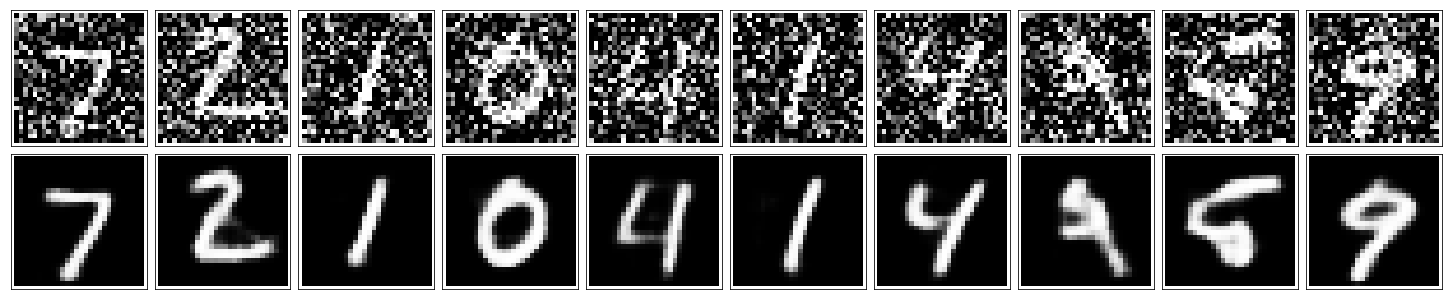

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)